# Datapipeline:

WARNING:

+ For the script to work the data files must be positiong in the data path of the repository.
Or the path to the data must be adapted accordingly. In this script all data must be in data_path
+ The *Data which is used : EU_all_current_shared.parquet* from Andreas preprocession.

Import the necessary libraries

0. Load the Data

* Load the data from a specified file using the appropriate function.
* Save the loaded data into a variable (called df) for further use.

1. Main data pipeline
Treat data to reach a point were we have the data frame ready for the separate treatments for classification and regression treatment

* 1.A: Omitting / deleting of variables which have no meaning for the model (explain why)
* 1.B: Omitting / deleting car identifiers because they are not relevant for the model
* 1.C: Omitting data before a certain year (explain why)
* 1.D: Treatment of outliers (explaing why)
    * Mean for gaussian like data
    * Other technique for non gaussian distributed data
* 1.E: Separation into electric cars and non electric cars (explain why)

2. Data pipeline for classification models
Prepare data so that it can be used for all basic classification models

* Loading data which has received the first/main data pipeline
*
*
*
* Separation into train and test data
* Scale data

3. Data pipeline for regression models
Prepare data so that it can be used for all basic regression models

* Loading data which has received the first/main data pipeline
*
*
*
* Separation into train and test data

4. Evaluation with baseline classification models

* Create different baselin models
* Train models
* Prediction
* Evaluation / Score

5. Evaluation with baseline regression models

* Create different baselin models
* Train models
* Prediction
* Evaluation / Score



# Importing necessary libraries

In [1]:
# Import the required libraries

# Data manipulation and math operations
import pandas as pd
import numpy as np
import pyarrow.parquet as pq  # For working with parquet files

# Visualization libraries
import matplotlib.pyplot as plt  # For Matplotlib visualizations
import seaborn as sns            # For Seaborn visualizations
import plotly.express as px      # For interactive visualizations with Plotly
# %matplotlib inline  # Uncomment for Jupyter notebooks to display plots inline

# System libraries
import warnings
import sys
import os
# Ignore all warnings (useful for ignoring non-critical warnings)
warnings.filterwarnings("ignore")

# Add the src directory to the system path
src_path = os.path.abspath(os.path.join('..', 'src'))
# for g-colab a cloned repo under MyDrive is assumed : /
if os.getcwd() == "/content": src_path =  "/content/drive/MyDrive/aug24_bds_int---co2/src"
if src_path not in sys.path: sys.path.append(src_path)

# Import utils library with custom functions
from utils_CO2 import *

# Machine Learning libraries
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # For encoding categorical variables and scaling features

# Regression model and evaluation
from sklearn.linear_model import LinearRegression  # For linear regression models
from sklearn.metrics import mean_squared_error  # For calculating mean squared error (MSE)

# Libraries for decision tree, random forest, and other machine learning models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  # For decision tree models (classification and regression)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # For random forest models (classification and regression)
from sklearn.svm import SVC  # For Support Vector Classification
from sklearn.neighbors import KNeighborsClassifier  # For K-Nearest Neighbors classification
from sklearn.metrics import accuracy_score, classification_report  # For model evaluation (classification metrics)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. Additional functions in between: Load, Save, Inspect - DFs

In [ ]:
# Path to the neighboring 'data' folder in the local repository
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))


0.C Define inspeciton function

# 1. Main data pipeline

In [ ]:
# Missing the preprocessing work from andreas
Andreas vorschritte von daten satz wie es von der EU seite kommt -> parquet file

In [ ]:
# The beginning of each section
# Loading the data frame
# Inspect the data frame
df = load_data_local('EU_all_current_shared_Okt_23.parquet', data_path)

inspect_data(df)

# 1.G Renaming/Mapping Categories

## **Import and read df**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from utils_CO2 import *

# set option so that e.g. df.head() will show all columns and none are omitted
pd.set_option('display.max_columns', None)

In [ ]:
# read 'EU_all_current_shared.parquet'
df = pd.read_parquet("..\\data\\EU\\EU all_dtypes_Tan_NaN_float32_Int64.parquet")

In [ ]:
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 14442792 rows, 41 columns

🔍 First 5 rows of the DataFrame:
       ID Country  VFN              Mp              Mh  \
0  280060      UK  NaN             NaN         UNKNOWN   
1  280060      GB  NaN             NaN         AUDI AG   
2  280060      PL  NaN     VW GROUP PC      VOLKSWAGEN   
3  280060      HU  NaN             NaN  HYUNDAI ASSAN    
4  280060      HU  NaN  GENERAL MOTORS            OPEL   

                                Man       MMS                  Tan  \
0                           UNKNOWN  VAUXHALL                  NaN   
1                               NaN      AUDI                  NaN   
2                     VOLKSWAGEN AG       NaN  e1*2001/116*0211*27   
3  HYUNDAI ASSAN OTOMOTIV SANAYI VE   Hyundai  e11*2007/46*0192*04   
4                      ADAM OPEL AG      Opel   e1*2007/46*0374*14   

             T       Va                       Ve              Mk  \
0  A-H/MONOCAB     BF11              2A05ASXEGA7      

## **Inspect categories**

In [ ]:
# First, inspect the unique categories in each categorical column
for col in df.select_dtypes(include=['category']):
    num_categories = df[col].nunique(dropna=False)
    print(f"Column '{col}' has {num_categories} unique categorical values (including NaN).")

Column 'Country' has 31 unique categorical values (including NaN).
Column 'VFN' has 29049 unique categorical values (including NaN).
Column 'Mp' has 47 unique categorical values (including NaN).
Column 'Mh' has 261 unique categorical values (including NaN).
Column 'Man' has 478 unique categorical values (including NaN).
Column 'MMS' has 11562 unique categorical values (including NaN).
Column 'Tan' has 49910 unique categorical values (including NaN).
Column 'T' has 26612 unique categorical values (including NaN).
Column 'Va' has 72534 unique categorical values (including NaN).
Column 'Ve' has 182641 unique categorical values (including NaN).
Column 'Mk' has 1746 unique categorical values (including NaN).
Column 'Cn' has 80815 unique categorical values (including NaN).
Column 'Ct' has 17 unique categorical values (including NaN).
Column 'Cr' has 9 unique categorical values (including NaN).
Column 'Ft' has 55 unique categorical values (including NaN).
Column 'Fm' has 15 unique categorical

## **f: rename categorical values**

In [ ]:
# Function to rename categorical values using mappings
def rename_catval(df, attribute, mappings):
    """
    Rename categorical values in a DataFrame column based on provided mappings.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be renamed.
    attribute (str): The name of the column to be renamed.
    mappings (list of tuples): Each tuple contains a list of aliases and the target name.
                               Example: [ (['old_name1', 'old_name2'], 'new_name'), ... ]
    """
    # Convert the column to a non-categorical type (e.g., string)
    df[attribute] = df[attribute].astype('string')

    # Build a rename dictionary from the mappings
    rename_dict = {}
    for aliases, target_name in mappings:
        for alias in aliases:
            rename_dict[alias] = target_name

    # Replace values
    df[attribute] = df[attribute].replace(rename_dict)

    # Convert the column back to categorical
    df[attribute] = df[attribute].astype('category')

## **Ct (Category of the vehicle type approved)**

In [ ]:
# Inspect the categories and value counts of 'Ct'
print(df.Ct.cat.categories)
df.Ct.value_counts()

Index([' ', '  ', 'M1', 'M1 ', 'M1  ', 'M1G', 'M1G ', 'M2 ', 'N1', 'N1 ',
       'N1G', 'N2', 'N2G', 'N3', 'N3G', 'm1'],
      dtype='object')


M1      13191645
M1G       988772
M1        189244
M1         20165
m1         15709
N1          7752
M1G         4550
N1G          114
N2            73
N1            27
              20
N3            19
N2G           10
               1
M2             1
N3G            1
Name: Ct, dtype: int64

In [ ]:
df[df.Ct == 'm1'].year.value_counts()

2017    15705
2021        4
Name: year, dtype: Int64

In [ ]:
df[df["year"] == 2017].Ct.value_counts()

M1      395054
m1       15705
M1G       9261
M1        4077
N1          35
N2           9
N1G          2
             0
             0
M1           0
M1G          0
M2           0
N1           0
N2G          0
N3           0
N3G          0
Name: Ct, dtype: int64

as it appears basically only in one year, "m1" seems to be a misspelling as well ==> rename to "M1"

In [ ]:
# Define mappings for 'Ct'
mappings_ct = [
    ([' ', '  '], pd.NA),
    (['M1 ', 'M1  ', 'm1'], 'M1'),
    (['M1G '], 'M1G'),
    (['M2 '], 'M2'),
    (['N1 '], 'N1'),
]

# Apply the renaming to the 'Ct' column
rename_catval(df, "Ct", mappings_ct)
print(df.Ct.cat.categories)
df.Ct.value_counts()

Index(['M1', 'M1G', 'M2', 'N1', 'N1G', 'N2', 'N2G', 'N3', 'N3G'], dtype='string')


M1     13416763
M1G      993322
N1         7779
N1G         114
N2           73
N3           19
N2G          10
M2            1
N3G           1
Name: Ct, dtype: int64

## **Cr (Category of the vehicle registered)**

In [ ]:
# Inspect the categories and value counts of 'Cr'
print(df.Cr.cat.categories)
df.Cr.value_counts()
df[df.Cr == 'm1'].year.value_counts()

Index([' ', 'M1', 'M1 ', 'M1  ', 'M1G', 'M1G ', 'M1S', 'm1'], dtype='object')


2019    236
2021      5
2018      2
Name: year, dtype: Int64

In [ ]:
df[df.Cr == 'M1S'].year.value_counts()

2022    19
Name: year, dtype: Int64

only one year ==> probably misspelling of "M1G"

In [ ]:
# Define mappings for 'Cr'
mappings_cr = [
    ([' ', '  '], pd.NA),
    (['M1 ', 'M1  ', 'm1'], 'M1'),
    (['M1G ', 'M1S'], 'M1G'),
]

# Apply the renaming to the 'Cr' column
rename_catval(df, "Cr", mappings_cr)
print(df.Cr.cat.categories)
df.Cr.value_counts()

Index(['M1', 'M1G'], dtype='string')


M1     10687330
M1G      928709
Name: Cr, dtype: int64

## **Fm (Fuel Mode)**

In [ ]:
# Inspect the categories and value counts of 'Fm'
print(df.Fm.cat.categories)
df.Fm.value_counts()

Index(['2', 'Alimentazione Sconosciuta', 'B', 'E', 'F', 'F  ', 'H', 'M', 'M  ',
       'P', 'h', 'm', 'na', 'p'],
      dtype='object')


M                            11486700
H                             1370724
P                              886030
E                              538105
B                               65385
F                                7513
na                               5194
M                                2229
m                                 188
F                                  18
p                                  17
2                                   7
h                                   3
Alimentazione Sconosciuta           1
Name: Fm, dtype: int64

In [ ]:
df[df.Fm == 'na'].Country.value_counts()

NL    5059
IT      95
DE      32
MT       5
RO       2
FI       1
AT       0
SK       0
SI       0
SE       0
PT       0
PL       0
NO       0
LV       0
LU       0
LT       0
IE       0
IS       0
BE       0
HU       0
HR       0
GR       0
GB       0
FR       0
ES       0
EE       0
DK       0
CZ       0
CY       0
BG       0
UK       0
Name: Country, dtype: int64

In [ ]:
df[df["Fm"].isna()]["Country"].value_counts()

NL    44926
ES    29351
MT     2886
BG     2717
PL      528
BE      129
DE       89
UK       11
FI       10
RO        6
CY        6
SK        5
LU        4
IT        3
GB        2
PT        2
DK        1
GR        1
SE        1
SI        0
NO        0
AT        0
LV        0
LT        0
IS        0
HU        0
HR        0
FR        0
EE        0
CZ        0
IE        0
Name: Country, dtype: int64

"na"concentrated in the Netherlands where there is a lot of pd.NA ==> treat "na" as pd.NA

In [ ]:
# Define mappings for 'Fm'
mappings_fm = [
    (['na', 'Alimentazione Sconosciuta', '2'], pd.NA),
    (['F  '], 'F'),
    (['M  ', 'm'], 'M'),
    (['h'], 'H'),
    (['p'], 'P'),
]

# Apply the renaming to the 'Fm' column
rename_catval(df, "Fm", mappings_fm)
print(df.Fm.cat.categories)
df.Fm.value_counts()

Index(['B', 'E', 'F', 'H', 'M', 'P'], dtype='string')


M    11489117
H     1370727
P      886047
E      538105
B       65385
F        7531
Name: Fm, dtype: int64

## **Ft (Fuel Type)**

In [ ]:
# Inspect the categories and value counts of 'Ft'
print(df.Ft.cat.categories)
df.Ft.value_counts()

Index([' ', 'BIODIESEL', 'Biodiesel', 'DIESEL', 'DIESEL                   ',
       'DIESEL-ELECTRIC', 'DIESEL/ELECTRIC', 'Diesel', 'Diesel-Electric',
       'Diesel-electric', 'Diesel/Electric', 'Diesel/electric', 'E85',
       'ELECTRIC', 'Electric', 'Electric                 ', 'HYDROGEN',
       'Hydrogen', 'LPG', 'LPG                      ', 'NG', 'NG-BIOMETHANE',
       'NG-Biomethane', 'NG-biomethane', 'NG-biomethane            ',
       'NG_biomethane', 'OTHER', 'Other', 'PETROL', 'PETROL ',
       'PETROL                   ', 'PETROL-ELECTRIC', 'PETROL/ELECTRIC',
       'Petrol', 'Petrol ', 'Petrol-Electric', 'Petrol-Gas', 'Petrol-electric',
       'Petrol/Electric', 'UNKNOWN', 'diesel', 'diesel-electric',
       'diesel/electric', 'e85', 'electric', 'hydrogen', 'lpg', 'ng',
       'ng-biomethane', 'petrol', 'petrol ', 'petrol-electric',
       'petrol/electric', 'unknown'],
      dtype='object')


PETROL                       3322376
DIESEL                       2945617
petrol                       2228168
diesel                       2003718
Diesel                       1320232
Petrol                       1006352
PETROL/ELECTRIC               550171
ELECTRIC                      296497
petrol/electric               266837
electric                      233016
DIESEL/ELECTRIC                53038
LPG                            40570
diesel/electric                25681
NG                             18718
                               16995
lpg                            14985
Petrol/Electric                14454
DIESEL                         12494
Electric                       11011
E85                             8766
NG-biomethane                   8720
ng                              8593
NG-BIOMETHANE                   6440
PETROL                          6059
ng-biomethane                   4058
Petrol-electric                 3371
e85                             2391
p

In [ ]:
# Define mappings for 'Ft'
mappings_ft = [
    # Map 'PETROL' variants
    ([
        'PETROL', 'PETROL ', 'PETROL                   ', 'Petrol', 'Petrol ', 'petrol', 'petrol ', 'Petrol-Gas'
    ], 'PETROL'),
    # Map 'DIESEL' variants
    ([
        'DIESEL', 'DIESEL                   ', 'Diesel', 'diesel'
    ], 'DIESEL'),
    # Map 'PETROL/ELECTRIC' variants
    ([
        'PETROL-ELECTRIC', 'PETROL/ELECTRIC', 'Petrol-Electric', 'Petrol-electric',
        'Petrol/Electric', 'petrol-electric', 'petrol/electric'
    ], 'PETROL/ELECTRIC'),
    # Map 'DIESEL/ELECTRIC' variants
    ([
        'DIESEL-ELECTRIC', 'DIESEL/ELECTRIC', 'Diesel-Electric', 'Diesel-electric',
        'Diesel/Electric', 'Diesel/electric', 'diesel-electric', 'diesel/electric'
    ], 'DIESEL/ELECTRIC'),
    # Map 'ELECTRIC' variants
    ([
        'ELECTRIC', 'Electric', 'Electric                 ', 'electric'
    ], 'ELECTRIC'),
    # Map 'LPG' variants
    ([
        'LPG', 'LPG                      ', 'lpg'
    ], 'LPG'),
    # Map 'NG-BIOMETHANE' variants
    ([
        'NG-BIOMETHANE', 'NG-Biomethane', 'NG-biomethane', 'NG-biomethane            ',
        'NG_biomethane', 'ng-biomethane', 'NG', 'ng'
    ], 'NG-BIOMETHANE'),
    # Map 'HYDROGEN' variants
    ([
        'HYDROGEN', 'Hydrogen', 'hydrogen'
    ], 'HYDROGEN'),
    # Map 'E85' variants
    ([
        'E85', 'e85'
    ], 'E85'),
    # Map 'BIODIESEL' variants
    ([
        'BIODIESEL', 'Biodiesel'
    ], 'BIODIESEL'),
    # Map 'OTHER' variants
    ([
        'OTHER', 'Other'
    ], 'OTHER'),
    # Map unknown variants to pd.NA
    ([
        'UNKNOWN', 'unknown', ' '
    ], pd.NA),
]

# Apply the renaming to the 'Ft' column
rename_catval(df, "Ft", mappings_ft)
print(df.Ft.cat.categories)
df.Ft.value_counts(dropna=False)

Index(['BIODIESEL', 'DIESEL', 'DIESEL/ELECTRIC', 'E85', 'ELECTRIC', 'HYDROGEN',
       'LPG', 'NG-BIOMETHANE', 'OTHER', 'PETROL', 'PETROL/ELECTRIC'],
      dtype='string')


PETROL             6563371
DIESEL             6282061
PETROL/ELECTRIC     837545
ELECTRIC            540712
DIESEL/ELECTRIC      80397
LPG                  55900
NG-BIOMETHANE        46859
NaN                  24373
E85                  11157
HYDROGEN               314
BIODIESEL               94
OTHER                    9
Name: Ft, dtype: int64

## **Country**

In [ ]:
# Inspect the categories and value counts of 'Country'
print(df.Country.cat.categories)
df.Country.value_counts(dropna=False)

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB',
       'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO',
       'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'UK'],
      dtype='object')


DE    4543321
FR    1205514
IT    1015799
BE     953725
GB     806369
AT     740210
PL     706497
ES     705075
NL     453097
SE     400220
CZ     382540
LU     261769
SK     258416
HU     225802
DK     218723
PT     211956
FI     206949
RO     189734
SI     154920
GR     140088
IE     108558
BG      91622
LT      74733
EE      71633
HR      69821
UK      60569
NO      57066
LV      56635
MT      37243
CY      25292
IS       8896
Name: Country, dtype: int64

In [ ]:
# Check GB and UK
print("UK:", df[df.Country == "UK"].year.value_counts())
print("GB:", df[df.Country == "GB"].year.value_counts())

UK: 2010    60569
Name: year, dtype: Int64
GB: 2019    203328
2020    147335
2018    107083
2011     59294
2012     58269
2016     48916
2017     48504
2013     45627
2014     44746
2015     43267
Name: year, dtype: Int64


GB and UK are complementary ==> rename all to UK

In [ ]:
# Define mappings for 'Country'
mappings_country = [
    (['GB'], 'UK'),
]

# Apply the renaming to the 'Country' column
rename_catval(df, "Country", mappings_country)
print(df.Country.cat.categories)
df.Country.value_counts()

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO', 'PL',
       'PT', 'RO', 'SE', 'SI', 'SK', 'UK'],
      dtype='string')


DE    4543321
FR    1205514
IT    1015799
BE     953725
UK     866938
AT     740210
PL     706497
ES     705075
NL     453097
SE     400220
CZ     382540
LU     261769
SK     258416
HU     225802
DK     218723
PT     211956
FI     206949
RO     189734
SI     154920
GR     140088
IE     108558
BG      91622
LT      74733
EE      71633
HR      69821
NO      57066
LV      56635
MT      37243
CY      25292
IS       8896
Name: Country, dtype: int64

#### optional: rename to full country names

In [ ]:
# optional: rename to full country names

rename_dict = {
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'CY': 'Cyprus',
    'CZ': 'Czech Republic',
    'DE': 'Germany',
    'DK': 'Denmark',
    'EE': 'Estonia',
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'GB': 'United Kingdom',  # 'GB' often refers to the UK
    'GR': 'Greece',
    'HR': 'Croatia',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IS': 'Iceland',
    'IT': 'Italy',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'LV': 'Latvia',
    'MT': 'Malta',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'SK': 'Slovakia',
    'UK': 'United Kingdom'  # Mapping 'UK' to 'United Kingdom' as well
}

rename_catval(df,"Country",rename_dict)

## **=== save/read (EU_all_current_shared) ===**

In [ ]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared.parquet")

## **Mp**

In [ ]:
print(df.Mp.cat.categories)
df.Mp.value_counts()

Index(['BMW', 'BMW GROUP', 'DAIMLER AG', 'FCA', 'FCA ITALY SPA', 'FCA-TESLA',
       'FIAT GROUP AUTOMOBILES SPA', 'FORD', 'FORD POOL', 'FORD-WERKE GMBH',
       'GENERAL MOTORS', 'HONDA MOTOR EUROPE LTD', 'HYUNDAI',
       'HYUNDAI MOTOR EUROPE', 'JLT POOL', 'KG MOBILITY GREAT WALL MOTOR',
       'KIA', 'MAZDA', 'MAZDA-SUBARU-SUZUKI-TOYOTA', 'MERCEDES-BENZ',
       'MERCEDES-BENZ AG', 'MG-SAIC', 'MITSUBISHI MOTORS', 'MITSUBISHI POOL',
       'POOL RENAULT', 'PSA', 'PSA-OPEL', 'RENAULT', 'RENAULT-MITSUBISHI',
       'RENAULT-NISSAN-MITSUBISHI', 'STELLANTIS', 'SUBARU-SUZUKI-TOYOTA',
       'SUZUKI', 'SUZUKI POOL', 'TATA MOTORS JAGUAR LAND ROVER',
       'TATA MOTORS LTD, JAGUAR CARS LTD , LAND ROVER',
       'TATA MOTORS LTD, JAGUAR CARS LTD, LAND ROVER', 'TESLA',
       'TESLA-HONDA-JLR', 'TOYOTA -DAIHATSU GROUP', 'TOYOTA-DAHAITSU GROUP',
       'TOYOTA-MAZDA', 'VOLKSWAGEN', 'VW GROUP PC', 'VW-SAIC', 'na'],
      dtype='object')


VOLKSWAGEN                                       2446297
VW GROUP PC                                      1938866
BMW                                              1133403
BMW GROUP                                         827705
VW-SAIC                                           792555
MERCEDES-BENZ                                     768198
DAIMLER AG                                        750495
STELLANTIS                                        514750
PSA-OPEL                                          444418
FORD-WERKE GMBH                                   402987
FORD                                              378882
RENAULT-NISSAN-MITSUBISHI                         264594
MERCEDES-BENZ AG                                  258285
RENAULT                                           233984
GENERAL MOTORS                                    214183
PSA                                               201674
KIA                                               134935
RENAULT-MITSUBISHI             

In [ ]:
# Share of NAs in coluumn "Mp" per year
df[df.Mp.isna()].year.value_counts()/df[df.Mp.isna()].year.shape[0]

2011    0.201999
2010    0.161852
2019    0.106234
2018    0.078397
2023    0.070553
2021    0.065618
2022    0.054267
2013    0.051249
2017    0.047979
2020    0.046909
2012    0.041457
2016    0.038732
2015    0.034754
Name: year, dtype: Float64

In [ ]:
# Create a contingency table using pd.crosstab
mp_year_table = pd.crosstab(df['Mp'], df['year'], dropna=False)

# Display the table
print(mp_year_table)

year                                            2010  2011   2012   2013  \
Mp                                                                         
BMW                                                0     0      0      0   
BMW GROUP                                          0     0  23302  29066   
DAIMLER AG                                         0     0  27991  37766   
FCA                                                0     0      0      0   
FCA ITALY SPA                                      0     0      0      0   
FCA-TESLA                                          0     0      0      0   
FIAT GROUP AUTOMOBILES SPA                         0     0  19558  28566   
FORD                                               0     0      0      0   
FORD POOL                                      14998     0      0      0   
FORD-WERKE GMBH                                    0     0  17038  17605   
GENERAL MOTORS                                     0     0  31673  39903   
HONDA MOTOR 

In [ ]:
# Detailed mapping by ChatGPT considering mergers/aquisitions and pooling agreements changing over time:

import pandas as pd

# mapping list with pd.NA for missing values
mapping_list = [
    # BMW Group remained consistent throughout the years
    {'old_names': ['BMW', 'BMW GROUP'], 'new_name': 'BMW Group', 'start_year': None, 'end_year': None},

    # Daimler AG operated under this name until it rebranded in 2022
    {'old_names': ['DAIMLER AG'], 'new_name': 'Daimler AG', 'start_year': None, 'end_year': 2021},

    # From 2022 onwards, Daimler AG rebranded to Mercedes-Benz Group
    {'old_names': ['MERCEDES-BENZ AG', 'MERCEDES-BENZ'], 'new_name': 'Mercedes-Benz Group', 'start_year': 2022, 'end_year': None},

    # Fiat Chrysler Automobiles (FCA) operated until merging with PSA to form Stellantis in 2021
    {'old_names': ['FIAT GROUP AUTOMOBILES SPA', 'FCA', 'FCA ITALY SPA'], 'new_name': 'Fiat Chrysler Automobiles', 'start_year': None, 'end_year': 2020},

    # PSA Group operated independently until merging with FCA to form Stellantis in 2021
    {'old_names': ['PSA', 'PSA-OPEL'], 'new_name': 'PSA Group', 'start_year': None, 'end_year': 2020},

    # Stellantis formed in 2021 from the merger of FCA and PSA
    {'old_names': ['STELLANTIS'], 'new_name': 'Stellantis', 'start_year': 2021, 'end_year': None},

    # Ford Motor Company remained consistent throughout
    {'old_names': ['FORD', 'FORD POOL', 'FORD-WERKE GMBH'], 'new_name': 'Ford', 'start_year': None, 'end_year': None},

    # General Motors remained consistent throughout
    {'old_names': ['GENERAL MOTORS'], 'new_name': 'General Motors', 'start_year': None, 'end_year': None},

    # Honda Motor Company remained consistent throughout
    {'old_names': ['HONDA MOTOR EUROPE LTD'], 'new_name': 'Honda', 'start_year': None, 'end_year': None},

    # Hyundai Motor Company remained consistent throughout
    {'old_names': ['HYUNDAI', 'HYUNDAI MOTOR EUROPE'], 'new_name': 'Hyundai', 'start_year': None, 'end_year': None},

    # Kia Motors remained consistent throughout
    {'old_names': ['KIA'], 'new_name': 'Kia', 'start_year': None, 'end_year': None},

    # Jaguar Land Rover has been owned by Tata Motors since 2008
    {'old_names': [
        'TATA MOTORS JAGUAR LAND ROVER',
        'TATA MOTORS LTD, JAGUAR CARS LTD , LAND ROVER',
        'TATA MOTORS LTD, JAGUAR CARS LTD, LAND ROVER'
    ], 'new_name': 'Jaguar Land Rover', 'start_year': 2008, 'end_year': None},

    # Mazda operated independently up to 2018
    {'old_names': ['MAZDA'], 'new_name': 'Mazda', 'start_year': None, 'end_year': 2018},

    # Mazda and Toyota entered a pooling agreement from 2019 to 2020
    {'old_names': ['MAZDA', 'TOYOTA-MAZDA'], 'new_name': 'Toyota-Mazda', 'start_year': 2019, 'end_year': 2020},

    # Mazda joined a larger pooling agreement with Toyota, Suzuki, and Subaru from 2021 onwards
    {'old_names': ['MAZDA'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Suzuki operated independently up to 2018
    {'old_names': ['SUZUKI', 'SUZUKI POOL'], 'new_name': 'Suzuki', 'start_year': None, 'end_year': 2018},

    # Suzuki and Toyota entered a pooling agreement from 2019 to 2020
    {'old_names': ['SUZUKI'], 'new_name': 'Toyota-Suzuki', 'start_year': 2019, 'end_year': 2020},

    # Suzuki joined the larger pooling agreement with Toyota, Mazda, and Subaru from 2021 onwards
    {'old_names': ['SUZUKI'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Subaru operated independently up to 2020
    {'old_names': ['SUBARU'], 'new_name': 'Subaru', 'start_year': None, 'end_year': 2020},

    # Subaru joined the pooling agreement with Toyota, Mazda, and Suzuki from 2021 onwards
    {'old_names': ['SUBARU'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Toyota operated independently up to 2018
    {'old_names': ['TOYOTA', 'TOYOTA -DAIHATSU GROUP', 'TOYOTA-DAHAITSU GROUP'], 'new_name': 'Toyota', 'start_year': None, 'end_year': 2018},

    # Toyota and Mazda entered a pooling agreement from 2019 to 2020
    {'old_names': ['TOYOTA'], 'new_name': 'Toyota-Mazda', 'start_year': 2019, 'end_year': 2020},

    # Toyota expanded its pooling agreement to include Mazda, Suzuki, and Subaru from 2021 onwards
    {'old_names': ['TOYOTA', 'MAZDA-SUBARU-SUZUKI-TOYOTA', 'SUBARU-SUZUKI-TOYOTA'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Reflects the Toyota-Mazda pooling agreement during 2019-2020
    {'old_names': ['TOYOTA-MAZDA'], 'new_name': 'Toyota-Mazda', 'start_year': 2019, 'end_year': 2020},

    # Reflects the expanded pooling agreement including Mazda, Suzuki, and Subaru from 2021 onwards
    {'old_names': ['MAZDA-SUBARU-SUZUKI-TOYOTA', 'SUBARU-SUZUKI-TOYOTA'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Mitsubishi Motors operated independently up to 2015
    {'old_names': ['MITSUBISHI MOTORS'], 'new_name': 'Mitsubishi Motors', 'start_year': None, 'end_year': 2015},

    # Mitsubishi joined the Renault-Nissan-Mitsubishi Alliance in 2016
    {'old_names': ['MITSUBISHI MOTORS'], 'new_name': 'Renault-Nissan-Mitsubishi Alliance', 'start_year': 2016, 'end_year': None},

    # Renault operated independently up to 1998
    {'old_names': ['RENAULT', 'POOL RENAULT'], 'new_name': 'Renault', 'start_year': None, 'end_year': 1998},

    # Renault formed an alliance with Nissan from 1999 to 2015
    {'old_names': ['RENAULT', 'POOL RENAULT', 'RENAULT-MITSUBISHI'], 'new_name': 'Renault-Nissan Alliance', 'start_year': 1999, 'end_year': 2015},

    # Mitsubishi joined the alliance in 2016
    {'old_names': ['RENAULT', 'POOL RENAULT', 'RENAULT-MITSUBISHI', 'RENAULT-NISSAN-MITSUBISHI'], 'new_name': 'Renault-Nissan-Mitsubishi Alliance', 'start_year': 2016, 'end_year': None},

    # Volkswagen Group remained consistent throughout
    {'old_names': ['VOLKSWAGEN', 'VW GROUP PC', 'VW-SAIC'], 'new_name': 'Volkswagen Group', 'start_year': None, 'end_year': None},

    # SAIC Motor Corporation remained consistent
    {'old_names': ['MG-SAIC'], 'new_name': 'SAIC Motor', 'start_year': None, 'end_year': None},

    # Great Wall Motor remained consistent
    {'old_names': ['KG MOBILITY GREAT WALL MOTOR'], 'new_name': 'Great Wall Motor', 'start_year': None, 'end_year': None},

    # Tesla remained independent
    {'old_names': ['TESLA'], 'new_name': 'Tesla', 'start_year': None, 'end_year': None},

    # Reflects pooling agreement between FCA and Tesla
    {'old_names': ['FCA-TESLA'], 'new_name': 'FCA-Tesla', 'start_year': None, 'end_year': None},

    # Adding mapping for 'JLT POOL'
    {'old_names': ['JLT POOL'], 'new_name': 'Jaguar Land Rover - Tesla Pool', 'start_year': None, 'end_year': None},

    # Adding mapping for 'MITSUBISHI POOL'
    {'old_names': ['MITSUBISHI POOL'], 'new_name': 'Mitsubishi Motors', 'start_year': None, 'end_year': 2015},
    {'old_names': ['MITSUBISHI POOL'], 'new_name': 'Renault-Nissan-Mitsubishi Alliance', 'start_year': 2016, 'end_year': None},

    # Adding mapping for 'TESLA-HONDA-JLR'
    {'old_names': ['TESLA-HONDA-JLR'], 'new_name': 'Tesla-Honda-Jaguar Land Rover Pool', 'start_year': None, 'end_year': None},

    # Missing values represented as pd.NA
    {'old_names': ['na'], 'new_name': pd.NA, 'start_year': None, 'end_year': None},
]



In [ ]:
# Rename routine by ChatGPT to apply mapping:

# Ensure 'year' is integer and 'Mp' is string type
df['year'] = df['year'].astype(int)
df['Mp'] = df['Mp'].astype(object)  # Object type to handle pd.NA correctly

# Reset index to keep track of original row order
df.reset_index(inplace=True)

# Create mapping DataFrame from mapping_list
mapping_entries = []
for mapping in mapping_list:
    for old_name in mapping['old_names']:
        mapping_entries.append({
            'old_name': old_name,
            'new_name': mapping['new_name'],
            'start_year': mapping['start_year'],
            'end_year': mapping['end_year']
        })
mapping_df = pd.DataFrame(mapping_entries)

# Merge df with mapping_df on 'Mp' and 'old_name'
df_merged = df.merge(mapping_df, left_on='Mp', right_on='old_name', how='left', suffixes=('', '_mapped'))

# Replace None with -infinity or infinity for comparison
df_merged['start_year'] = df_merged['start_year'].fillna(-np.inf)
df_merged['end_year'] = df_merged['end_year'].fillna(np.inf)

# Create mask for rows where 'year' falls within 'start_year' and 'end_year'
year_mask = (df_merged['year'] >= df_merged['start_year']) & (df_merged['year'] <= df_merged['end_year'])

# Assign 'Mp_standardized' where conditions are met, else NaN
df_merged['Mp_standardized'] = np.where(year_mask, df_merged['new_name'], pd.NA)

# Calculate period length for prioritization (shorter periods first)
df_merged['period_length'] = df_merged['end_year'] - df_merged['start_year']
df_merged['period_length'].replace(np.inf, 9999, inplace=True)
df_merged['period_length'].replace(-np.inf, -9999, inplace=True)

# Sort by 'index' and 'period_length' to prioritize more specific mappings
df_merged.sort_values(by=['index', 'period_length'], ascending=[True, True], inplace=True)

# Drop duplicates to keep the first (most specific) mapping per row
df_merged = df_merged.drop_duplicates(subset='index', keep='first')

# Set index to 'index' for merging back
df.set_index('index', inplace=True)
df_merged.set_index('index', inplace=True)

# Assign standardized names
df['Mp'] = df_merged['Mp_standardized']

# convert 'Mp' and 'Mp_standardized' back to categorical
df['Mp'] = df['Mp'].astype('category')
#df['Mp_standardized'] = df['Mp_standardized'].astype('category')

# Reset index if needed
df.reset_index(drop=True, inplace=True)



In [ ]:
print(df.Mp.cat.categories)
df.Mp.value_counts()

Index(['BMW Group', 'Daimler AG', 'FCA-Tesla', 'Fiat Chrysler Automobiles',
       'Ford', 'General Motors', 'Great Wall Motor', 'Honda', 'Hyundai',
       'Jaguar Land Rover', 'Jaguar Land Rover - Tesla Pool', 'Kia',
       'Mercedes-Benz Group', 'Mitsubishi Motors', 'PSA Group',
       'Renault-Nissan Alliance', 'Renault-Nissan-Mitsubishi Alliance',
       'SAIC Motor', 'Stellantis', 'Suzuki', 'Tesla',
       'Tesla-Honda-Jaguar Land Rover Pool', 'Toyota', 'Toyota-Mazda',
       'Toyota-Mazda-Suzuki-Subaru', 'Toyota-Suzuki', 'Volkswagen Group'],
      dtype='object')


Volkswagen Group                      5177718
BMW Group                             1961108
Ford                                   796867
Daimler AG                             750495
PSA Group                              646092
Mercedes-Benz Group                    522098
Stellantis                             514750
Renault-Nissan-Mitsubishi Alliance     264594
General Motors                         214183
Fiat Chrysler Automobiles              199756
Hyundai                                135167
Kia                                    134935
Jaguar Land Rover                      125408
Renault-Nissan Alliance                122356
Toyota-Mazda-Suzuki-Subaru             109525
FCA-Tesla                               79483
Toyota-Mazda                            67455
Toyota                                  35184
Tesla                                   34084
Tesla-Honda-Jaguar Land Rover Pool      28802
Honda                                   25633
Suzuki                            

In [ ]:
# Create a contingency table using pd.crosstab
mp_year_table = pd.crosstab(df['Mp'], df['year'], dropna=False)

# Display the table
print(mp_year_table)

year                                 2010  2011   2012   2013    2014    2015  \
Mp                                                                              
BMW Group                               0     0  23302  29066   35780   44812   
Daimler AG                              0     0  27991  37766   40060   42820   
FCA-Tesla                               0     0      0      0       0       0   
Fiat Chrysler Automobiles               0     0  19558  28566   17933   16129   
Ford                                14998     0  17038  17605   16937   18478   
General Motors                          0     0  31673  39903   38968   34812   
Great Wall Motor                        0     0      0      0       0       0   
Honda                                   0     0   2519   3048    2990    2746   
Hyundai                                 0     0      0      0    6987    7860   
Jaguar Land Rover                       0     0   3035   4556    5380    6985   
Jaguar Land Rover - Tesla Po

## **Mh**

In [ ]:
print("Mh: ", df.Mh.nunique(), "Man: ", df.Man.nunique(), "MMS: ", df.MMS.nunique())

Mh:  261 Man:  477 MMS:  11561


In [ ]:
with pd.option_context('display.max_rows', None):
    print(df.Mh.value_counts())

with pd.option_context('display.max_rows', None):
    print(df.Man.value_counts())

VOLKSWAGEN                                          1953152
BMW AG                                              1938865
AUDI AG                                             1419262
SKODA                                               1163682
MERCEDES-BENZ AG                                    1024769
DAIMLER AG                                           800436
FORD WERKE GMBH                                      688357
RENAULT                                              550884
VOLVO                                                538602
SEAT                                                 496161
AUTOMOBILES PEUGEOT                                  337900
OPEL AUTOMOBILE                                      304787
PSA                                                  279158
OPEL                                                 268778
FIAT GROUP                                           260815
JAGUAR LAND ROVER LIMITED                            259382
PORSCHE                                 

In [ ]:
# Temporarily set the option to display all rows
with pd.option_context('display.max_rows', None, 'display.max_seq_items', None):
    # Convert the unique values to a pandas Series to ensure full display
    print(pd.Series(df['Mh'].value_counts()))


VOLKSWAGEN                                          1953152
BMW AG                                              1938865
AUDI AG                                             1419262
SKODA                                               1163682
MERCEDES-BENZ AG                                    1024769
DAIMLER AG                                           800436
FORD WERKE GMBH                                      688357
RENAULT                                              550884
VOLVO                                                538602
SEAT                                                 496161
AUTOMOBILES PEUGEOT                                  337900
OPEL AUTOMOBILE                                      304787
PSA                                                  279158
OPEL                                                 268778
FIAT GROUP                                           260815
JAGUAR LAND ROVER LIMITED                            259382
PORSCHE                                 

In [ ]:
# Define the mappings with reasoning for each remapped value
import pandas as pd

mappings = [
    # 'DAIMLER AG' changed its name to 'MERCEDES-BENZ AG'
    (['DAIMLER AG'], 'MERCEDES-BENZ AG'),
    # 'NISSAN' is mapped to 'NISSAN AUTOMOTIVE EUROPE' as the official entity
    (['NISSAN'], 'NISSAN AUTOMOTIVE EUROPE'),
    # 'STELLANTIS AUTO' is mapped to 'STELLANTIS EUROPE' as per official naming
    (['STELLANTIS AUTO'], 'STELLANTIS EUROPE'),
    # Entries labeled 'duplicate' are mapped to 'duplicate' instead of 'UNKNOWN'
    (['DUPLICATE', 'Duplicate', 'duplicate'], 'duplicate'),
    # 'FIAT GROUP AUTOMOBILES SPA' is simplified to 'FIAT GROUP'
    (['FIAT GROUP AUTOMOBILES SPA'], 'FIAT GROUP'),
    # Full company name 'BAYERISCHE MOTOREN WERKE AG' is mapped to 'BMW AG'
    (['BAYERISCHE MOTOREN WERKE AG'], 'BMW AG'),
    # 'TOYOTA MOTOR CORPORATION' and 'TOYOTA MOTOR EUROPE' are simplified to 'TOYOTA'
    (['TOYOTA MOTOR CORPORATION', 'TOYOTA MOTOR EUROPE'], 'TOYOTA'),
    # Correcting typo in 'FORD-WERKE GMBH' to 'FORD WERKE GMBH'
    (['FORD-WERKE GMBH'], 'FORD WERKE GMBH'),
    # Mapping various regional 'HONDA' entities to 'HONDA MOTOR CO'
    (['HONDA UK', 'HONDA OF THE UK MANUFACTURING', 'HONDA TURKIYE', 'HONDA TURKIYE AS',
      'HONDA CHINA', 'HONDA AUTOMOBILE CHINA CO', 'HONDA THAILAND', 'HONDA AUTOMOBILE THAILAND CO'],
     'HONDA MOTOR CO'),
    # 'FUJI HEAVY INDUSTRIES' and 'FUJI HEAVY INDUSTRIES LTD' are parent companies of 'SUBARU'
    (['FUJI HEAVY INDUSTRIES', 'FUJI HEAVY INDUSTRIES LTD'], 'SUBARU'),
    # 'LAND ROVER' is part of 'JAGUAR LAND ROVER LIMITED'
    (['LAND ROVER'], 'JAGUAR LAND ROVER LIMITED'),
    # 'CHRYSLER GROUP LLC' is simplified to 'CHRYSLER'
    (['CHRYSLER GROUP LLC'], 'CHRYSLER'),
    # Full company name 'MAZDA MOTOR CORPORATION' is simplified to 'MAZDA'
    (['MAZDA MOTOR CORPORATION'], 'MAZDA'),
    # 'QUATTRO' is a model line of 'AUDI AG'
    (['QUATTRO'], 'AUDI SPORT'),
    # Correcting double space typo in 'HYUNDAI  CZECH' to 'HYUNDAI CZECH'
    (['HYUNDAI  CZECH'], 'HYUNDAI CZECH'),
    # Correcting misspelling in 'MITSUBISHI MOTORS CORPORTION MMC' to 'MITSUBISHI MOTORS CORPORATION'
    (['MITSUBISHI MOTORS CORPORTION MMC'], 'MITSUBISHI MOTORS CORPORATION'),
    # 'GM DAEWOO AUTO U TECH COMP' is now known as 'GM KOREA'
    (['GM DAEWOO AUTO U TECH COMP'], 'GM KOREA'),
    # 'SAAB AUTOMOBILE AB' is simplified to 'SAAB'
    (['SAAB AUTOMOBILE AB'], 'SAAB'),
    # 'AVTOVAZ' is the manufacturer of 'LADA' cars
    (['AVTOVAZ'], 'LADA'),
    # 'BMW M GMBH' is now mapped to 'BMW GMBH'
    (['BMW M GMBH'], 'BMW GMBH'),
    # 'KG MOBILITY' is the new name for 'SSANGYONG' as of 2023
    (['KG MOBILITY'], 'SSANGYONG'),
    # Full company name 'MAGYAR SUZUKI CORPORATION LTD' is simplified to 'MAGYAR SUZUKI'
    (['MAGYAR SUZUKI CORPORATION LTD'], 'MAGYAR SUZUKI'),
    # 'GTF INNOVATIONS' left as is
    (['GTF INNOVATIONS'], 'GTF INNOVATIONS'),
    # 'HYUNDAI EUROPE' is simplified to 'HYUNDAI'
    (['HYUNDAI EUROPE'], 'HYUNDAI'),
    # Full company name 'DAIHATSU MOTOR CO' is simplified to 'DAIHATSU'
    (['DAIHATSU MOTOR CO'], 'DAIHATSU'),
    # 'MITSUBISHI MOTORS EUROPE BV MME' is simplified to 'MITSUBISHI MOTORS EUROPE'
    (['MITSUBISHI MOTORS EUROPE BV MME'], 'MITSUBISHI MOTORS EUROPE'),
    # Full company name 'ASTON MARTIN LAGONDA LTD' is simplified to 'ASTON MARTIN'
    (['ASTON MARTIN LAGONDA LTD'], 'ASTON MARTIN'),
    # 'LOTUS GROUP PLC' is simplified to 'LOTUS'
    (['LOTUS GROUP PLC'], 'LOTUS'),
    # Full company name 'MASERATI SPA' is simplified to 'MASERATI'
    (['MASERATI SPA'], 'MASERATI'),
    # Correcting double space typo in 'HYUNDAI  INDIA' to 'HYUNDAI INDIA'
    (['HYUNDAI  INDIA'], 'HYUNDAI INDIA'),
    # 'MIA' is left as is
    (['MIA'], 'MIA'),
    # 'GM ITALIA' is mapped to 'GENERAL MOTORS HOLDINGS' as the parent company
    (['GM ITALIA'], 'GENERAL MOTORS HOLDINGS'),
    # 'LADA FRANCE' is simplified to 'LADA'
    (['LADA FRANCE'], 'LADA'),
    # 'DR MOTOR COMPANY' is simplified to 'DR MOTOR'
    (['DR MOTOR COMPANY'], 'DR MOTOR'),
    # Correcting plural in 'JIANGLING MOTORS' to 'JIANGLING MOTOR'
    (['JIANGLING MOTORS'], 'JIANGLING MOTOR'),
    # Correcting spelling in 'ZOYTE' to 'ZOTYE'
    (['ZOYTE'], 'ZOTYE'),
    # 'LANZHOU ZHIDOU' is simplified to 'LANZHOU'
    (['LANZHOU ZHIDOU'], 'LANZHOU'),
    # 'OUT OF SCOPE' is turned to pd.NA
    (['OUT OF SCOPE'], pd.NA),
]


# Now, apply the mapping to our DataFrame
rename_catval(df, 'Mh', mappings)


In [ ]:
df[df.Mh =="duplicate"].year.value_counts()

2019    13197
2018    12248
2023     3598
2020     2997
2021     2249
2022      121
2017       10
Name: year, dtype: int64

## **IT, Ernedc, Erwltp**

### **explore**

In [ ]:
df.IT.value_counts()

e1 29               348575
E1 29               206902
e8 29 37            184344
e13 29 37           141103
e13 29              135410
                     ...  
e4 / e4 28               1
E2 E2 29                 1
E2 37 029                1
e4 17 19e4 29 28         1
no                       1
Name: IT, Length: 1928, dtype: int64

<Axes: >

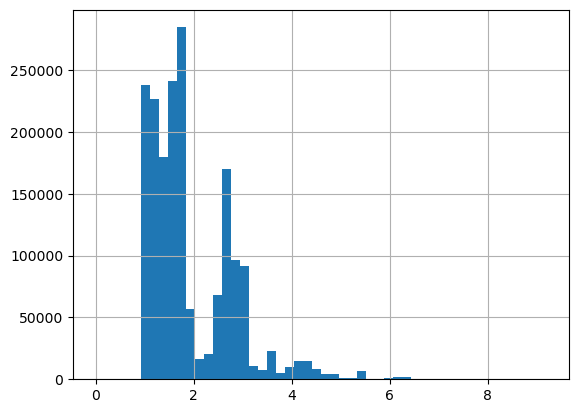

In [ ]:
df["Ernedc (g/km)"].hist(bins = 50)

(0.0, 5.0)

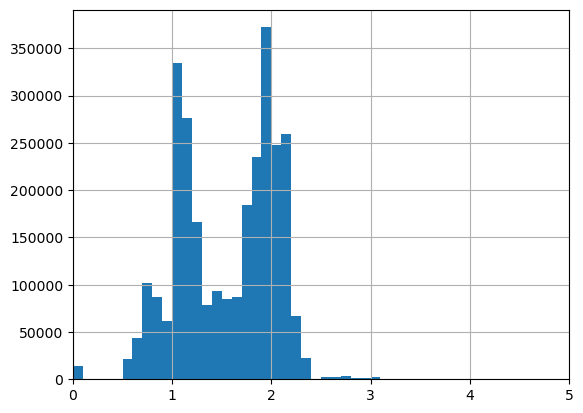

In [ ]:
df["Erwltp (g/km)"].hist(bins = 200)
plt.xlim(0,5)

### **clean**

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2.parquet")

#### Step 1-8: cleanup

In [ ]:
import re
import pandas as pd

# Assuming df is your DataFrame and 'IT' is the column to be processed

# Step 0: Initialize 'IT_valid' and 'IT_invalid' columns with np.nan
df['IT_valid'] = np.nan
df['IT_invalid'] = df['IT']

# Step 1: Replace Invalid Characters
def replace_invalid_chars(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values that have invalid characters
    matches = original_series.str.contains(r'[^a-zA-Z0-9\+\?]', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Replace invalid characters with space
    series[matches] = series[matches].str.replace(r'[^a-zA-Z0-9\+\?]', ' ', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 1
df['IT_invalid'], matched_values_invalid_chars, modified_rows_invalid_chars, diff_nunique_invalid_chars = replace_invalid_chars(df['IT_invalid'])
print(f"Modified {modified_rows_invalid_chars} rows by replacing invalid characters.")
print(f"Change in number of unique values: {diff_nunique_invalid_chars}")
print("Values that had invalid characters (original state):")
print(matched_values_invalid_chars)

# Step 2: Strip Leading and Trailing Spaces
def strip_spaces(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values with leading or trailing spaces
    matches = original_series.str.contains(r'^\s+|\s+$', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Strip leading and trailing spaces
    series[matches] = series[matches].str.strip()

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 2
df['IT_invalid'], matched_values_strip_spaces, modified_rows_strip_spaces, diff_nunique_strip_spaces = strip_spaces(df['IT_invalid'])
print(f"Modified {modified_rows_strip_spaces} rows by stripping leading and trailing spaces.")
print(f"Change in number of unique values: {diff_nunique_strip_spaces}")
print("Values that had leading or trailing spaces (original state):")
print(matched_values_strip_spaces)

# Step 3: Reduce Multiple Spaces to Single Spaces
def reduce_multiple_spaces(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values with multiple spaces
    matches = original_series.str.contains(r'\s{2,}', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Replace multiple spaces with a single space
    series[matches] = series[matches].str.replace(r'\s{2,}', ' ', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 3
df['IT_invalid'], matched_values_reduce_spaces, modified_rows_reduce_spaces, diff_nunique_reduce_spaces = reduce_multiple_spaces(df['IT_invalid'])
print(f"Modified {modified_rows_reduce_spaces} rows by reducing multiple spaces to single spaces.")
print(f"Change in number of unique values: {diff_nunique_reduce_spaces}")
print("Values that had multiple spaces (original state):")
print(matched_values_reduce_spaces)

# Step 4: Replace 'E' Not Followed by a Letter with 'e'
def replace_E_not_followed_by_letter(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify 'E' not followed by a letter
    matches = original_series.str.contains(r'E(?![a-zA-Z])', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Replace 'E' not followed by a letter with 'e'
    series[matches] = series[matches].str.replace(r'E(?![a-zA-Z])', 'e', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 4
df['IT_invalid'], matched_values_replace_E, modified_rows_replace_E, diff_nunique_replace_E = replace_E_not_followed_by_letter(df['IT_invalid'])
print(f"Modified {modified_rows_replace_E} rows by replacing 'E' not followed by a letter with 'e'.")
print(f"Change in number of unique values: {diff_nunique_replace_E}")
print("Values that had 'E' not followed by a letter (original state):")
print(matched_values_replace_E)

# Step 5: Replace 'i', 'I', 'l', 'L' Not Followed by a Letter with '1'
def replace_iIlL_not_followed_by_letter(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify 'i', 'I', 'l', 'L' not followed by a letter
    matches = original_series.str.contains(r'[iIlL](?![a-zA-Z])', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Replace 'i', 'I', 'l', 'L' not followed by a letter with '1'
    series[matches] = series[matches].str.replace(r'[iIlL](?![a-zA-Z])', '1', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 5
df['IT_invalid'], matched_values_replace_iIlL, modified_rows_replace_iIlL, diff_nunique_replace_iIlL = replace_iIlL_not_followed_by_letter(df['IT_invalid'])
print(f"Modified {modified_rows_replace_iIlL} rows by replacing 'i', 'I', 'l', 'L' not followed by a letter with '1'.")
print(f"Change in number of unique values: {diff_nunique_replace_iIlL}")
print("Values that had 'i', 'I', 'l', 'L' not followed by a letter (original state):")
print(matched_values_replace_iIlL)

# Step 6: Eliminate Spaces After 'e'
def eliminate_spaces_after_e(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values with spaces after 'e'
    matches = original_series.str.contains(r'e\s+', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Replace one or more spaces after 'e' with 'e'
    series[matches] = series[matches].str.replace(r'e\s+', 'e', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 6
df['IT_invalid'], matched_values_spaces_after_e, modified_rows_spaces_after_e, diff_nunique_spaces_after_e = eliminate_spaces_after_e(df['IT_invalid'])
print(f"Modified {modified_rows_spaces_after_e} rows by eliminating spaces after 'e'.")
print(f"Change in number of unique values: {diff_nunique_spaces_after_e}")
print("Values that had spaces after 'e' (original state):")
print(matched_values_spaces_after_e)

# Step 7: Remove Leading Zeros in Country Codes and Type Codes
def remove_leading_zeros(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values with leading zeros in country codes or type codes
    matches = original_series.str.contains(r'e0\d', regex=True) | original_series.str.contains(r'\s0\d', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Remove leading zeros in country codes: 'e0X' -> 'eX'
    series[matches] = series[matches].str.replace(r'e0(\d)', r'e\1', regex=True)

    # Remove leading zeros in type codes: ' 0Y' -> ' Y'
    series[matches] = series[matches].str.replace(r'\s0(\d)', r' \1', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 7
df['IT_invalid'], matched_values_leading_zeros, modified_rows_leading_zeros, diff_nunique_leading_zeros = remove_leading_zeros(df['IT_invalid'])
print(f"Modified {modified_rows_leading_zeros} rows by removing leading zeros in country and type codes.")
print(f"Change in number of unique values: {diff_nunique_leading_zeros}")
print("Values that had leading zeros in country or type codes (original state):")
print(matched_values_leading_zeros)

# Step 8: Eliminate Trailing Country Codes
def eliminate_trailing_country_codes(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values that have trailing country codes without type codes
    matches = original_series.str.contains(r'e(?:[1-9]|[1-2][0-9]|3[0-5])\s*$', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Remove trailing country codes
    series[matches] = series[matches].str.replace(r'e(?:[1-9]|[1-2][0-9]|3[0-5])\s*$', '', regex=True)

    # Strip any trailing spaces resulting from removal
    series[matches] = series[matches].str.rstrip()

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 8
df['IT_invalid'], matched_values_trailing_cc, modified_rows_trailing_cc, diff_nunique_trailing_cc = eliminate_trailing_country_codes(df['IT_invalid'])
print(f"Modified {modified_rows_trailing_cc} rows by eliminating trailing country codes.")
print(f"Change in number of unique values: {diff_nunique_trailing_cc}")
print("Values that had trailing country codes (original state):")
print(matched_values_trailing_cc)

Modified 4874700 rows by replacing invalid characters.
Change in number of unique values: -73
Values that had invalid characters (original state):
['e1 8', 'e1 3', 'e1 08', ' ', 'e24 10 e24 3 e24 9', 'e24 9', 'e24 10 e24 9', 'e24 3 e24 9', 'e24 2', 'e24 10 e24 2', 'E24 3. E24 9', 'E24 10. E24 3. E24 9', 'E24 2', 'E24 10. E24 2', 'E24 9', 'E24 10. E24 9', 'e 24 3 e24 9', 'e 24 2', 'e24 3 9', 'e24 10 3 9', 'e24 3 9 10', 'e24 9 10', 'e24 2 10', '715/2007/EC*136/2014/EC  (ZX)', '715/2007/EC*136/2014/EC (ZX)', '715/2007/EC*136/2014/EC (J)', '715/2007/EC*136/2014/EC  (J)', 'e24 3, e24 9', 'e1 10', 'e1 10 8', 'e1 2', 'E24 3, E24 9', 'e24 10, e24 3, ', 'E13 1', 'e13 1', 'E1 8', 'E1 10', 'E1 3', 'e1 8 10', '715/2007/EC*195/2013/EC (J)', 'E24 10', 'E1 2', 'E24 3 9', 'E24 10 9', 'E1 08', 'e24 10', 'e24 3  e24 9', 'e24 10  e24 3  e24 9', 'e24 9  ', 'e24 10 e24 9 ', 'e24 3 e24 9 ', 'e24 2  ', 'e24 10  e24 9', 'e24 10 9', 'e1 13', 'e1 10 3', 'E1 10 8', 'e 24 9', 'e1 0', 'E24 3 9 10', 'e1 3 10', 'e24

In [ ]:
print(count_missing_values2(df, ['IT_valid', 'IT_invalid']))
all_to_nan_and_cat(df, ['IT_valid', 'IT_invalid'])
print(count_missing_values2(df, ['IT_valid', 'IT_invalid']))

       Column Data Type  nan (string)  None (string)    np.nan  pd.NA  \
0    IT_valid   float64             0              0  14442792      0   
1  IT_invalid  category       9564034              0         0      0   

   None (object)  Empty string  
0              0             0  
1              0         86458  
       Column Data Type  nan (string)  None (string)    np.nan  pd.NA  \
0    IT_valid  category             0              0  14442792      0   
1  IT_invalid  category             0              0   9564034      0   

   None (object)  Empty string  
0              0             0  
1              0         86458  


In [ ]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT8.parquet")

In [ ]:
# Constructing a test dataframe with various data types and missing values
data = {
    'categorical_col': pd.Series(['A', 'B', 'nan', None, pd.NA, 'D'], dtype='category'),
    'object_col': pd.Series(['apple', None, 'banana', 'None', ''], dtype='object'),
    'float_col': pd.Series([1.1, np.nan, 2.2, None, 3.3], dtype='float')
}

# Creating the DataFrame
test_df = pd.DataFrame(data)

print(count_missing_values(test_df, test_df.columns))

            Column Data Type  nan (string)  None (string)  np.nan  pd.NA  \
0  categorical_col  category             1              0       2      0   
1       object_col    object             0              1       1      1   
2        float_col   float64             0              0       3      0   

   None (object)  Empty string  
0              0             0  
1              1             1  
2              0             0  


#### Step 9: (f: filter_and_split_valid_tacs(df))

In [ ]:
import re
import pandas as pd

# Filter valid IT codes (Type Approval codes (TAC)) and move them from invalid to valid
def filter_and_split_valid_tacs(df):
    """
    Filters and splits valid and invalid TACs from the 'IT_invalid' column within the DataFrame.

    The function performs the following:
    - Identifies valid TAC entries based on the defined regex pattern.
    - Assigns valid TACs to a new column 'IT_valid'.
    - Assigns invalid or improperly formatted TACs to a new column 'IT_invalid'.
    - Converts 'IT_valid' and 'IT_invalid' columns to 'category' dtype.
    - Prints summary statistics, including unique counts before and after processing.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the 'IT_invalid' column.

    Returns:
    pd.DataFrame: The updated DataFrame with 'IT_valid' and 'IT_invalid' columns.
    """
    # Ensure 'IT_invalid' is of string type (object) to handle np.nan
    IT_invalid_str = df['IT_invalid'].astype('object')

    # Define regex pattern for valid TACs (up to 5)
    tac_pattern = (
        r'^(?:e(?:[1-9]|[1-2][0-9]|3[0-5])\s(?:[1-9]|[1-3][0-9]|40))'
        r'(?:\s(?:e(?:[1-9]|[1-2][0-9]|3[0-5])\s(?:[1-9]|[1-3][0-9]|40))){0,4}$'
    )

    # Identify valid TACs, ensuring no NaN values

    is_valid = IT_invalid_str.str.match(tac_pattern).fillna(False)

    # Initialize 'IT_valid' and 'IT_invalid' with np.nan
    # Check if 'IT_valid' exists; if not, create it with np.nan
    if 'IT_valid' not in df.columns:
        IT_valid = pd.Series(np.nan, index=df.index, dtype='object')
    else: IT_valid = df['IT_valid'].astype(str).copy()
    IT_invalid_new = df['IT_invalid'].astype(str).copy()

    # Assign valid and invalid entries
    IT_valid[is_valid] = IT_invalid_str[is_valid]
    IT_invalid_new[is_valid] = np.nan

    # Get list of unique valid TACs
    unique_valid_tacs = IT_invalid_str[is_valid].unique()
    num_unique_valid_tacs = len(unique_valid_tacs)
    valid_tacs = unique_valid_tacs.tolist()

    # Number of filtered rows
    filtered_rows = is_valid.sum()

    # Capture unique counts before processing
    if 'IT_valid' in df.columns:
        before_unique_IT_valid = df['IT_valid'].nunique()
    else:
        before_unique_IT_valid = 0  # If 'IT_valid' doesn't exist, assume 0

    before_unique_IT_invalid = df['IT_invalid'].nunique()

    # Assign 'IT_valid' and 'IT_invalid' columns back to DataFrame and handle NaN
    # Replace strings "nan" and "None" with pd.nan, then replace pd.NA and None with np.nan using fillna
    df['IT_valid'] = df['IT_valid'].replace(['nan', 'None'], np.nan).fillna(np.nan)
    df['IT_invalid'] = df['IT_invalid'].replace(['nan', 'None'], np.nan).fillna(np.nan)
    df['IT_valid'] = IT_valid.astype('category')
    df['IT_invalid'] = IT_invalid_new.astype('category')

    # Capture unique counts after processing
    after_unique_IT_valid = df['IT_valid'].nunique()
    after_unique_IT_invalid = df['IT_invalid'].nunique()

    # Calculate differences
    diff_unique_IT_valid = after_unique_IT_valid - before_unique_IT_valid
    diff_unique_IT_invalid = after_unique_IT_invalid - before_unique_IT_invalid

    # Print summary statistics
    print("=== Filter and Split Valid TACs ===")
    print(f"Transferred {filtered_rows} rows containing valid TAC entries to 'IT_valid'.")
    print(f"Number of unique TACs transferred to 'IT_valid': {num_unique_valid_tacs}")
    print("List of unique valid TACs transferred to 'IT_valid':")
    print(valid_tacs)
    print("\n--- Unique Counts Statistics ---")
    print(f"'IT_valid' unique count before processing: {before_unique_IT_valid}")
    print(f"'IT_valid' unique count after processing: {after_unique_IT_valid}")
    print(f"Difference in 'IT_valid' unique counts: {diff_unique_IT_valid}")
    print(f"'IT_invalid' unique count before processing: {before_unique_IT_invalid}")
    print(f"'IT_invalid' unique count after processing: {after_unique_IT_invalid}")
    print(f"Difference in 'IT_invalid' unique counts: {diff_unique_IT_invalid}")
    print("======================================\n")

    # Optional: Verify mutual exclusivity (should be zero)
    all_to_nan_and_cat(df, ['IT_valid', 'IT_invalid'])
    overlapping = df[~df['IT_valid'].isna() & ~df['IT_invalid'].isna()]
    print(f"Number of overlapping rows (should be 0): {overlapping.shape[0]}")

    return df



In [ ]:
# Execute Step 9
df = filter_and_split_valid_tacs(df)

=== Filter and Split Valid TACs ===
Transferred 2578512 rows containing valid TAC entries to 'IT_valid'.
Number of unique TACs transferred to 'IT_valid': 310
List of unique valid TACs transferred to 'IT_valid':
['e1 8', 'e1 3', 'e24 10 e24 3 e24 9', 'e24 9', 'e24 10 e24 9', 'e24 3 e24 9', 'e24 2', 'e24 10 e24 2', 'e1 10', 'e1 2', 'e24 10 e24 3', 'e13 1', 'e24 10', 'e1 13', 'e11 19', 'e1 19', 'e24 9 e24 10', 'e1 9', 'e24 19', 'e8 19', 'e24 19 e24 9', 'e1 18', 'e1 12', 'e24 3', 'e24 1', 'e13 19', 'e6 19', 'e9 19', 'e3 17', 'e3 19', 'e2 4', 'e2 22', 'e6 20', 'e2 17', 'e9 17', 'e5 17', 'e24 17', 'e6 15', 'e2 12', 'e13 22', 'e13 17', 'e2 17 e9 17', 'e17 19', 'e2 19', 'e11 20', 'e1 14', 'e1 17', 'e13 3', 'e4 17', 'e11 17', 'e13 13', 'e8 17', 'e4 19', 'e1 7', 'e4 22', 'e27 19', 'e24 19 e19 9', 'e1 4', 'e13 15', 'e2 24', 'e19 1', 'e1 29', 'e24 3 e24 19', 'e24 3 e24 17', 'e3 22', 'e5 27', 'e13 28', 'e13 27', 'e6 19 e6 28', 'e5 17 e5 29', 'e5 19', 'e6 28', 'e8 25', 'e1 17 e1 28 e1 29', 'e6 15 e6

In [ ]:
print(count_missing_values2(df, ['IT_valid', 'IT_invalid']))

       Column Data Type  nan (string)  None (string)    np.nan  pd.NA  \
0    IT_valid  category             0              0  11864280      0   
1  IT_invalid  category             0              0  12142546      0   

   None (object)  Empty string  
0              0             0  
1              0         86458  


##### save/read

In [ ]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT9.parquet")

In [ ]:

df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT9.parquet")
all_to_nan_and_cat(df, ['IT_valid', 'IT_invalid'])
count_missing_values2(df, ['IT_valid', 'IT_invalid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_valid,category,0,0,11864280,0,0,0
1,IT_invalid,category,0,0,12142546,0,0,86458


#### Step 10: Expand TACs

In [ ]:
import re
import pandas as pd

# Step 10: Expand TACs with Shared Country Codes
def expand_shared_country_codes(df):
    """
    Expands entries in 'IT_invalid' with shared country codes from 'eX Y1 Y2 Y3'
    to 'eX Y1 eX Y2 eX Y3'.

    Parameters:
    df (pd.DataFrame): The DataFrame containing 'IT_valid' and 'IT_invalid' columns.

    Returns:
    pd.DataFrame: The DataFrame with expanded 'IT_invalid' entries.
    """
    # Make a copy of the original 'IT_invalid' for verification
    original_IT_invalid = df['IT_invalid'].copy()

    # Define regex to identify shared country code patterns
    # Pattern: eX Y1 Y2 Y3 ... (1 to 4 additional Y's)
    shared_cc_pattern = (
        r'^(e(?:[1-9]|[1-2][0-9]|3[0-5])\s(?:[1-9]|[1-3][0-9]|40))'
        r'(?:\s(?:[1-9]|[1-3][0-9]|40)){1,4}$'
    )

    # Ensure 'IT_invalid' is string for processing
    IT_invalid_str = df['IT_invalid'].astype(str)

    # Identify entries that match the shared country code pattern
    matches = IT_invalid_str.str.match(shared_cc_pattern).fillna(False)

    # Extract the matching entries
    matching_entries = df.loc[matches, 'IT_invalid']

    # Function to expand shared country codes with error handling
    def expand_entry(entry):
        parts = entry.split()
        if len(parts) < 2:
            # Log the unexpected entry and skip expansion
            print(f"Warning: Entry '{entry}' does not have enough parts to expand.")
            return entry  # Return the original entry unmodified
        country_code = parts[0]  # eX
        type_codes = parts[1:]
        # Expand to 'eX Y1 eX Y2 ...'
        expanded = ' '.join([f"{country_code} {tc}" for tc in type_codes])
        return expanded

    # Apply expansion to matching entries
    expanded_entries = matching_entries.apply(expand_entry)

    # Assign expanded entries back to 'IT_invalid'
    # To handle 'category' dtype, temporarily convert to 'object'
    df['IT_invalid'] = df['IT_invalid'].astype('object')
    df.loc[matches, 'IT_invalid'] = expanded_entries

    # Convert back to 'category'
    df['IT_invalid'] = df['IT_invalid'].astype('category')

    # Calculate the number of modified rows
    modified_rows = matches.sum()

    # Calculate the change in number of unique values
    before_unique = original_IT_invalid.nunique()
    after_unique = df['IT_invalid'].nunique()
    diff_nunique = after_unique - before_unique

    # List of matched values (original state)
    expanded_matches = matching_entries.unique().tolist()

    # Output summary
    print(f"\nModified {modified_rows} rows by expanding shared country codes.")
    print(f"Change in number of unique values in IT_invalid after expansion: {diff_nunique}")
    print("Values that matched the shared country code criteria (original state):")
    print(expanded_matches[:10], "...")  # Displaying only first 10 for brevity

    # Verification: Sample a few transformed entries
    sample_size = 5
    if modified_rows > 0:
        # Select a random sample of transformed entries
        sample_indices = df.loc[matches, 'IT_invalid'].sample(
            n=min(sample_size, modified_rows), random_state=42).index
        print("\nSample transformations:")
        for idx in sample_indices:
            before = original_IT_invalid.loc[idx]
            after = df.loc[idx, 'IT_invalid']
            print(f"Before: {before} --> After: {after}")
    else:
        print("\nNo entries were modified in Step 10.")

    return df

# Execute Step 10
df = expand_shared_country_codes(df)



Modified 2196513 rows by expanding shared country codes.
Change in number of unique values in IT_invalid after expansion: 0
Values that matched the shared country code criteria (original state):
['e24 3 9', 'e24 10 3 9', 'e24 3 9 10', 'e24 9 10', 'e24 2 10', 'e1 10 8', 'e1 8 10', 'e24 10 9', 'e1 10 3', 'e1 3 10'] ...

Sample transformations:
Before: e13 33 37 --> After: e13 33 e13 37
Before: e8 29 37 --> After: e8 29 e8 37
Before: e2 29 37 --> After: e2 29 e2 37
Before: e9 28 29 --> After: e9 28 e9 29
Before: e24 9 10 --> After: e24 9 e24 10


In [ ]:
count_missing_values2(df, ['IT_valid', 'IT_invalid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_valid,category,0,0,11864280,0,0,0
1,IT_invalid,category,0,0,12142546,0,0,86458


In [ ]:
df = filter_and_split_valid_tacs(df)

=== Filter and Split Valid TACs ===
Transferred 2196513 rows containing valid TAC entries to 'IT_valid'.
Number of unique TACs transferred to 'IT_valid': 346
List of unique valid TACs transferred to 'IT_valid':
['e24 3 e24 9', 'e24 10 e24 3 e24 9', 'e24 3 e24 9 e24 10', 'e24 9 e24 10', 'e24 2 e24 10', 'e1 10 e1 8', 'e1 8 e1 10', 'e24 10 e24 9', 'e1 10 e1 3', 'e1 3 e1 10', 'e24 9 e24 19', 'e24 10 e24 2', 'e24 19 e24 9', 'e1 2 e1 10', 'e3 17 e3 19', 'e29 9 e29 19', 'e1 8 e1 13', 'e9 17 e9 19', 'e24 10 e24 17', 'e24 17 e24 19', 'e13 17 e13 19', 'e8 17 e8 19', 'e24 17 e24 19 e24 25', 'e24 3 e24 17', 'e24 3 e24 17 e24 19', 'e24 3 e24 19', 'e2 17 e2 19', 'e24 3 e24 10', 'e24 3 e24 17 e24 19 e24 25', 'e24 17 e24 25', 'e9 27 e9 19', 'e34 3 e34 17', 'e24 3 e24 10 e24 17', 'e24 3 e24 9 e24 19', 'e4 17 e4 19', 'e13 19 e13 22', 'e11 1 e11 19', 'e4 19 e4 22', 'e2 19 e2 22', 'e2 19 e2 17', 'e24 3 e24 17 e24 25', 'e24 17 e24 3', 'e24 19 e24 3', 'e24 17 e24 19 e24 3', 'e12 17 e12 19', 'e24 3 e24 27', 

In [ ]:
from IPython.display import display, HTML

# Create a scrollable div for the output
unique_values = df['IT_valid'].cat.categories if df['IT_valid'].dtype.name == 'category' else df['IT_valid'].unique()
html_output = '<div style="max-height: 300px; overflow-y: scroll; border: 1px solid black;">' \
              + '<br>'.join(map(str, unique_values)) + '</div>'

# Display the scrollable output
display(HTML(html_output))

##### save/read

In [ ]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT10.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT10.parquet")
count_missing_values2(df, ['IT_valid', 'IT_invalid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_valid,category,0,0,9667767,0,0,0
1,IT_invalid,category,0,0,14339059,0,0,86458


#### Step 11:Expand Multiple Country Codes in TAC Entries

In [ ]:
import re
import pandas as pd

# Step 11: Expand Multiple Country Codes in TAC Entries
def expand_multiple_country_codes(df):
    """
    Expands entries in 'IT_invalid' that contain multiple country codes.
    For example, transforms 'eX1 Y1 eX2 Y2 Y3 Y4' into 'eX1 Y1 eX2 Y2 eX2 Y3 eX2 Y4'.

    Parameters:
    df (pd.DataFrame): The DataFrame containing 'IT_valid' and 'IT_invalid' columns.

    Returns:
    pd.DataFrame: The DataFrame with expanded 'IT_invalid' entries.
    """
    # Make a copy of the original 'IT_invalid' for verification
    original_IT_invalid = df['IT_invalid'].copy()

    # Define regex to identify country codes (eX)
    country_code_pattern = r'e(?:[1-9]|[1-2][0-9]|3[0-5])'

    # Preprocessing: Insert space before any 'eX' not preceded by space
    df['IT_invalid'] = df['IT_invalid'].astype(str)
    df['IT_invalid'] = df['IT_invalid'].str.replace(
        rf'(?<!\s)({country_code_pattern})',
        r' \1',
        regex=True,
        flags=re.IGNORECASE
    ).str.strip()

    # Define regex to identify entries with two or more country codes
    multiple_cc_pattern = rf'(?:{country_code_pattern}).*(?:{country_code_pattern})'

    # Create a mask for entries with two or more country codes
    mask = df['IT_invalid'].str.contains(multiple_cc_pattern, flags=re.IGNORECASE, regex=True)

    # Extract the matching entries
    matching_entries = df.loc[mask, 'IT_invalid']

    # Define the function to expand each matching entry
    def expand_entry(entry):
        tokens = entry.split()
        expanded = []
        current_ex = None  # To keep track of the current country code

        for token in tokens:
            # Check if the token is a country code
            ex_match = re.fullmatch(r'e(?:[1-9]|[1-2][0-9]|3[0-5])', token, re.IGNORECASE)
            if ex_match:
                current_ex = ex_match.group(0).lower()  # Standardize to lowercase
            else:
                # Assume the token is a Y-code
                y_match = re.fullmatch(r'[1-9]|[1-3][0-9]|40', token)
                if y_match and current_ex:
                    expanded.append(f"{current_ex} {y_match.group(0)}")
                else:
                    # Handle unexpected formats by keeping the token as is
                    expanded.append(token)

        return ' '.join(expanded)

    # Apply the expansion function to the matching entries
    expanded_entries = matching_entries.apply(expand_entry)

    # Assign the expanded entries back to 'IT_invalid'
    # To handle 'category' dtype, temporarily convert to 'object'
    df['IT_invalid'] = df['IT_invalid'].astype('object')
    df.loc[mask, 'IT_invalid'] = expanded_entries

    # Convert 'IT_invalid' back to 'category'
    df['IT_invalid'] = df['IT_invalid'].astype('category')

    # Calculate the number of modified rows
    modified_rows = mask.sum()

    # Calculate the change in number of unique values
    before_unique = original_IT_invalid.nunique()
    after_unique = df['IT_invalid'].nunique()
    diff_nunique = after_unique - before_unique

    # List of matched values (original state)
    expanded_matches = matching_entries.unique().tolist()

    # Output summary
    print(f"\n=== Step 11: Expand Multiple Country Codes ===")
    print(f"Modified {modified_rows} rows by expanding multiple country codes.")
    print(f"Change in number of unique values after expansion: {diff_nunique}")
    print("Values that matched the multiple country code criteria (original state):")
    print(expanded_matches[:10], "...")  # Displaying only first 10 for brevity

    # Verification: Sample a few transformed entries
    sample_size = 20
    if modified_rows > 0:
        # Select a random sample of transformed entries
        sample_indices = df.loc[mask, 'IT_invalid'].sample(
            n=min(sample_size, modified_rows), random_state=42).index
        print("\nSample transformations:")
        for idx in sample_indices:
            before = original_IT_invalid.loc[idx]
            after = df.loc[idx, 'IT_invalid']
            print(f"Before: {before} --> After: {after}")
    else:
        print("\nNo entries were modified in Step 11.")

    print("============================================\n")

    return df

# Execute Step 11:
df = expand_multiple_country_codes(df)



=== Step 11: Expand Multiple Country Codes ===
Modified 9562 rows by expanding multiple country codes.
Change in number of unique values after expansion: -30
Values that matched the multiple country code criteria (original state):
['e11 19 NEDC e5 28 WLTP', 'e4 17 19 e4 29 28', 'e19 17 19 e19 28 29', 'e24 17 e24 19', 'e5 29+ e5 28', 'e4 17 e4 19', 'e2 19 e2 17', 'e4 29 28 e4 17 19', 'e5 17 e5 29', 'e4 17 e4 29'] ...

Sample transformations:
Before: e2 28e2 29 --> After: e2 28 e2 29
Before: e11 e5 28 --> After: e5 28
Before: e5 e5 29 --> After: e5 29
Before: e2 e2 28 29 --> After: e2 28 e2 29
Before: e4 e4 e4 29 e4 28 --> After: e4 29 e4 28
Before: e4 e4 29 --> After: e4 29
Before: e5 e5 29 --> After: e5 29
Before: e11 NEDC e5 28 WLTP --> After: NEDC e5 28 WLTP
Before: e11 NEDC e5 28 WLTP --> After: NEDC e5 28 WLTP
Before: e11 e5 28 --> After: e5 28
Before: e9 e9 28 29 --> After: e9 28 e9 29
Before: e5 e5 32 e5 37 --> After: e5 32 e5 37
Before: e9 e9 29 --> After: e9 29
Before: e19 e19

In [ ]:
df = filter_and_split_valid_tacs(df)

=== Filter and Split Valid TACs ===
Transferred 8120 rows containing valid TAC entries to 'IT_valid'.
Number of unique TACs transferred to 'IT_valid': 72
List of unique valid TACs transferred to 'IT_valid':
['e4 17 e4 19 e4 29 e4 28', 'e19 17 e19 19 e19 28 e19 29', 'e24 17 e24 19', 'e4 17 e4 19', 'e2 19 e2 17', 'e4 29 e4 28 e4 17 e4 19', 'e5 17 e5 29', 'e4 17 e4 29', 'e2 17 e2 19 e2 28 e2 29', 'e9 17 e9 19 e9 28 e9 29', 'e2 28 e2 29', 'e9 17 e9 19 e9 29 e9 28', 'e2 17 e2 29', 'e24 17 e24 3', 'e24 17 e24 19 e24 3', 'e24 17 e24 25 e24 3', 'e24 17 e24 19 e24 25', 'e24 17 e24 25', 'e24 19 e24 3', 'e24 3 e24 19', 'e9 17 e9 29', 'e2 17', 'e2 17 e2 19 e9 28 e9 29', 'e4 19 e4 28', 'e5 29', 'e4 29', 'e4 28', 'e4 29 e4 28', 'e2 29', 'e5 28', 'e9 29', 'e5 29 e5 28', 'e9 29 e9 28', 'e2 33', 'e6 28', 'e9 28 e9 29', 'e3 33', 'e19 28 e19 29', 'e2 28', 'e19 29 e19 37', 'e2 33 e2 37', 'e4 19 e4 29 e4 28', 'e32 37', 'e2 29 e2 28', 'e8 29 e8 28', 'e5 32 e5 37', 'e4 19 e5 29 e5 28', 'e4 28 e4 28', 'e4 37 

In [ ]:
count_missing_values2(df,['IT_valid','IT_invalid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_valid,category,0,0,9659647,0,0,0
1,IT_invalid,category,0,0,14347179,0,0,86572


##### save/read

In [ ]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT11.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT11.parquet")

#### Step 12 individual mapping of invalid IT codes

In [ ]:
from IPython.display import display, HTML

# Create a scrollable div for the output
unique_values = df['IT_invalid'].cat.categories if df['IT_invalid'].dtype.name == 'category' else df['IT_invalid'].unique()
html_output = '<div style="max-height: 300px; overflow-y: scroll; border: 1px solid black;">' \
              + '<br>'.join(map(str, unique_values)) + '</div>'

# Display the scrollable output
display(HTML(html_output))

In [ ]:
mappings_IT = [
    # Map 'e e2 28 29'
    (['e e2 28 29'], 'e2 28 29'),
    # Map 'e e5 29'
    (['e e5 29'], 'e5 29'),
    # Map 'e11 19 NED', 'e11 19 NEDC e5 28 WLTP'
    (['e11 19 NED'], 'e11 19'),
    (['e11 19 NEDC e5 28 WLTP'], 'e11 19 e5 28'),
    # Map 'e1117', 'e1119' to 'e11 17', 'e11 19'
    (['e1117'], 'e11 17'),
    (['e1119'], 'e11 19'),
    # Map variations of 'e13 17 19'
    (['e13 17 19 HIGH', 'e13 17 19 High', 'e13 17 19 LOW', 'e13 17 19 Low',
      'e13 17 19 MID', 'e13 17 19 Mid', 'e13 17 19 low', 'e13 17 19 mid',
      'e13 1719', 'e13 1719 Mid', 'e131719'], 'e13 17 19'),
    # Map 'e13 1728 29' to 'e13 17 28 29'
    (['e13 1728 29'], 'e13 17 28 29'),
    # Map 'e13 27 19' variations
    (['e13 27 19 HIGH', 'e13 27 19 Mid'], 'e13 27 19'),
    # Map concatenated 'e13' codes
    (['e1317'], 'e13 17'),
    (['e1319'], 'e13 19'),
    (['e1328'], 'e13 28'),
    (['e132829'], 'e13 28 29'),
    (['e1329'], 'e13 29'),
    (['e1329 37'], 'e13 29 37'),
    (['e1337'], 'e13 37'),
    # Map 'e2' concatenated codes
    (['e2 1719', 'e21719', 'e217 19'], 'e2 17 19'),
    (['e2 28 229', 'e2 2829', 'e228 29', 'e228 29'], 'e2 28 29'),
    (['e2 33 e237', 'e2 3337'], 'e2 33 37'),
    (['e2 2937'], 'e2 29 37'),
    (['e212'], 'e2 12'),
    (['e217'], 'e2 17'),
    (['e219'], 'e2 19'),
    # Map 'e24' codes
    (['e24 1719'], 'e24 17 19'),
    (['e2429'], 'e24 29'),
    # Map 'e4' codes
    (['e4 17 e419'], 'e4 17 e4 19'),
    (['e417'], 'e4 17'),
    (['e4 19 2829', 'e4 19 2928'], 'e4 19 28 29'),
    (['e417 e4 29 e4 28', 'e429 e428 e417'], 'e4 17 e4 28 e4 29'),
    (['e432 37', 'e4 32037'], 'e4 32 37'),
    (['e437'], 'e4 37'),
    # Map 'e5' codes
    (['e5 28 WLTP', 'e5 28WLTP', 'NEDC e5 28 WLTP'], 'e5 28'),
    (['e5 2832'], 'e5 28 32'),
    (['e5 32 e537'], 'e5 32 e5 37'),
    (['e5 37 WLTP e9 32 WLTP', 'e5 37 wltp e9 32 wltp'], 'e5 37 e9 32'),
    (['e5 3732'], 'e5 37 32'),
    (['e517'], 'e5 17'),
    (['e517 e5 29', 'e517 e529'], 'e5 17 e5 29'),
    (['e517 e519 e529 e528'], 'e5 17 e5 19 e5 29 e5 28'),
    (['e529'], 'e5 29'),
    (['e529 e537'], 'e5 29 e5 37'),
    (['e532'], 'e5 32'),
    (['e537'], 'e5 37'),
    (['e59 e5 29'], 'e5 9 e5 29'),
    # Map 'e6' codes
    (['e619'], 'e6 19'),
    (['e619 e6 28', 'e619 e628'], 'e6 19 e6 28'),
    (['e628'], 'e6 28'),
    (['e637', 'e637e'], 'e6 37'),
    # Map 'e8' codes
    (['e8 192829'], 'e8 19 28 29'),
    (['e81719'], 'e8 17 19'),
    (['e819'], 'e8 19'),
    # Map 'e9' codes
    (['e9 1719'], 'e9 17 19'),
    (['e9 2719'], 'e9 27 19'),
    (['e9 29+'], 'e9 29'),
    (['e9 3732'], 'e9 37 32'),
    (['e917'], 'e9 17'),
    (['e917 19', 'e91719'], 'e9 17 19'),
    (['e91719 e92829'], 'e9 17 19 e9 28 29'),
    (['e919'], 'e9 19'),
    (['e929'], 'e9 29'),
    (['e932'], 'e9 32'),
    # new mappings
    (['e1329 37'], 'e13 29 e13 37'),
    (['?3 29'], 'e3 29'),
    (['e4 29 + e4 37'], 'e4 29 e4 37'),
    (['e4 29 +'], 'e4 29'),
    (['e1 0'], 'e1 0'),
    (['e2 0'], 'e2 0'),
    (['e2 3729'], 'e2 37 e2 29'),
    (['e2 43 17 19'], 'e2 43 e2 17 e2 19'),
    (['e229 e228 e217 e219'], 'e2 29 e2 28 e2 17 e2 19'),
    (['e233 e2 37'], 'e2 33 e2 37'),
    (['e3 28 e3 32 e3 37 e3 28 e3 32 e3 37'], 'e3 28 e3 32 e3 37'),
    (['e4 29 2817', 'e4 292817'], 'e4 29 e4 28 e4 17'),
    (['e4 32 + e4 37'], 'e4 32 e4 37'),
    (['e41922', 'e419 22'], 'e4 19 e4 22'),
    (['e41927'], 'e4 19 e4 27'),
    (['e45 29'], 'e4 5 e4 29'),
    (['e46 37'], 'e4 6 e4 37'),
    (['e5 29 e37'], 'e5 29 e5 37'),
    (['e8 919'], 'e8 9 e8 19'),
    (['e9 219 28 29'], 'e9 2e9 19 e9 28 e9 29'),
    (['e9 29037'], 'e9 29 e9 37'),
    (['E1 8 33'], 'e1 8 e1 33'),
    ([''], np.nan)
]

# Apply the renaming to the 'IT_invalid' column
rename_catval(df, "IT_invalid", mappings_IT)

In [ ]:
# filter and go through steps 10 and 11 again.

df = filter_and_split_valid_tacs(df)

# Execute Step 10
df = expand_shared_country_codes(df)

df = filter_and_split_valid_tacs(df)

# Execute Step 11:
df = expand_multiple_country_codes(df)

df = filter_and_split_valid_tacs(df)

=== Filter and Split Valid TACs ===
Transferred 2996 rows containing valid TAC entries to 'IT_valid'.
Number of unique TACs transferred to 'IT_valid': 53
List of unique valid TACs transferred to 'IT_valid':
['e5 17', 'e11 17', 'e11 19 e5 28', 'e11 19', 'e2 17', 'e2 19', 'e9 17', 'e4 17', 'e13 19', 'e13 17', 'e8 9 e8 19', 'e6 19', 'e2 12', 'e4 17 e4 19', 'e4 19 e4 22', 'e4 19 e4 27', 'e9 19', 'e8 19', 'e24 29', 'e6 19 e6 28', 'e2 33 e2 37', 'e4 17 e4 28 e4 29', 'e4 29 e4 28 e4 17', 'e2 29 e2 28 e2 17 e2 19', 'e5 9 e5 29', 'e5 28', 'e5 37 e9 32', 'e5 32 e5 37', 'e5 29', 'e5 32', 'e5 37', 'e5 17 e5 29', 'e3 29', 'e6 28', 'e6 37', 'e1 8 e1 33', 'e13 29', 'e13 37', 'e9 32', 'e9 29', 'e4 29 e4 37', 'e4 32 e4 37', 'e5 17 e5 19 e5 29 e5 28', 'e5 29 e5 37', 'e4 29', 'e13 29 e13 37', 'e13 28', 'e2 37 e2 29', 'e3 28 e3 32 e3 37', 'e4 6 e4 37', 'e9 29 e9 37', 'e4 5 e4 29', 'e4 37']

--- Unique Counts Statistics ---
'IT_valid' unique count before processing: 543
'IT_valid' unique count after proces

In [ ]:
count_missing_values2(df, ['IT_invalid', 'IT_valid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_invalid,category,0,0,14440472,0,0,0
1,IT_valid,category,0,0,9652926,0,0,0


In [ ]:
df.IT_invalid.notna().sum()

2320

##### save/read

In [ ]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT12.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT12.parquet")
count_missing_values2(df, ['IT_valid', 'IT_invalid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_valid,category,0,0,9652926,0,0,0
1,IT_invalid,category,0,0,14440472,0,0,0


#### Step 13: split IT into 5 columns

In [ ]:
import pandas as pd
import numpy as np
import re

def split_valid_tacs(series):
    """
    Splits the 'IT_valid' column into 5 separate columns for each TAC (up to 5 TACs).
    Handles missing values properly and ensures categorical dtype is preserved.

    Parameters:
    series (pd.Series): The Series containing the combined TAC codes (categorical).

    Returns:
    pd.DataFrame: A DataFrame with individual TAC columns.
    """

    # Step 0: Define regular expression to match valid 'eXX XX', 'eX XX', 'eX X', 'eXX X' patterns
    valid_pattern = re.compile(r'e\d{1,2} \d{1,2}')

    # Step 1: Convert series from categorical to string for manipulation
    series_str = series.astype(str)

    # Step 2: Define a function to extract valid TAC codes
    def extract_codes(value):
        if pd.isna(value) or value in ['nan', 'None']:
            return [np.nan] * 5  # Return a list of NaNs
        # Find all valid matches for the pattern
        matches = valid_pattern.findall(value)
        # Pad the list to have exactly 5 elements
        matches += [np.nan] * (5 - len(matches))
        return matches[:5]  # Ensure the list is exactly length 5

    # Step 3: Apply the extraction function to split the strings into valid components
    split_series = series_str.apply(extract_codes)

    # Step 4: Convert the list of codes into a DataFrame with 5 columns
    tac_df = pd.DataFrame(split_series.tolist(), columns=[f'IT_{i+1}' for i in range(5)], index=series.index)

    # Step 5: Convert columns to 'category' dtype
    for col in tac_df.columns:
        tac_df[col] = tac_df[col].astype('category')

    return tac_df

# Apply the function to split the 'IT_valid' column
tac_df = split_valid_tacs(df['IT_valid'])

# Concatenate the new columns back to the original DataFrame
df = pd.concat([df, tac_df], axis=1)

# Display the first few rows to verify the result
print(df.head())


       ID Country  VFN                Mp              Mh  \
0  280060      UK  NaN               NaN         UNKNOWN   
1  280060      UK  NaN               NaN         AUDI AG   
2  280060      PL  NaN  Volkswagen Group      VOLKSWAGEN   
3  280060      HU  NaN               NaN  HYUNDAI ASSAN    
4  280060      HU  NaN    General Motors            OPEL   

                                Man       MMS                  Tan  \
0                           UNKNOWN  VAUXHALL                  NaN   
1                               NaN      AUDI                  NaN   
2                     VOLKSWAGEN AG       NaN  e1*2001/116*0211*27   
3  HYUNDAI ASSAN OTOMOTIV SANAYI VE   Hyundai  e11*2007/46*0192*04   
4                      ADAM OPEL AG      Opel   e1*2007/46*0374*14   

             T       Va                       Ve              Mk  \
0  A-H/MONOCAB     BF11              2A05ASXEGA7        VAUXHALL   
1           B8  LCAKAQ1      QM6B4006R8K927MGEM0            AUDI   
2           1T

#### work in progress: IT and WLTP

##### Identify ITs associated with WLTP

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import HTML, display


# Define IT columns
it_cols = ['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']

# Step 2: Filter rows with exactly one technology installed
mask = df['IT_1'].notnull() & df[['IT_2', 'IT_3', 'IT_4', 'IT_5']].isnull().all(axis=1)
filtered_df = df[mask].copy()
filtered_df.reset_index(drop=True, inplace=True)

print(f"Filtered DataFrame has {filtered_df.shape[0]} rows and {filtered_df.shape[1]} columns.")

# Step 3: Extract unique TACs from IT_1
unique_tacs = filtered_df['IT_1'].dropna().unique()
print(f"Number of unique TACs in IT_1: {len(unique_tacs)}")

# Step 4: Initialize results DataFrame
results = pd.DataFrame({
    'TAC': unique_tacs,
    'Count_Erwltp': 0,
    'Count_Ernedc': 0,
    'Count_Null_or_Zero': 0
})

# Step 5: Calculate counts for each TAC
for tac in unique_tacs:
    tac_rows = filtered_df[filtered_df['IT_1'] == tac]

    erwltp_non_zero = tac_rows['Erwltp (g/km)'].notnull() & (tac_rows['Erwltp (g/km)'] != 0)
    count_erwltp = erwltp_non_zero.sum()

    ernedc_non_zero = tac_rows['Ernedc (g/km)'].notnull() & (tac_rows['Ernedc (g/km)'] != 0)
    count_ernedc = ernedc_non_zero.sum()

    null_or_zero = (~erwltp_non_zero) & (~ernedc_non_zero)
    count_null_or_zero = null_or_zero.sum()

    results.loc[results['TAC'] == tac, 'Count_Erwltp'] = count_erwltp
    results.loc[results['TAC'] == tac, 'Count_Ernedc'] = count_ernedc
    results.loc[results['TAC'] == tac, 'Count_Null_or_Zero'] = count_null_or_zero

# Display the results using scrollable HTML (for Jupyter Notebook)
def display_scrollable(df, max_height='400px'):
    styles = """
    <style>
    .scrollable-table {
        max-height: """ + max_height + """;
        overflow-y: auto;
    }
    table {
        border-collapse: collapse;
        width: 100%;
    }
    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }
    th {
        background-color: #f2f2f2;
    }
    </style>
    """
    html = df.to_html(index=False)
    scrollable_div = f'<div class="scrollable-table">{html}</div>'
    display(HTML(styles + scrollable_div))

display_scrollable(results)

# Analyze the results
both_contributions = results[(results['Count_Erwltp'] > 0) & (results['Count_Ernedc'] > 0)]
print(f"Number of TACs contributing to both Erwltp and Ernedc: {both_contributions.shape[0]}")

# Optional: Export the results to a CSV file
results.to_csv('tac_emission_reduction_counts.csv', index=False)
print("Results have been exported to 'tac_emission_reduction_counts.csv'.")


Filtered DataFrame has 2548845 rows and 49 columns.
Number of unique TACs in IT_1: 139


TAC,Count_Erwltp,Count_Ernedc,Count_Null_or_Zero
e1 8,429,87879,4403
e1 3,0,215,1
e24 9,13,54226,1820
e24 2,5,5431,89
e1 10,0,648,4
e1 2,173,194622,4976
e13 1,0,13,0
e24 10,5,24577,1093
e1 13,0,6,1
e11 19,28,35155,892


Number of TACs contributing to both Erwltp and Ernedc: 50
Results have been exported to 'tac_emission_reduction_counts.csv'.


##### Regression with only WLTP-ITs

=== Step 0: Initial Data Preparation ===
Total rows in the original DataFrame: 14442792
Columns in the DataFrame: ['ID', 'Country', 'VFN', 'Mp', 'Mh', 'Man', 'MMS', 'Tan', 'T', 'Va', 'Ve', 'Mk', 'Cn', 'Ct', 'Cr', 'r', 'm (kg)', 'Mt', 'Enedc (g/km)', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ft', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT', 'Ernedc (g/km)', 'Erwltp (g/km)', 'De', 'Vf', 'Status', 'year', 'Date of registration', 'Fuel consumption ', 'ech', 'RLFI', 'Electric range (km)', '#identical occurences', 'tvv', 'IT_valid', 'IT_invalid', 'IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']

=== Step 1: Including All Relevant Rows and Handling Missing 'Erwltp (g/km)' ===


Number of rows with year >= 2019: 10232908
Number of rows after filtering for year >= 2019: 10232908
Number of rows with NA 'Erwltp (g/km)' before setting to 0: 7392956
Number of rows with NA 'Erwltp (g/km)' after setting to 0: 0

=== Step 2: Splitting 'IT_valid' Column ===
Existing TAC columns detected. Dropping them to reinitialize.
Splitting 'IT_valid' column into individual TAC columns...
Completed splitting TACs into individual columns.
First few rows of TAC columns:
        IT_1 IT_2 IT_3 IT_4 IT_5
4209884  NaN  NaN  NaN  NaN  NaN
4209885  NaN  NaN  NaN  NaN  NaN
4209886  NaN  NaN  NaN  NaN  NaN
4209887  NaN  NaN  NaN  NaN  NaN
4209888  NaN  NaN  NaN  NaN  NaN

Valid TACs based on 'TACs_wltp': 46 TACs
Excluded TACs not present in 'TACs_wltp'.
First few rows after excluding invalid TACs:
        IT_1 IT_2 IT_3 IT_4 IT_5
4209884  NaN  NaN  NaN  NaN  NaN
4209885  NaN  NaN  NaN  NaN  NaN
4209886  NaN  NaN  NaN  NaN  NaN
4209887  NaN  NaN  NaN  NaN  NaN
4209888  NaN  NaN  NaN  NaN  Na

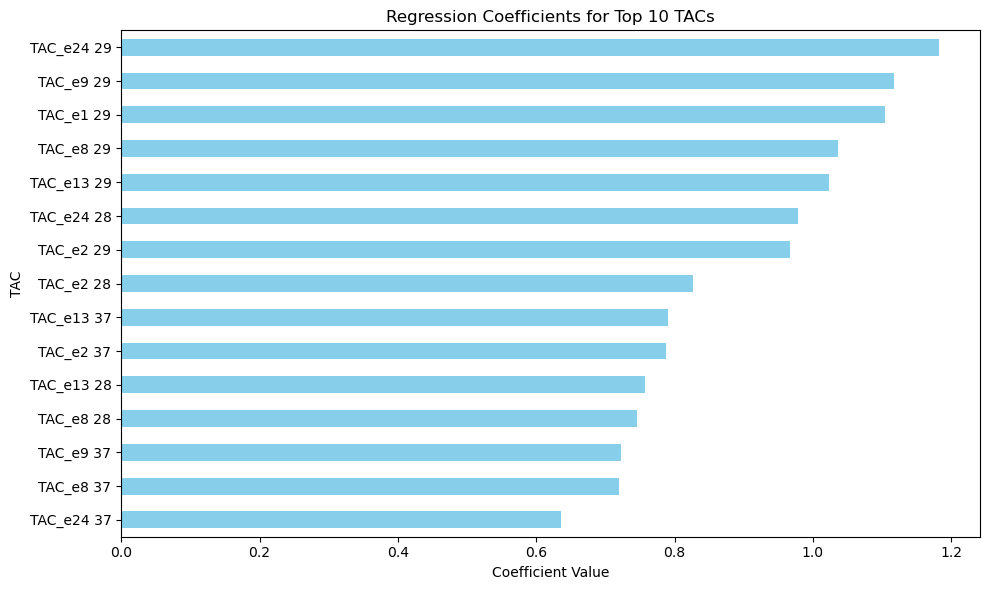


Visualization of regression coefficients completed.

=== Step 11: Creating Histograms of 'Erwltp (g/km)' for Top 10 TACs ===


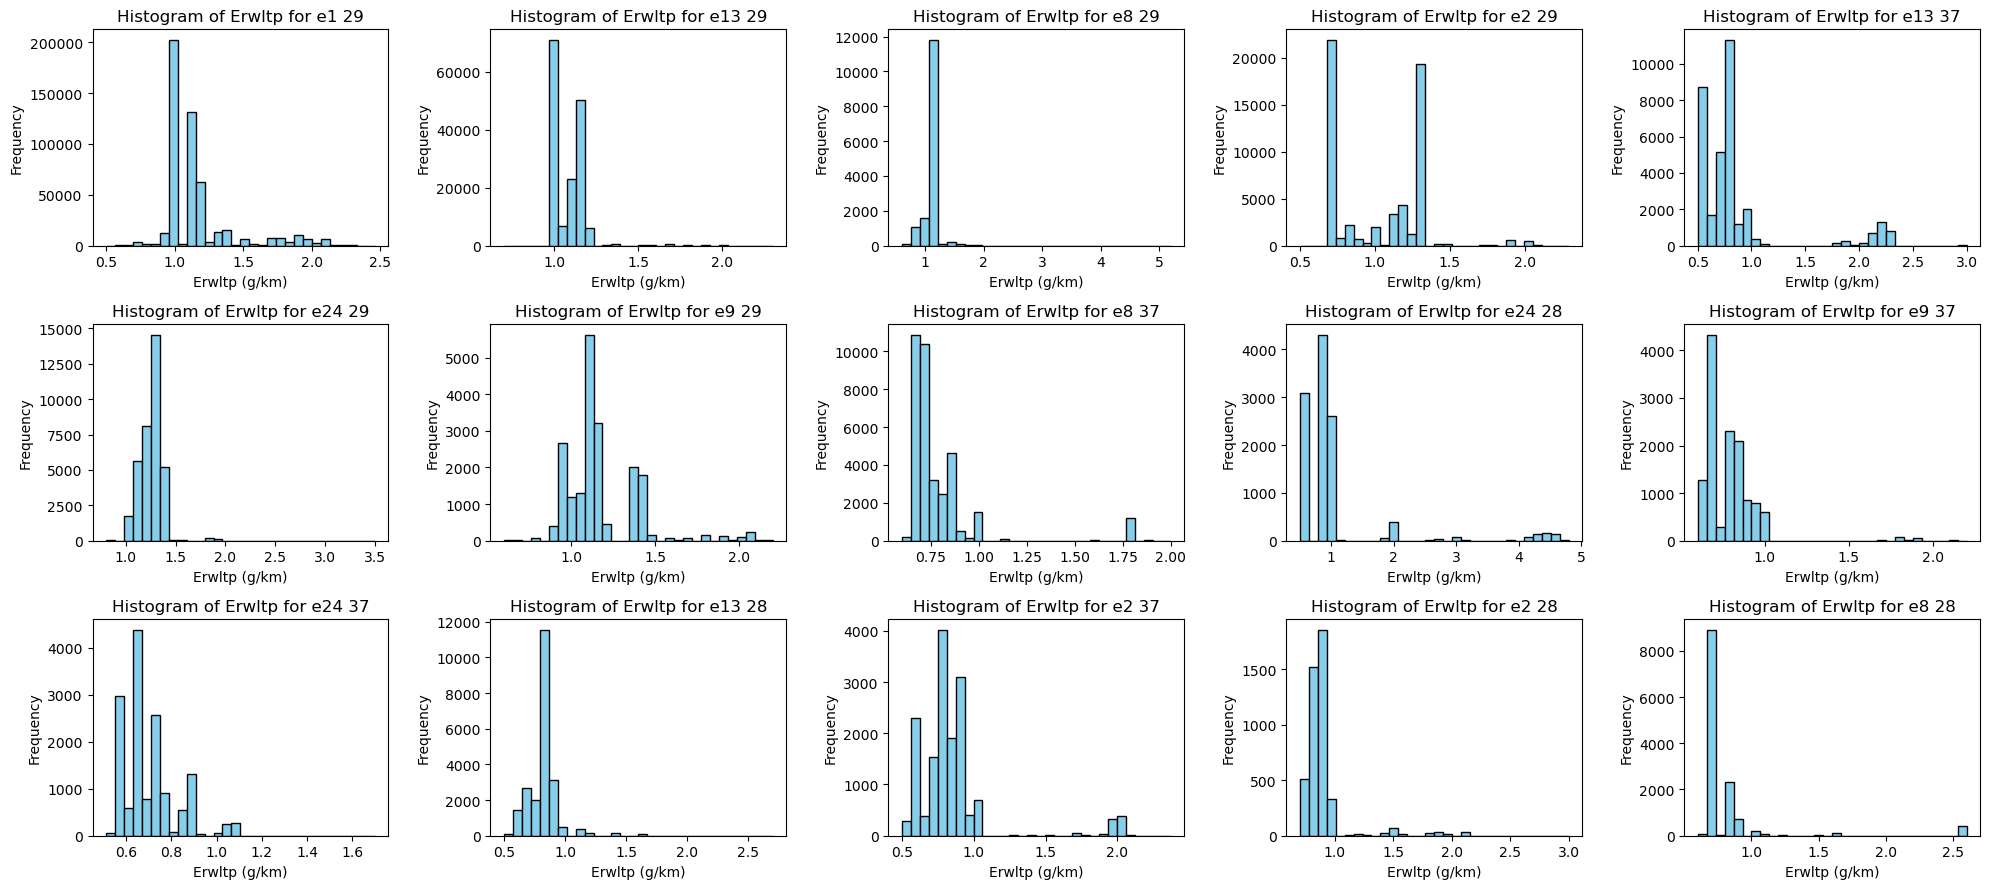

Histograms of 'Erwltp (g/km)' for top 10 TACs have been created.



In [ ]:
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm  # Importing statsmodels
import matplotlib.pyplot as plt

# --- Step 0: Initial Data Preparation ---

# Assuming 'df' is your existing DataFrame and 'TACs_wltp' is a DataFrame containing valid TACs
# Ensure 'IT_valid', 'year', and 'Erwltp (g/km)' columns exist
required_columns = ['IT_valid', 'year', 'Erwltp (g/km)']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the DataFrame: {missing_columns}")

# Ensure 'TACs_wltp' DataFrame exists and contains 'TAC' column
if 'TAC' not in TACs_wltp.columns:
    raise ValueError("The 'TACs_wltp' DataFrame must contain a 'TAC' column.")

print("=== Step 0: Initial Data Preparation ===")
print(f"Total rows in the original DataFrame: {df.shape[0]}")
print(f"Columns in the DataFrame: {df.columns.tolist()}\n")

# --- Step 1: Including All Relevant Rows and Handling Missing 'Erwltp (g/km)' ---

print("=== Step 1: Including All Relevant Rows and Handling Missing 'Erwltp (g/km)' ===")

# Filter for rows where year >= 2019
mask_year = df['year'] >= 2019
print(f"Number of rows with year >= 2019: {mask_year.sum()}")

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df_all = df[mask_year].copy()
print(f"Number of rows after filtering for year >= 2019: {df_all.shape[0]}")

# Set 'Erwltp (g/km)' to 0 where it is NA
num_na_emissions = df_all['Erwltp (g/km)'].isna().sum()
print(f"Number of rows with NA 'Erwltp (g/km)' before setting to 0: {num_na_emissions}")

df_all['Erwltp (g/km)'] = df_all['Erwltp (g/km)'].fillna(0)
num_na_emissions_after = df_all['Erwltp (g/km)'].isna().sum()
print(f"Number of rows with NA 'Erwltp (g/km)' after setting to 0: {num_na_emissions_after}\n")

# --- Step 2: Split the 'IT_valid' Column into Individual TAC Columns ---

def split_valid_tacs(series):
    """
    Splits the 'IT_valid' column into 5 separate columns for each TAC (up to 5 TACs).
    Handles missing values properly and ensures categorical dtype is preserved.

    Parameters:
    series (pd.Series): The Series containing the combined TAC codes (categorical).

    Returns:
    pd.DataFrame: A DataFrame with individual TAC columns ('IT_1' to 'IT_5').
    """
    print("Splitting 'IT_valid' column into individual TAC columns...")

    # Convert series from categorical to string for manipulation
    series_str = series.astype(str)

    # Define the regex pattern for valid TACs
    valid_pattern = re.compile(r'e\d{1,2} \d{1,2}')  # Adjust based on your data

    def extract_codes(value):
        if pd.isna(value) or value.lower() in ['nan', 'none', '']:
            return [np.nan] * 5  # Return a list of NaNs for missing or invalid entries
        # Find all valid matches for the pattern
        matches = valid_pattern.findall(value)
        # Pad the list to have exactly 5 elements
        matches += [np.nan] * (5 - len(matches))
        return matches[:5]  # Ensure the list is exactly length 5

    # Apply the extraction function to split the strings into valid components
    split_series = series_str.apply(extract_codes)

    # Convert the list of codes into a DataFrame with 5 columns
    tac_df = pd.DataFrame(split_series.tolist(), columns=[f'IT_{i+1}' for i in range(5)], index=series.index)

    # Convert columns to 'category' dtype
    for col in tac_df.columns:
        tac_df[col] = tac_df[col].astype('category')

    print("Completed splitting TACs into individual columns.")
    print(f"First few rows of TAC columns:\n{tac_df.head()}\n")

    return tac_df

print("=== Step 2: Splitting 'IT_valid' Column ===")

# Check if 'IT_1' to 'IT_5' already exist to avoid duplication
existing_it_columns = [f'IT_{i+1}' for i in range(5)]
if any(col in df_all.columns for col in existing_it_columns):
    print("Existing TAC columns detected. Dropping them to reinitialize.")
    df_all.drop(columns=[col for col in existing_it_columns if col in df_all.columns], inplace=True)

tac_df = split_valid_tacs(df_all['IT_valid'])

# Modification: Exclude TACs not in 'TACs_wltp['TAC']'
valid_tacs = set(TACs_wltp['TAC'])
print(f"Valid TACs based on 'TACs_wltp': {len(valid_tacs)} TACs")

# Replace TACs not in 'valid_tacs' with NaN
tac_columns = ['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']
for col in tac_columns:
    df_all[col] = tac_df[col].where(tac_df[col].isin(valid_tacs), np.nan)

print("Excluded TACs not present in 'TACs_wltp'.")
print(f"First few rows after excluding invalid TACs:\n{df_all[tac_columns].head()}\n")

# Concatenate the new columns back to the DataFrame
# (Already updated df_all with filtered TACs)

# --- Step 3: Count Unique TACs Across All IT Columns ---

def count_unique_tacs(df):
    """
    Counts the unique TACs across the 'IT_1' to 'IT_5' columns.
    Returns a pandas Series with TACs as index and their counts as values.
    """
    print("Counting unique TACs across all IT columns...")

    # Specify the TAC columns
    tac_columns = ['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']

    # Concatenate the TAC columns into a single Series
    combined_tacs = pd.concat([df[col] for col in tac_columns], axis=0, ignore_index=True)

    # Drop NaN values
    combined_tacs = combined_tacs.dropna()

    # Count the unique TACs
    tac_counts = combined_tacs.value_counts()

    print(f"Total unique TACs found: {tac_counts.shape[0]}")
    print(f"Top 10 most common TACs:\n{tac_counts.head(10)}\n")

    return tac_counts

print("=== Step 3: Counting Unique TACs ===")
tac_counts = count_unique_tacs(df_all)

# --- Step 4: Identify Top 10 Most Common TACs ---

print("=== Step 4: Identifying Top n TACs ===")
top_10_tacs = tac_counts.head(15).index.tolist()
print(f"Top 10 TACs: {top_10_tacs}\n")

# --- Step 5: One-Hot Encode the Top 10 TACs ---

print("=== Step 5: One-Hot Encoding Top 10 TACs ===")

# Define the TAC columns
tac_columns = ['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']

# Stack the IT columns into a single Series
it_combined = df_all[tac_columns].stack().reset_index(level=1, drop=True)

# Filter the Series to include only the top 10 TACs
it_combined_top10 = it_combined[it_combined.isin(top_10_tacs)]
print(f"Total TAC entries after stacking and filtering: {it_combined_top10.shape[0]}")

# One-hot encode the top 10 TACs
it_dummies = pd.get_dummies(it_combined_top10, prefix='TAC')

# Sum the one-hot encodings for each original row
it_dummies = it_dummies.groupby(it_dummies.index).sum()
print(f"Shape of the one-hot encoded TAC DataFrame: {it_dummies.shape}")

# Reindex the dummy DataFrame to match df_all
it_dummies = it_dummies.reindex(df_all.index, fill_value=0)

# Concatenate the one-hot encoded TACs with df_all
# Before concatenating, remove existing one-hot encoded TAC columns if they exist to avoid duplication
existing_dummy_columns = [col for col in it_dummies.columns if col in df_all.columns]
if existing_dummy_columns:
    print(f"Existing one-hot encoded TAC columns detected: {existing_dummy_columns}. Dropping them to reinitialize.")
    df_all.drop(columns=existing_dummy_columns, inplace=True)

df_all = pd.concat([df_all, it_dummies], axis=1)
print("One-hot encoding completed.\n")

# --- Step 6: Select Rows with Either No TACs or Exactly One TAC (Only IT_1) ---

print("=== Step 6: Selecting Relevant Rows for Regression ===")

# Condition 1: All IT columns are NaN (No TACs)
condition_no_tac = df_all[tac_columns].isna().all(axis=1)

# Condition 2: Only IT_1 has a value, and IT_2 to IT_5 are NaN
condition_one_tac = df_all['IT_1'].notna() & df_all[['IT_2', 'IT_3', 'IT_4', 'IT_5']].isna().all(axis=1)

# Combined condition
mask_relevant = condition_no_tac | condition_one_tac

print(f"Number of rows with no TACs: {condition_no_tac.sum()}")
print(f"Number of rows with exactly one TAC (only IT_1): {condition_one_tac.sum()}")

# Modification: Exclude rows where IT_1 has a TAC but 'Erwltp (g/km)' is zero
condition_it1_no_erwltp = (df_all['IT_1'].notna()) & (df_all['Erwltp (g/km)'] == 0)
print(f"Number of rows with IT_1 TAC but 'Erwltp (g/km)' is zero: {condition_it1_no_erwltp.sum()}")

# Update the mask to exclude these rows
mask_relevant = mask_relevant & (~condition_it1_no_erwltp)

print(f"Total rows selected for regression after exclusion: {mask_relevant.sum()}\n")

# Filter the DataFrame
df_relevant = df_all[mask_relevant].copy()
print("Filtered DataFrame for regression created.\n")

# --- Step 7: Prepare for Regression ---

print("=== Step 7: Preparing for Regression ===")

# Define the target variable
target_variable = 'Erwltp (g/km)'  # Updated target variable name

# Check if the target variable exists
if target_variable not in df_relevant.columns:
    raise ValueError(f"The target variable '{target_variable}' is not in the DataFrame.")

print(f"Target variable: {target_variable}")

# List of one-hot encoded TAC columns
feature_columns = it_dummies.columns.tolist()
print(f"Feature columns (one-hot encoded TACs): {feature_columns}\n")

# Extract features and target variable
X = df_relevant[feature_columns]
y = df_relevant[target_variable]

# Handle missing values in the target variable (already set to 0)
# Ensure alignment between X and y
print(f"Number of missing values in target variable '{target_variable}': {y.isna().sum()}")

# Since we've set NA to 0 and filtered rows, no further action is needed
if y.isna().sum() > 0:
    print("There are still missing values in the target variable. Dropping these rows.")
    y = y.dropna()
    X = X.loc[y.index]
else:
    print("No missing values in the target variable.\n")

# Add a constant term to the predictors for the intercept
X = sm.add_constant(X)
print("Data prepared for regression.\n")

# --- Step 8: Perform Regression ---

print("=== Step 8: Performing Regression ===")

# Fit the Ordinary Least Squares (OLS) regression model
model = sm.OLS(y, X).fit()

print("Regression completed.\n")

# --- Step 9: Print the Regression Results ---

print("=== Step 9: Regression Results ===")
print(model.summary())

# --- Step 10: Visualize Regression Coefficients ---

print("=== Step 10: Visualizing Regression Coefficients ===")

# Extract coefficients excluding the intercept
coefficients = model.params.drop('const') if 'const' in model.params else model.params

# Sort coefficients for better visualization
coefficients_sorted = coefficients.sort_values()

plt.figure(figsize=(10, 6))
coefficients_sorted.plot(kind='barh', color='skyblue')
plt.title('Regression Coefficients for Top 10 TACs')
plt.xlabel('Coefficient Value')
plt.ylabel('TAC')
plt.tight_layout()
plt.show()

print("\nVisualization of regression coefficients completed.\n")

# --- Step 11: Create Histograms of 'Erwltp (g/km)' for Top 10 TACs ---

print("=== Step 11: Creating Histograms of 'Erwltp (g/km)' for Top 10 TACs ===")

# Create a directory to save histograms if desired
import os
hist_dir = 'histograms'
if not os.path.exists(hist_dir):
    os.makedirs(hist_dir)

# Iterate through each top 10 TAC and plot histograms
num_tacs = len(top_10_tacs)
cols = 5  # Number of columns in the subplot grid
rows = num_tacs // cols + int(num_tacs % cols != 0)

plt.figure(figsize=(cols*4, rows*3))  # Adjust figure size as needed

for i, tac in enumerate(top_10_tacs, 1):
    tac_column = f'TAC_{tac}'
    if tac_column not in df_relevant.columns:
        print(f"Column {tac_column} not found in DataFrame. Skipping.")
        continue
    # Select 'Erwltp (g/km)' values for this TAC
    erwltp_values = df_relevant[df_relevant[tac_column] == 1]['Erwltp (g/km)']

    plt.subplot(rows, cols, i)
    plt.hist(erwltp_values, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of Erwltp for {tac}')
    plt.xlabel('Erwltp (g/km)')
    plt.ylabel('Frequency')

    # Optionally, save each histogram as an image
    # plt.savefig(os.path.join(hist_dir, f'histogram_{tac}.png'))

plt.tight_layout()
plt.show()

print("Histograms of 'Erwltp (g/km)' for top 10 TACs have been created.\n")


#### f: count_unique_tacs

In [ ]:
def count_unique_tacs(df):
    """
    Counts the unique TACs across the 'IT_1' to 'IT_5' columns.
    Returns a pandas Series with TACs as index and their counts as values.
    """
    print("Counting unique TACs across all IT columns...")

    # Specify the TAC columns
    tac_columns = ['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']

    # Concatenate the TAC columns into a single Series
    combined_tacs = pd.concat([df[col] for col in tac_columns], axis=0, ignore_index=True)

    # Drop NaN values
    combined_tacs = combined_tacs.dropna()

    # Count the unique TACs
    tac_counts = combined_tacs.value_counts()

    print(f"Total unique TACs found: {tac_counts.shape[0]}")
    print(f"Top 10 most common TACs:\n{tac_counts.head(10)}\n")

    return tac_counts

count_unique_tacs(df)

Counting unique TACs across all IT columns...
Total unique TACs found: 227
Top 10 most common TACs:
e1 29     648765
e13 29    452771
e8 29     325121
e24 19    291306
e2 29     289305
e13 37    285698
e24 29    276484
e24 17    259262
e9 29     245885
e8 37     244373
dtype: int64



e1 29     648765
e13 29    452771
e8 29     325121
e24 19    291306
e2 29     289305
           ...  
e5 1           1
e6 14          1
e8 1           1
e5 7           1
e14 28         1
Length: 227, dtype: int64

# **=== save/read (shared Okt 23)===**

In [ ]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT_split.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT_split.parquet")
#all_to_nan_and_cat(df, ['IT_valid', 'IT_invalid', 'IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5'])
#print(count_missing_values2(df, ['IT_valid', 'IT_invalid', 'IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']))

In [ ]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Okt_23.parquet")

In [2]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Okt_23.parquet")

## **Inspect categories**

In [ ]:
# Again, inspect the unique categories in each categorical column
for col in df.select_dtypes(include=['category']):
    num_categories = df[col].nunique(dropna=True)
    print(f"Column '{col}' has {num_categories} unique categorical values.")

Column 'Country' has 30 unique categorical values.
Column 'VFN' has 29048 unique categorical values.
Column 'Mp' has 27 unique categorical values.
Column 'Mh' has 218 unique categorical values.
Column 'Man' has 477 unique categorical values.
Column 'MMS' has 11561 unique categorical values.
Column 'Tan' has 49909 unique categorical values.
Column 'T' has 26611 unique categorical values.
Column 'Va' has 72533 unique categorical values.
Column 'Ve' has 182640 unique categorical values.
Column 'Mk' has 1745 unique categorical values.
Column 'Cn' has 80814 unique categorical values.
Column 'Ct' has 9 unique categorical values.
Column 'Cr' has 2 unique categorical values.
Column 'Ft' has 11 unique categorical values.
Column 'Fm' has 6 unique categorical values.
Column 'IT' has 1928 unique categorical values.
Column 'Status' has 1 unique categorical values.
Column 'Date of registration' has 1095 unique categorical values.
Column 'ech' has 36 unique categorical values.
Column 'RLFI' has 1544 

In [1]:
import numpy as np
import pandas as pd

import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from utils_CO2 import *

# set option so that e.g. df.head() will show all columns and none are omitted
pd.set_option('display.max_columns', None)

In [ ]:
# Dem Andreas seine spezielle Ladezeile
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Okt_23.parquet")

# 1.M Summary Pipeline Part 2
All functions can be seen with description in the utils_co2.py function conglomeration
This will be done in the summary of data treatment
- taking the dataframe coming from renaming/mapping categories above
- drop rows without target values
- declare and drop irrelevant columns
- filter df by year (default everything after 2018)
+ Identify electric cars
+ identify electric (or hybrid) cars by looking at electric range and electric capacity
+ making separate column whichs marks the non electric cars
+ fill then all the nan values in electri range and electric capacity with 0 (because they have non, which is equal to 0)
- Outlier handling
- Outlier handling function (IQR factor ab dem als Outlier gewertet wird)
- Zusätzlich in die Funktion: ersetzen durch median oder row delete
+ give to the next steps

In [ ]:
# Load data
df = load_data_local('EU_all_current_shared_Okt_23.parquet')

Loading parquet file from local path: c:\Users\onepl\Desktop\Finanzen Behörden etc - Copy\Bewerbung\Fortbildungen\DS Bootcamp\Project Co2 git\aug24_bds_int---co2\data\EU\EU_all_current_shared_Okt_23.parquet


In [ ]:
inspect_data(df)

In [3]:
################################################    Declare columns to delete    #################################################
# Global lists of columns to be dropped (default)
car_identifiers = ['Ve', 'Va', 'T', 'Tan', 'ID', 'tvv']
administrative_values = ['Date of registration', 'Status', 'Dr', 'Vf', 'De']
data_related_columns = ['r', 'R', '#identical occurences', 'Version_file']
brand_related = ['Mp', 'Man', 'MMS']
temporary_or_transformed = ['IT', 'IT_valid', 'IT_invalid', 'Ernedc (g/km)', 'Non_Electric_Car']
correlated_with_target = ['Enedc (g/km)', 'Erwltp (g/km)', 'Fuel consumption ', 'E (g/km)', 'Er (g/km)'] 
# collinear_attributes = ['m (kg)', 'At2 (mm)']
others = ['Cr', 'ech', 'RLFI', 'Electric range (km)', 'z (Wh/km)', 'year']

# Additional columns to be dropped (individual)
individual = ['Mk', 'Country', 'Cn', 'VFN']

# Combine all columns into one list
list_of_columns_to_drop = (car_identifiers + administrative_values +
                   data_related_columns + brand_related +
                   correlated_with_target + temporary_or_transformed + others
                   + individual)
##################################################################################################################################

################################################    Declare columns as gaussian for outlier handling    ##########################
# Declare gaussian and non gaussian distributed columns
gaussian_cols = ['m (kg)', 'Mt',  'W (mm)', 'At1 (mm)', 'At2 (mm)']
non_gaussian_cols = [ 'ec (cm3)', 'ep (KW)']
##################################################################################################################################

In [4]:

# Drop rows where all values in 'Ewltp (g/km)' are NaN
df = drop_rows_without_target(df, target='Ewltp (g/km)')

# Make electric car column and replace nans with 0s in electric range&capacity column
df = process_electric_car_data(df, replace_nan=False, make_electric_car_column=True)
# Drop all electric
df = df[df['Non_Electric_Car'] == 'True']

# Filter data frame for cars and entries which are younger than 2018
df = filter_dataframe_by_year(df, year=2019)

# Drop everything except top 3 countries
df = df[df['Country'].isin(['DE', 'FR', 'IT'])]
print("Dropped all but top 3 countries (DE, FR, IT)")

# Drop columns with function
df = drop_irrelevant_columns(df, list_of_columns_to_drop)

# Outlier handling
# Replacement with median for gaussian like numerical distributions
df = replace_outliers_with_median(df, columns=gaussian_cols, IQR_distance_multiplier=1.5, apply_outlier_removal=True)
# Removal of outlier data if variable is non gaussian distributed
df = iqr_outlier_removal(df, columns=non_gaussian_cols, IQR_distance_multiplier=1.5, apply_outlier_removal=True)

Dropped all but top 3 countries (DE, FR, IT)
Dropped columns: ['Ve', 'Va', 'T', 'Tan', 'ID', 'tvv', 'Date of registration', 'Status', 'Vf', 'De', 'r', '#identical occurences', 'Mp', 'Man', 'MMS', 'Enedc (g/km)', 'Erwltp (g/km)', 'Fuel consumption ', 'IT', 'IT_valid', 'IT_invalid', 'Ernedc (g/km)', 'Non_Electric_Car', 'Cr', 'ech', 'RLFI', 'Electric range (km)', 'z (Wh/km)', 'year', 'Mk', 'Country', 'Cn', 'VFN']
Index(['Mh', 'Ct', 'm (kg)', 'Mt', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)',
       'At2 (mm)', 'Ft', 'Fm', 'ec (cm3)', 'ep (KW)', 'IT_1', 'IT_2', 'IT_3',
       'IT_4', 'IT_5'],
      dtype='object')
Replaced 72913 outliers in column 'm (kg)' with median value 1591.0.
Replaced 123267 outliers in column 'Mt' with median value 1733.0.
Replaced 142114 outliers in column 'W (mm)' with median value 2710.0.
Replaced 85217 outliers in column 'At1 (mm)' with median value 1569.0.
Replaced 96719 outliers in column 'At2 (mm)' with median value 1575.0.
DataFrame shape after replacing outliers i

### save

In [ ]:
# Saving file in the repository data folder
save_data(df, file_name = 'Data_Preprocessed_after_M.parquet')

In [5]:
df.to_parquet("..\\data\\EU\\Data_Preprocessed_after_M.parquet")

In [2]:
df = pd.read_parquet("..\\data\\EU\\Data_Preprocessed_minimal_with_fuel_consumption.parquet")

# 1.N Category Selection

#### generate category list

In [ ]:
generate_category_lists(df, max_categories=20, min_cat_percent=10, top_n=5)

# For variable 'Mh', the top 20 categories are displayed based on their value_counts:
# 'VOLKSWAGEN': 789301, 'BMW AG': 723673, 'MERCEDES-BENZ AG': 671403, 'AUDI AG': 579785, 'SKODA': 334917, 'FORD WERKE GMBH': 242485, 'SEAT': 191332, 'RENAULT': 130460, 'PSA': 127805, 'OPEL AUTOMOBILE': 124876, 'AUTOMOBILES PEUGEOT': 93215, 'VOLVO': 86865, 'PORSCHE': 78453, 'JAGUAR LAND ROVER LIMITED': 70811, 'FIAT GROUP': 67796, 'AUTOMOBILES CITROEN': 52733, 'AA-IVA': 33387, 'STELLANTIS EUROPE': 29971, 'TOYOTA': 26112, 'DACIA': 23646
# Please choose which categories to include or adjust the 'top_n' and 'min_cat_percent' parameters.
# ['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA', 'FORD WERKE GMBH', 'SEAT', 'RENAULT', 'PSA', 'OPEL AUTOMOBILE', 'AUTOMOBILES PEUGEOT', 'VOLVO', 'PORSCHE', 'JAGUAR LAND ROVER LIMITED', 'FIAT GROUP', 'AUTOMOBILES CITROEN', 'AA-IVA', 'STELLANTIS EUROPE', 'TOYOTA', 'DACIA']
# Note: If both `top_n` and `categories_to_keep` are provided, `categories_to_keep` wi

#### select categories

In [ ]:
# For variable 'Mh', the top 20 categories are displayed based on their value_counts:
# 'VOLKSWAGEN': 789301, 'BMW AG': 723673, 'MERCEDES-BENZ AG': 671403, 'AUDI AG': 579785, 'SKODA': 334917, 'FORD WERKE GMBH': 242485, 'SEAT': 191332, 'RENAULT': 130460, 'PSA': 127805, 'OPEL AUTOMOBILE': 124876, 'AUTOMOBILES PEUGEOT': 93215, 'VOLVO': 86865, 'PORSCHE': 78453, 'JAGUAR LAND ROVER LIMITED': 70811, 'FIAT GROUP': 67796, 'AUTOMOBILES CITROEN': 52733, 'AA-IVA': 33387, 'STELLANTIS EUROPE': 29971, 'TOYOTA': 26112, 'DACIA': 23646
# Please choose which categories to include or adjust the 'top_n' and 'min_cat_percent' parameters.
# ['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA', 'FORD WERKE GMBH', 'SEAT', 'RENAULT', 'PSA', 'OPEL AUTOMOBILE', 'AUTOMOBILES PEUGEOT', 'VOLVO', 'PORSCHE', 'JAGUAR LAND ROVER LIMITED', 'FIAT GROUP', 'AUTOMOBILES CITROEN', 'AA-IVA', 'STELLANTIS EUROPE', 'TOYOTA', 'DACIA']
# Note: If both `top_n` and `categories_to_keep` are provided, `categories_to_keep` will be ignored.
# If drop = True, rows will be dropped; otherwise, they will be labeled as 'Other'.
df = filter_categories(df, 'Mh', drop=False, top_n=5, categories_to_keep=['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA', 'FORD WERKE GMBH', 'SEAT', 'RENAULT', 'PSA', 'OPEL AUTOMOBILE', 'AUTOMOBILES PEUGEOT', 'VOLVO', 'PORSCHE', 'JAGUAR LAND ROVER LIMITED', 'FIAT GROUP', 'AUTOMOBILES CITROEN', 'AA-IVA', 'STELLANTIS EUROPE', 'TOYOTA', 'DACIA'], other_label='Other', min_cat_percent=10)

# For variable 'Ct', these are the categories available and their respective value_counts:
# 'M1': 4259289, 'M1G': 417875, 'N1': 533, 'N2': 35, 'N1G': 24, 'N2G': 4, 'N3': 4, 'M2': 0, 'N3G': 0
# Please choose which categories to include or adjust the 'top_n' and 'min_cat_percent' parameters.
# ['M1', 'M1G', 'N1', 'N2', 'N1G', 'N2G', 'N3', 'M2', 'N3G']
# Note: If both `top_n` and `categories_to_keep` are provided, `categories_to_keep` will be ignored.
# If drop = True, rows will be dropped; otherwise, they will be labeled as 'Other'.
df = filter_categories(df, 'Ct', drop=False, top_n=5, categories_to_keep=['M1', 'M1G', 'N1', 'N2'], other_label='Other', min_cat_percent=10)

# For variable 'Ft', these are the categories available and their respective value_counts:
# 'DIESEL': 2320878, 'PETROL': 2293843, 'PETROL/ELECTRIC': 21728, 'NG-BIOMETHANE': 18156, 'LPG': 8898, 'E85': 5873, 'ELECTRIC': 5566, 'DIESEL/ELECTRIC': 5241, 'HYDROGEN': 70, 'BIODIESEL': 0, 'OTHER': 0
# Please choose which categories to include or adjust the 'top_n' and 'min_cat_percent' parameters.
# ['DIESEL', 'PETROL', 'PETROL/ELECTRIC', 'NG-BIOMETHANE', 'LPG', 'E85', 'ELECTRIC', 'DIESEL/ELECTRIC', 'HYDROGEN', 'BIODIESEL', 'OTHER']
# Note: If both `top_n` and `categories_to_keep` are provided, `categories_to_keep` will be ignored.
# If drop = True, rows will be dropped; otherwise, they will be labeled as 'Other'.
df = filter_categories(df, 'Ft', drop=True, top_n=5, categories_to_keep=['DIESEL', 'PETROL', 'NG-BIOMETHANE', 'LPG', 'E85', 'HYDROGEN', 'BIODIESEL', 'OTHER'], other_label='Other', min_cat_percent=10)

# For variable 'Fm', these are the categories available and their respective value_counts:
# 'M': 3881690, 'H': 755160, 'P': 26970, 'B': 9835, 'E': 5566, 'F': 1033
# Please choose which categories to include or adjust the 'top_n' and 'min_cat_percent' parameters.
# ['M', 'H', 'P', 'B', 'E', 'F']
# Note: If both `top_n` and `categories_to_keep` are provided, `categories_to_keep` will be ignored.
# If drop = True, rows will be dropped; otherwise, they will be labeled as 'Other'.
df = filter_categories(df, 'Fm', drop=False, top_n=5, categories_to_keep=['M', 'H', 'P', 'B', 'E', 'F'], other_label='Other', min_cat_percent=10)

# Handling IT columns: ['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']
# Aggregating IT codes across IT_1 to IT_5 and listing the top categories:
# 'e1 29': 450239, 'e13 29': 292380, 'e13 37': 181449, 'e24 29': 175265, 'e24 17': 168087, 'e24 19': 163279, 'e2 29': 145153, 'e8 29': 144732, 'e24 28': 130765, 'e9 29': 125027, 'e1 2': 118521, 'e8 37': 102146, 'e13 19': 99698, 'e24 3': 97498, 'e24 37': 95575, 'e13 28': 91373, 'e2 17': 90679, 'e13 17': 85774, 'e9 37': 77894, 'e8 19': 74383
# Please choose the number of top ITs to retain and adjust the 'top_n' and 'min_cat_percent' parameters in the function call.
# Current top 20 ITs:
# ['e1 29', 'e13 29', 'e13 37', 'e24 29', 'e24 17', 'e24 19', 'e2 29', 'e8 29', 'e24 28', 'e9 29', 'e1 2', 'e8 37', 'e13 19', 'e24 3', 'e24 37', 'e13 28', 'e2 17', 'e13 17', 'e9 37', 'e8 19']
df = retain_top_n_ITs(df, top_n=5, IT_columns=['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5'], other_label='Other', min_cat_percent=10)

Top categories meeting the threshold: ['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG']
Replaced 1916084 values in 'Mh' with 'Other' where not in specified categories or occur less than 10% of total rows.
Top categories meeting the threshold: ['M1']
Replaced 418475 values in 'Ct' with 'Other' where not in specified categories or occur less than 10% of total rows.
Top categories meeting the threshold: ['DIESEL', 'PETROL']
Dropped 65532 rows where 'Ft' is not in the specified categories or occur less than 10% of total rows.
Top categories meeting the threshold: ['M', 'H']
Replaced 1 values in 'Fm' with 'Other' where not in specified categories or occur less than 10% of total rows.
Retaining top 5 ITs that occur more than 10% and labeling others as 'Other'...
Top ITs meeting the threshold: ['e1 29']
Updated 'IT_1' categories: ['Other', 'e1 29']
Updated 'IT_2' categories: ['Other', 'e1 29']
Updated 'IT_3' categories: ['Other', 'e1 29']
Updated 'IT_4' categories: ['Other']
Updated 'IT

# 1.P NaN Handling

#### explore

In [6]:
count_missing_values(df)

,Dtype,Missing Count,Percent Missing
Mh,category,13,0.00%
Ct,category,2495,0.05%
m (kg),float32,23,0.00%
Mt,float32,79117,1.69%
Ewltp (g/km),float32,0,0.00%
W (mm),float32,753911,16.11%
At1 (mm),float32,880244,18.81%
At2 (mm),float32,881190,18.83%
Ft,category,6,0.00%
Fm,category,5,0.00%


#### generate nan-handling dictionary

In [3]:
nan_handling_strategy = generate_strategy_dict_code(df, default_strategy='drop', special_columns=None)
print(nan_handling_strategy)

nan_handling_strategy = {
    'Mh': 'drop',
    'Ct': 'drop',
    'm (kg)': 'drop',
    'Mt': 'drop',
    'Ewltp (g/km)': 'drop',
    'W (mm)': 'drop',
    'At1 (mm)': 'drop',
    'At2 (mm)': 'drop',
    'Ft': 'drop',
    'Fm': 'drop',
    'ec (cm3)': 'drop',
    'ep (KW)': 'drop',
    'IT_1': 'leave_as_nan',
    'IT_2': 'leave_as_nan',
    'IT_3': 'leave_as_nan',
    'IT_4': 'leave_as_nan',
    'IT_5': 'leave_as_nan',
}


In [2]:
df = pd.read_parquet("..\\data\\Preprocessed\\intermediate\\Data_Preprocessed_after_M_minimal_without_fuel_consumption.parquet")

#### choose nan-nandling per column

In [4]:
# Possible strategies can be 'drop', 'mean', 'median', 'mode', 'zero', or 'leave_as_nan'

nan_handling_strategy = {
    'Mh': 'drop',
    'Ct': 'drop',
    'm (kg)': 'drop',
    'Mt': 'drop',
    'Ewltp (g/km)': 'drop',
    'W (mm)': 'drop',
    'At1 (mm)': 'drop',
    'At2 (mm)': 'drop',
    'Ft': 'drop',
    'Fm': 'drop',
    'ec (cm3)': 'drop',
    'ep (KW)': 'drop',
    'IT_1': 'leave_as_nan',
    'IT_2': 'leave_as_nan',
    'IT_3': 'leave_as_nan',
    'IT_4': 'leave_as_nan',
    'IT_5': 'leave_as_nan',
}

#### handle NaNs (execute)

In [ ]:
df = handle_nans(df, nan_handling_strategy)

#### (optional) separate treatment of Erwltp and Ernedc (only if in df)

In [ ]:
# df = handle_nans_IT_related_columns(df, ['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5'], target_columns = ['Erwltp (g/km)', 'Ernedc (g/km)'] , strategy='mean')

# 1.Q encode categorical columns

### explore

In [ ]:
# count unique IT values
count_unique_it_codes(df)

### encode (execute)

In [ ]:
# one hot-encode all categorical data
df = encode_categorical_columns(df, exclude_prefix='IT_') # Encode all present categorical values (exclucing IT)
df = encode_top_its(df, n=0)  # Encode all present IT values

# 1. R Save Dataframe

In [ ]:
# Saving file in the repository data folder
save_data(df, file_name = 'Data_Preprocessed_finished.parquet')

# 1.W Summary Pipeline Part 3 (N-R)

In [ ]:
df = load_data_local('Data_Preprocessed_after_M.parquet')
#df = pd.read_parquet("..\\data\\EU\\Data_Preprocessed_after_M.parquet")

df = filter_categories(df, 'Mh', drop=False, top_n=5, categories_to_keep=['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA', 'FORD WERKE GMBH', 'SEAT', 'RENAULT', 'PSA', 'OPEL AUTOMOBILE', 'AUTOMOBILES PEUGEOT', 'VOLVO', 'PORSCHE', 'JAGUAR LAND ROVER LIMITED', 'FIAT GROUP', 'AUTOMOBILES CITROEN', 'AA-IVA', 'STELLANTIS EUROPE', 'TOYOTA', 'DACIA'], other_label='Other', min_cat_percent=10)
df = filter_categories(df, 'Ct', drop=False, top_n=5, categories_to_keep=['M1', 'M1G', 'N1', 'N2'], other_label='Other', min_cat_percent=10)
df = filter_categories(df, 'Ft', drop=True, top_n=5, categories_to_keep=['DIESEL', 'PETROL', 'NG-BIOMETHANE', 'LPG', 'E85', 'HYDROGEN', 'BIODIESEL', 'OTHER'], other_label='Other', min_cat_percent=10)
df = filter_categories(df, 'Fm', drop=False, top_n=5, categories_to_keep=['M', 'H', 'P', 'B', 'E', 'F'], other_label='Other', min_cat_percent=10)
df = retain_top_n_ITs(df, top_n=5, IT_columns=['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5'], other_label='Other', min_cat_percent=10)

df = handle_nans(df, nan_handling_strategy)
df = encode_categorical_columns(df, exclude_prefix='IT_')
df = encode_top_its(df, n=0) # parameter n=0 --> encode all present IT values

save_data(df, file_name = 'Data_Preprocessed_finished.parquet')
# df.to_parquet("..\\data\\EU\\Data_Preprocessed_finished.parquet")

# 1. X Batch process and save multiple Datasets

### define batch processing function 

In [5]:
# Batch process and save Datasets

def process_datasets(prefix, top_n_list=[5, 10, 15, 20], min_cat_percent_list=[0.1, 1, 5, 10], drop_dupes=True, nan_handling_strategy = nan_handling_strategy):
    # Define the constant parameters
    categories_to_keep_Mh = ['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA', 
                             'FORD WERKE GMBH', 'SEAT', 'RENAULT', 'PSA', 'OPEL AUTOMOBILE', 
                             'AUTOMOBILES PEUGEOT', 'VOLVO', 'PORSCHE', 'JAGUAR LAND ROVER LIMITED', 
                             'FIAT GROUP', 'AUTOMOBILES CITROEN', 'AA-IVA', 'STELLANTIS EUROPE', 
                             'TOYOTA', 'DACIA']
    categories_to_keep_Ct = ['M1', 'M1G', 'N1', 'N2']
    categories_to_keep_Ft = ['DIESEL', 'PETROL', 'NG-BIOMETHANE', 'LPG', 'E85', 
                             'HYDROGEN', 'BIODIESEL', 'OTHER']
    categories_to_keep_Fm = ['M', 'H', 'P', 'B', 'E', 'F']
    IT_columns = ['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']
    
    filename_list = []
        
    for top_n in top_n_list:
        for min_cat_percent in min_cat_percent_list:
            # Load the DataFrame
            df = pd.read_parquet("..\\data\\Preprocessed\\intermediate\\Data_Preprocessed_after_M_minimal_without_fuel_consumption.parquet")
            
            # Create a filename that reflects the parameters
            filename = f"{prefix}_tn{top_n:02d}_mcp{min_cat_percent:05.2f}.parquet"
            filename_list.append(filename)
            
            print(f"Processing file {filename}")
            print("=======================\n")
            
            # Apply the transformations with current top_n and min_cat_percent
            df = filter_categories(df, 'Mh', drop=False, top_n=top_n, categories_to_keep=categories_to_keep_Mh, other_label='Other', min_cat_percent=min_cat_percent)
            df = filter_categories(df, 'Ct', drop=False, top_n=top_n, categories_to_keep=categories_to_keep_Ct, other_label='Other', min_cat_percent=min_cat_percent)
            df = filter_categories(df, 'Ft', drop=True, top_n=top_n, categories_to_keep=categories_to_keep_Ft, other_label='Other', min_cat_percent=min_cat_percent)
            df = filter_categories(df, 'Fm', drop=False, top_n=top_n, categories_to_keep=categories_to_keep_Fm, other_label='Other', min_cat_percent=min_cat_percent)
            df = retain_top_n_ITs(df, top_n=top_n, IT_columns=IT_columns, other_label='Other', min_cat_percent=min_cat_percent)
            
            df = handle_nans(df, nan_handling_strategy)
            df = encode_categorical_columns(df, exclude_prefix='IT_', drop_first=True)
            df = encode_top_its(df, n=0)  # Encode all present IT values
            df = drop_duplicates(df, drop=drop_dupes, subset=None)
            
            #print("=======================\n")
            
            # Save the DataFrame
            df.to_parquet(filename)
            
    return filename_list


### execute batch processing


In [6]:
filename_list = process_datasets(prefix = 'minimal_without_fuel_consumption', top_n_list=[5, 10, 15, 20], min_cat_percent_list=[0.1, 1, 5, 10], nan_handling_strategy = nan_handling_strategy)

Processing file minimal_without_fuel_consumption_tn05_mcp00.10.parquet

Categories to keep after applying thresholds: ['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA']
Replaced 1581167 values in 'Mh' with 'Other' where not in specified categories or occur less than 0.1% of total rows.
Categories to keep after applying thresholds: ['M1', 'M1G']
Replaced 600 values in 'Ct' with 'Other' where not in specified categories or occur less than 0.1% of total rows.
Categories to keep after applying thresholds: ['DIESEL', 'PETROL', 'NG-BIOMETHANE', 'LPG', 'E85']
Dropped 32605 rows where 'Ft' is not in the specified categories or occur less than 0.1% of total rows.
Categories to keep after applying thresholds: ['M', 'H', 'B']
Replaced 1034 values in 'Fm' with 'Other' where not in specified categories or occur less than 0.1% of total rows.
Retaining top 5 ITs that occur more than 0.1% and labeling others as 'Other'...
Top ITs meeting the threshold: ['e1 29', 'e13 29', 'e13 37', 'e24 

['minimal_without_fuel_consumption_tn05_mcp00.10.parquet',
 'minimal_without_fuel_consumption_tn05_mcp01.00.parquet',
 'minimal_without_fuel_consumption_tn05_mcp05.00.parquet',
 'minimal_without_fuel_consumption_tn05_mcp10.00.parquet',
 'minimal_without_fuel_consumption_tn10_mcp00.10.parquet',
 'minimal_without_fuel_consumption_tn10_mcp01.00.parquet',
 'minimal_without_fuel_consumption_tn10_mcp05.00.parquet',
 'minimal_without_fuel_consumption_tn10_mcp10.00.parquet',
 'minimal_without_fuel_consumption_tn15_mcp00.10.parquet',
 'minimal_without_fuel_consumption_tn15_mcp01.00.parquet',
 'minimal_without_fuel_consumption_tn15_mcp05.00.parquet',
 'minimal_without_fuel_consumption_tn15_mcp10.00.parquet',
 'minimal_without_fuel_consumption_tn20_mcp00.10.parquet',
 'minimal_without_fuel_consumption_tn20_mcp01.00.parquet',
 'minimal_without_fuel_consumption_tn20_mcp05.00.parquet',
 'minimal_without_fuel_consumption_tn20_mcp10.00.parquet']

# 1.Y Explore/inspect specific datasets

In [23]:
df = pd.read_parquet('minimal_without_fuel_consumption_tn10_mcp00.10.parquet')

In [24]:
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 3750564 rows, 45 columns

🔍 First 5 rows of the DataFrame:
         m (kg)      Mt  Ewltp (g/km)  W (mm)  At1 (mm)  At2 (mm)  ec (cm3)  \
4210654  1270.0  1412.0         145.0  2590.0    1538.0    1533.0     999.0   
4210656  1165.0  1297.0         128.0  2550.0    1511.0    1490.0     999.0   
4210657  1050.0  1145.0         140.0  2300.0    1569.0    1575.0    1242.0   
4210658  1180.0  1326.0         139.0  2551.0    1499.0    1483.0     999.0   
4210660  2012.0  2421.0         209.0  2710.0    1666.0    1646.0    2143.0   

         ep (KW)  Mh_AUDI AG  Mh_BMW AG  Mh_FORD WERKE GMBH  \
4210654     85.0           0          0                   0   
4210656     70.0           1          0                   0   
4210657     51.0           0          0                   0   
4210658     70.0           0          0                   0   
4210660    100.0           0          0                   0   

         Mh_MERCEDES-BENZ AG  Mh_OPEL A

# 1.Z Load Alex df

In [ ]:

# The beginning of each section
# Loading the data frame

# Inspect the data frame
df = load_data_local('EU_all_current_shared.parquet', alex_path)


alex_path = r'C:\Users\alexa\Downloads\aug24_bds_int---co2\data' #Alex path
# Call the function to inspect your DataFrame
inspect_data(df)

# Block ALEX

# Micro-Preprocessing (Alex - can be later deleted once we have the final big preprocessed dataset)

In [ ]:
# The global preprocessing is not done yet (Sunday, Oct 20), so in order not to be stuck, I need to work with my own data and preprocessing.
# Also, I dont get how the download of the most updated dataset is performed above. (the first Andreas one, but loading it up from here. This can be changed later: EU_all_current_shared.parquet)
# I will also load here libaries, so that I dont need to run the cells above

# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# reading the file

df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\EU all_current_shared.parquet')

# Filter data from 2018 to 2023
df = df[df['year'].between(2018, 2023)]

In [ ]:
# Check summary

# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each categorical column
unique_values = df.select_dtypes(include=['int64', 'float64', 'object', 'category', 'bool']).nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({
    'Data Type': data_types,
    'Unique Values': unique_values,
    'Missing Values (%)': missing_values
})

# Sort the summary DataFrame by the percentage of missing values in descending order
summary_df = summary_df.sort_values(by='Missing Values (%)', ascending=False)

# Print the summary DataFrame
print(summary_df)

# Display the cleaned DataFrame shape
print(df.shape)

Colums to exclude from the analysis: De, ech, RLFI, Vf, Ct, Cn, Cr, IT, Non_Electric_Car, Electric range (km),z (Wh/km)

- Deviation factor (DE): In order to understand the DE, one has first to understand the context:

** CO2MPAS is a vehicle simulation model for the calculation of CO2 emissions, energy, and fuel consumption from passenger cars and light commercial vehicles. It uses experimental data, retrieved from chassis dyno or on-road tests, to simulate the operation of vehicles under different operating conditions.The CO2MPAS model is able to provide the difference in CO2 emissions under the two different test procedures.

The WLTP is the new and more realistic procedure for the emission type-approval of light duty vehicles which replaces the old and outdated NEDC procedure starting from 2017. The use CO2MPAS for the purpose of correlating CO2 emissions determined on the NEDC and the WLTP is set out in Commission Implementing Regulations (EU) 2017/1152 (light commercial vehicles) and 2017/1153 (passenger cars).

The correlation of CO2 emission values is required to ensure a transition from NEDC based CO2 emission targets to targets based on WLTP emissions under Regulation (EU) 2019/631 setting out CO2 emission performance standards for light duty vehicles.

In order to ensure that the correlated NEDC values are correct, 10% of the vehicle interpolation families that are subject to a CO2MPAS simulation are randomly selected for a physical vehicle test, using the “DICE” module of
CO2MPAS. For each such test, a deviation factor (De) should be calculated and recorded in the type approval certificate and the certificate of conformity.

** The De expresses the deviation between the CO2 emissions determined through the physical vehicle test and the CO2 emissions declared by the manufacturer in view of the CO2MPAS simulation.

If, for one or more interpolation families of a manufacturer, the De is higher than 0.04, this triggers the calculation of a correction factor, by which the average specific CO2 emissions of the manufacturer will be multiplied.

Nearly all values are missing.

- ech und RLFI: Meaning is not clear and nearly all values missing.

- Verification factor (Vf): The application of a correction factor may also be triggered by the presence of a verification factor (Vf) of 1 for one or more interpolation families of a manufacturer. The Vf is recorded
as “1” in the type approval certificate if the type approval authority finds that the input data for the correlation procedure as reported by the manufacturer were incorrect or where it has justified reasons to deem the CO2 value declared by the manufacturer to be too low. - Most of verification factors since 2018 are 1


- Commercial name(Cn): A vehicle identifier. This is a categorical variable. It is interesting that in previous analyses the same car sold accross different countries show significant difference in Ewltp emissions. However,
the data quality is low, and with nearly 30.000 uniques values, it would pose a challenge for encoding.

- Category of vehicle type approved (Ct) and Category of vehicle registered (Cr): Here the Cr superseeds Ct. But it is irrelevant at the end, since ALL the data set is of the category M1 (light passenger vehicles )  


                              Columns to be temporarily excluded for modeling exercise (other team members may want to work with this part):

IT: Code for the use of eco-innovation technologies. Types are Lights,Alternators, Thermal,Kinetic, Solar, etc (see pager Eco-Innovations, 2018). However, the coding is unclear.(Erwltp (g/km) was already removed by Tillman/ Andreas)

Mk: Make
Z: Electric energy consumption

In [ ]:
# List of columns to be exclude from analysis

columns_to_remove = [
    'De',
    'ech',
    'RLFI',
    'Electric range (km)',
    'Vf',
    'z (Wh/km)',
    'Ernedc (g/km)',
    'Erwltp (g/km)',
    'IT',
    'Date of registration',
    'MMS',
    'Enedc (g/km)',
    'VFN',
    'Mp',
    'Ve',
    'Cr',
    'Cr',
    'Tan',
    'Va',
    'Cn',
    'Ct',
    'Mk',
    'T',
    'Man',
    'Status',
    'ID',
    'r',
    '#identical occurences'

]

# Exclude
df_reg = df.drop(columns=columns_to_remove, errors='ignore')

In [ ]:
# Find any automakers that are not in the mapping
unmapped_automakers = df_regC[~df['Mh'].isin(automaker_mapping.values())]['Mh'].unique()
print(unmapped_automakers)

In [ ]:
#Before making further mappings, let's check the the top 30 automakers by proportion
automaker_proportions = df_regC['Mh'].value_counts(normalize=True).head(30)

# Create a bar plot for the top 30 automakers
plt.figure(figsize=(12, 6))
automaker_proportions.plot(kind='bar')
plt.title('Proportion of Top 30 Automakers')
plt.xlabel('Automaker')
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Now let's check the importance of the automakers that form 80% of the Data
# Calculate the frequency of each country

automaker_counts = df_regC['Mh'].value_counts().head(30)

# Calculate the cumulative percentage of entries for each country
automaker_percentage = (automaker_counts/ automaker_counts.sum()).cumsum() * 100

# Filter to get the countries that form the first 80% of entries
automaker_80_percent = automaker_percentage[automaker_percentage <= 80]

# Print the countries and their cumulative percentages
print(automaker_80_percent)

# Visualize the cumulative distribution of countries
plt.figure(figsize=(10, 6))
plt.plot(automaker_percentage.index, automaker_percentage.values, marker='o', linestyle='-')
plt.axhline(80, color='r', linestyle='--', label='80% threshold')
plt.xticks(rotation=45)
plt.title('Cumulative Distribution of automaker entries')
plt.xlabel('automaker')
plt.ylabel('Cumulative Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#We can retain the am forming 80% of the data and drop the rest. Thereby reducing significantly the number of extra columns that encoding will produce

df_regC.shape

In [ ]:
# We retain the first 8

# List of automakers to retain
automakers_to_keep = ['VOLKSWAGEN', 'BMW', 'mercedes', 'audi', 'SKODA', 'SEAT', 'RENAULT', 'ford']

# Filter the DataFrame to retain only rows where 'Country' is in the list of countries_to_keep
df_regCA = df_regC[df_regC['Mh'].isin(automakers_to_keep)]

# Check the shape of the filtered DataFrame to ensure the filtering worked
print("Shape of the filtered DataFrame:", df_regCA.shape)

#At this stage the Data is preprocessed to run ML models.
#Since the handling of outliers are needed for i.a.Linear Regression and k-Nearest Neighbors but not for Decision Trees and Random Forests. This step will be done when every model is run.
#The stages done until here will be saved as a separate datafile.

In [ ]:
# Save the dataframe as a Parquet file
#df_regCA.to_parquet('df_regCA.parquet', engine='pyarrow', index=False)

df_regCA.to_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\DataPipeline\EU all_current_shared_preprocessed_Alex.parquet', index=False)

# 1.ZZ === Choose/Load Dataset ===

In [1]:
# 1.Load and view file mapping

import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from utils_CO2 import *

file_mapping_df = load_file_mapping()
display(file_mapping_df)


,number,filename
0,1,minimal_with_fuel_consumption_tn05_mcp00.10.pa...
1,2,minimal_with_fuel_consumption_tn05_mcp01.00.pa...
2,3,minimal_with_fuel_consumption_tn05_mcp05.00.pa...
3,4,minimal_with_fuel_consumption_tn05_mcp10.00.pa...
4,5,minimal_with_fuel_consumption_tn10_mcp00.10.pa...
5,6,minimal_with_fuel_consumption_tn10_mcp01.00.pa...
6,7,minimal_with_fuel_consumption_tn10_mcp05.00.pa...
7,8,minimal_with_fuel_consumption_tn10_mcp10.00.pa...
8,9,minimal_with_fuel_consumption_tn15_mcp00.10.pa...
9,10,minimal_with_fuel_consumption_tn15_mcp01.00.pa...


In [5]:
# 2. Choose and load Dataset by number
df = load_data_by_number(13)

Loaded parquet file from local path.
Loaded file: 'minimal_with_fuel_consumption_tn20_mcp00.10.parquet'


# 2. Multiple Linear Regressor (Alex)

 ## Loading Libraries and Data

In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# libraries LR

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split


from statsmodels.formula.api import ols
#from statsmodels.formula.api import sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# reading the file

df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\DataPipeline\EU all_current_shared_preprocessed_Alex.parquet')

In [ ]:
## Micro-Preprocessing: Outliers and Multicollinearity

In [ ]:
# Outlier handling of numerical variables

# Exclude 'year' column and select float32 columns only
int_columns = df.select_dtypes(include='float32').columns
int_columns = int_columns.drop('year')

# IQR method for outlier removal
Q1 = df[int_columns].quantile(0.25)
Q3 = df[int_columns].quantile(0.75)
IQR = Q3 - Q1

# Condition to filter out outliers
condition = ~((df[int_columns] < (Q1 - 1.5 * IQR)) | (df[int_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Apply the condition to the DataFrame to remove outliers
df_r = df[condition]

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after removing outliers: {df_r.shape}")

In [ ]:
#Let's pull our summary check

# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Get the data types of each column
data_types = df_r.dtypes

# Get the number of unique values for each categorical column
unique_values = df_r.select_dtypes(include=['int64', 'float64', 'float32', 'object', 'category', 'bool']).nunique()

# Get the percentage of missing values for each column
missing_values = df_r.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df_r = pd.DataFrame({
    'Data Type': data_types,
    'Unique Values': unique_values,
    'Missing Values (%)': missing_values
})

# Sort the summary DataFrame by the percentage of missing values in descending order
summary_df_r = summary_df_r.sort_values(by='Missing Values (%)', ascending=False)

# Print the summary DataFrame
print(summary_df_r)

# Display the cleaned DataFrame shape
#print(df_r.shape)

In [ ]:
# Let's check for Multicollinearity

# Select only the numerical columns from the DataFrame (replace with the actual numerical columns in your DataFrame)
numerical_cols = df_r.select_dtypes(include=['float32', 'float64']).columns

# Compute the correlation matrix
corr_matrix = df_r[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

###
#Interpretation:

#Mt (WLTP test mass) and m (kg) shows a correlation of 0.98. Which makes sense, as Wltp test mass (Mt) is simply the same mass in running order (m) with some added weight, so that the testing conditions are closer to reality. m (kg), will be removed.
#Fuel consumption shows a stron predictive power, but it is not highly correlated to other variables.
#Only the linear regression using the python library instead of sickit will be ran as it offers a comprehensive report

In [ ]:
# Remove the specified columns
#df_r = df_r.drop(columns=['m (kg)'])

# Let's also remove year, which would not explain anything at the moment
df_r = df_r.drop(columns=['year'])

## Data preparation for modeling

In [ ]:

# Step 1: Separate target variable 'Ewltp (g/km)' and features

target_column = 'Ewltp (g/km)'  # Target column
X = df_r.drop(columns=[target_column])  # Features (dropping the target)
y = df_r[target_column]  # Target variable

# Step 2: Encode categorical variables (one-hot encoding for categorical columns)

categorical_cols = X.select_dtypes(include=['category']).columns.tolist()  # Select categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X[categorical_cols])

# Step 3: Create DataFrame for encoded categorical variables and combine with numeric variables

X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_num = X.select_dtypes(include=['float32'])  # Select numerical columns
X_combined = pd.concat([X_num.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 4: Split the data into training and test sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 5: Scale the numerical variables (including the target, if necessary)

scaler = StandardScaler()

# Scaling X (numerical features)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scaling y (target variable) - OPTIONAL
# scaler_y = StandardScaler()
# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel() # Flatten array after scaling
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

## Modeling, performance and interpretation

In [ ]:
# Step 6: Run Linear Regression using Python's statsmodels instead of sickitlearn. The output is more comprehensive.

# Add a constant to the features for statsmodels (to include the intercept)
X_train_scaled_with_constant = sm.add_constant(X_train_scaled)
X_test_scaled_with_constant = sm.add_constant(X_test_scaled)

# Train the model
lr_stats_model = sm.OLS(y_train, X_train_scaled_with_constant).fit()

# Make predictions
y_pred_stats = lr_stats_model.predict(X_test_scaled_with_constant)

# Evaluation Metrics
mse_stats = mean_squared_error(y_test, y_pred_stats)
r2_stats = r2_score(y_test, y_pred_stats)

print(f"Test MSE (statsmodels): {mse_stats}")
print(f"Test R-squared (statsmodels): {r2_stats}")

# Summary of the model
print(lr_stats_model.summary())

####

#Interpretation:

# An R² value of 0.92 means that approximately 92% of the variance in the target variable is explained by the features in the  model.
# MSE (the average squared difference between the predicted and actual values). A lower MSE indicates better model performance, as it means the predictions are closer to the actual values.

# However, there is a warning regarding the presence of multicollinearity in the OLS model.

## Interpretability: Feature Importance

In [ ]:
# Extracting coefficients
coefficients = lr_stats_model.params
# The index of coefficients includes 'const' (intercept), so we exclude it
feature_names = X_train.columns  # Assuming these are the original feature names

# Combine the feature names and their coefficients into a DataFrame for easier interpretation
coeff_df = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names.tolist(),
    'Coefficient': coefficients
})

# Sorting by absolute coefficient value to see feature importance
coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display feature importance
print(coeff_df)

# Visualizing feature importance
plt.figure(figsize=(10, 8))
plt.barh(coeff_df['Feature'], coeff_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Based on Coefficients)')
plt.gca().invert_yaxis()  # Invert to display the highest values at the top
plt.tight_layout()
plt.show()

####

#Interpretation:
#- The features Fm_P, Ft_PETROL/ELECTRIC, and Ft_DIESEL/ELECTRIC have the largest absolute coefficient values, indicating that they have the strongest influence on the target variable (Ewltp (g/km))
#- Many other features, including variables like Mh_VW, Fuel consumption, and ep (KW), have coefficients that are so small that they do not show up in the bar plot. This suggests that:
#These variables may have minimal or no influence on the target variable after fitting the model.
#There could be multicollinearity, meaning these variables' effect on the target might be captured by the top three features.

#Now let's see if multicollinearity and pontential overfitting can be addressed via Elastic Net with cross validation (it combines the penalties of both Lasso regression (L1 regularization) and Ridge regression (L2 regularization)).


## Multicollinearity and Overfitting: Elastic Net with CV and/or removal of variable

In [ ]:
from sklearn.linear_model import ElasticNetCV

# Step 1: Separate target variable and features
target_column = 'Ewltp (g/km)'  # Target column
X = df_r.drop(columns=[target_column])  # Features (dropping the target)
y = df_r[target_column]  # Target variable

# Step 2: Encode categorical variables (one-hot encoding for categorical columns)
categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()  # Select categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X[categorical_cols])

# Step 3: Create DataFrame for encoded categorical variables and combine with numeric variables
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_num = X.select_dtypes(include=['float32', 'float64'])  # Select numerical columns
X_combined = pd.concat([X_num.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 4: Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 5: Scale the numerical features (after splitting)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the Elastic Net model
elastic_net_cv = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9], random_state=42)
elastic_net_cv.fit(X_train_scaled, y_train)

# Step 7: Make predictions and evaluate
y_pred_train = elastic_net_cv.predict(X_train_scaled)
y_pred_test = elastic_net_cv.predict(X_test_scaled)

# Step 8: Evaluation metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Print the evaluation results
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R2: {train_r2}")
print(f"Test R2: {test_r2}")


####

#Interpretation:
#- Training MSE and Test MSE are very close, and the Training R² and Test R² values are also very similar (both around 0.92). This indicates that the model is generalizing well, which means overfitting does not seem to be a significant issue here.
#- Elastic Net helps to manage multicollinearity. The L2 regularization term helps reduce the impact of correlated features, while the L1 term can push less important features' coefficients to zero, effectively selecting features. Hence, multicollinearity is likely being addressed due to the regularization

In [ ]:
# Let's visualize the influence of the parameters on the model
# Print the alphas used in cross-validation
print("Alpha values used in cross-validation:")
print(elastic_net_cv.alphas_)

In [ ]:
alphas = elastic_net_cv.alphas_

plt.figure(figsize=(10, 6))

# Iterate over each l1_ratio and plot the corresponding MSE path
for i, l1_ratio in enumerate(elastic_net_cv.l1_ratio):
    # Calculate the mean MSE across the folds for each alpha and l1_ratio
    mean_mse = elastic_net_cv.mse_path_[i].mean(axis=1)  # Shape is (n_alphas,)

    # Plot the mean MSE path for each l1_ratio
    plt.plot(alphas, mean_mse, label=f'Mean MSE for l1_ratio= {l1_ratio:.2f}', linewidth=2)

# Add a legend to the plot
plt.legend(loc='upper right', fontsize=10)

# Add a log scale to the x-axis (alphas)
plt.xscale('log')

# Set labels for x and y axis
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)

# Add title
plt.title('Mean Squared Error for each Alpha and L1 ratio', fontsize=14)

# Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# As seen before, when checking for multicollinearity, Fuel Consumption shows a strong relationship with the target variable. Let's see how the performance of the model decrease, if we remove it.

# Remove the specified columns
df_r2 = df_r.drop(columns=['Fuel consumption '])

In [ ]:
#Let's re-run the lr model withouth Fuel consumption
# Step 1: Separate target variable 'Ewltp (g/km)' and features

target_column = 'Ewltp (g/km)'  # Target column
X = df_r2.drop(columns=[target_column])  # Features (dropping the target)
y = df_r2[target_column]  # Target variable

# Step 2: Encode categorical variables (one-hot encoding for categorical columns)

categorical_cols = X.select_dtypes(include=['category']).columns.tolist()  # Select categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X[categorical_cols])

# Step 3: Create DataFrame for encoded categorical variables and combine with numeric variables

X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_num = X.select_dtypes(include=['float32'])  # Select numerical columns
X_combined = pd.concat([X_num.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 4: Split the data into training and test sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 5: Scale the numerical variables (including the target, if necessary)

scaler = StandardScaler()

# Scaling X (numerical features)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Run Linear Regression using Python's statsmodels

# Add a constant to the features for statsmodels (to include the intercept)
X_train_scaled_with_constant = sm.add_constant(X_train_scaled)
X_test_scaled_with_constant = sm.add_constant(X_test_scaled)

# Train the model
lr_stats_model = sm.OLS(y_train, X_train_scaled_with_constant).fit()

# Make predictions
y_pred_stats = lr_stats_model.predict(X_test_scaled_with_constant)

# Evaluation Metrics
mse_stats = mean_squared_error(y_test, y_pred_stats)
r2_stats = r2_score(y_test, y_pred_stats)

print(f"Test MSE (statsmodels): {mse_stats}")
print(f"Test R-squared (statsmodels): {r2_stats}")

# Summary of the model
print(lr_stats_model.summary())

####
#As expected, without Fuel consumption the performance of the model decreased (from 92% to 82%).

# Saving data (this was introduced by Tillman)

In [ ]:
# Saving data before the next pipline steps
# Example usage:
# save_data(df, 'my_data.csv', '/path/to/save')

save_data(df = df, file_name = 'Data_Preprocessed_Step2_RegressionModel_Alex.csv', file_path = data_path)

In [ ]:
#Also introduced by Tillman

# The beginning of each section
# Loading the data frame
# Inspect the data frame
df = load_data_local('Data_Preprocessed_Step1.csv', data_path)

# Oder eben

# df = load_data_gdrive(file_name=?)
inspect_data(df)

 # 3. Decision Tree Regressor (Alex)

 ## Loading Libraries and Data

In [ ]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# reading the file

df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\DataPipeline\EU all_current_shared_preprocessed_Alex.parquet')

# Filter data from 2018 to 2023
df = df[df['year'].between(2018, 2023)]

## Micro-preprocessing: Not needed

## Data preparation for modeling

In [ ]:
# Step 1: Separate target variable 'Ewltp (g/km)' and features

target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features (dropping the target)
y = df[target_column]  # Target variable

# Step 2: Encode categorical variables (one-hot encoding for categorical columns)

categorical_cols = X.select_dtypes(include=['category']).columns.tolist()  # Select categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X[categorical_cols])

# Step 3: Create DataFrame for encoded categorical variables and combine with numeric variables

X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_num = X.select_dtypes(include=['float32'])  # Select numerical columns
X_combined = pd.concat([X_num.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 4: Split the data into training and test sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 5: Scale the numerical variables (including the target, if necessary)

scaler = StandardScaler()

# Scaling X (numerical features)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modeling Performance and Interpretation

In [ ]:
# Step 1: Train a Decision Tree Model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Step 2: Make Predictions
y_pred = dt_model.predict(X_test_scaled)

# Step 3: Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


####
# Interpretation:
# With the R-squared of 0.99 indicating that the Decision Tree model is explaining 99.33% of the variance in the training set and an extremely low MSE on the training set (which suggests that the model is performing almost perfectly on the training data). I can safely discern that the model is overfitting.
#Next steps will be pruning and cross-validation

In [ ]:
# This part is bugged

# Step 6: Visualize the Decision Tree

# Step 6: Visualize the Decision Tree (corrected) --> error: IndexError: index 30 is out of bounds for axis 0 with size 13

#plt.figure(figsize=(20, 10))
#plot_tree(dt_model, filled=True, feature_names=X.columns, rounded=True)
#plt.title('Decision Tree Visualization')
#plt.show()

# Other trials --> error'numpy.ndarray' object has no attribute 'columns'.Pertaining this line: --> 4 plot_tree(dt_model, filled=True, feature_names=X_train_scaled.columns, rounded=True)
#plt.figure(figsize=(20, 10))
#plot_tree(dt_model, filled=True, feature_names=X_train_scaled.columns, rounded=True)
#plt.title('Decision Tree Visualization')
#plt.show()

## Interpretability: Feature Importance

In [ ]:
# Step 4: Get feature importance from the model
feature_importances = dt_model.feature_importances_

# Step 5: Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Step 6: Create a plot of the feature importances
plt.figure(figsize=(10, 6))

# Plot the top 20 most important features
plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')

# Add feature names as labels to the x-axis
plt.xticks(range(len(feature_importances)), X_train.columns[indices], rotation=90)

# Add title and labels
plt.title("Feature Importance from Decision Tree")
plt.xlabel("Feature")
plt.ylabel("Importance")

# Show the plot
plt.tight_layout()
plt.show()

####

#Interpretation

## Multicollinearity and Overfitting: Pruning and Elastic Net with CV

In [ ]:
# Decision Trees handle internally multicollinearity, but are prone to overfitting. Lets try pruning to address the later.

#Pruning

dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred = dt_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
# Cross validation - No need to use pre-scaled data for cross-validation but it needs encoded X

scores = cross_val_score(dt_model, X_combined, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores.mean()}")


####

# Interpretation:
#After pruning the R-sqaured is 0.95 and the cross-validated R-squared of 0.94 indicates that the decision tree model explains a substantial portion of the variance
#in the target variable (Ewltp (g/km)) across the different folds of the cross-validation process.
# This suggests that the model generalizes well to unseen data and has a strong predictive power. Let's check Elastic Net with CV



## Elastic Net with CV - Decision Tree Regressor (40 min execution time)

In [ ]:
#Decision trees expect not-scaled numerical data, but encoded categorical variables.

# Step 1: Separate features (X) and target variable (y)
target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features (dropping the target)
y = df[target_column]  # Target variable

# Step 2: Encode categorical variables (one-hot encoding)
categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()  # Select categorical columns

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X[categorical_cols])

# Create DataFrame for encoded categorical variables
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Combine encoded categorical variables with the numeric variables
X_num = X.select_dtypes(include=['float32', 'int64'])  # Select numerical columns
X_combined = pd.concat([X_num.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 3: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [ ]:
# Define the parameter grid

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 2, 5, 7],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 3]
}

# Create a DecisionTreeRegressor instance
dt_model = DecisionTreeRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5)

# Fit the grid search to your data (use X_train instead of X_train_scaled)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Best Parameters:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# The code above is corrected but not tested.
# Result: Best Parameters: {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 8} / Mean Squared Error: 57322.07454577695 / R-squared: -23.515788791688205
# Feature Scaling: Decision trees are not sensitive to feature scaling, but you applied scaling (with X_train_scaled). This is likely unnecessary for decision
# trees and can sometimes lead to issues, particularly when the model expects data in its original form (e.g., non-scaled categorical variables).
# Feature Names Warning: The warning is caused by a mismatch between the
# original X_train (which had feature names) and X_train_scaled (which doesn't include feature names after scaling). Decision trees prefer having feature names for better interpretability.


####

# Interpretation

# 4. Ensemble: Random Forest Regressor (Alex)

Since decision trees tend to overfit, let's test an ensemble method, which consists of multiple Decision Trees. Each tree is trained on a random subset of the data, and random subsets of features are selected at each split. The final prediction is made by aggregating the predictions from all the trees (e.g., majority voting for classification or averaging for regression).
Like decision trees, random forest regressors expect unscaled data (num) but encoded variables (cat)

## Loading libraries and Data

In [ ]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder


# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# reading the file

df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\DataPipeline\EU all_current_shared_preprocessed_Alex.parquet')

# Filter data from 2018 to 2023
df_rf = df[df['year'].between(2018, 2023)]

## Micro-preprocessing: Not required

## Data preparation for modeling

In [ ]:
# Assume df_r is your main dataframe
target_column = 'Ewltp (g/km)'  # Target variable
X = df_rf.drop(columns=[target_column])  # Features
y = df_rf[target_column]  # Target

# Step 1: Encode categorical variables
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()  # Categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X[categorical_cols])

# Step 2: Create DataFrame for encoded categorical variables and combine with numeric variables
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_num = X.select_dtypes(include=['float32'])  # Select numerical columns
X_combined = pd.concat([X_num.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)




## Modeling Performance and Interpretation

In [ ]:
# Step 4: Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=5, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R2: {train_r2}")
print(f"Test R2: {test_r2}")

###

# Interpretation:

# Your results indicate that the Random Forest Regressor is performing very well on both the training and test sets, but there is a slight indication of overfitting.
# The training and test R² scores are both very high, suggesting that the model is doing an excellent job in predicting the target variable (Ewltp (g/km)).
# However, the lower test MSE compared to training MSE suggests slight overfitting—meaning that the model is somewhat more tailored to the training data than it should be.
# Despite this, the generalization on the test set is still strong given the very high R² on the test set.

# Let'S address the overfit concerns with the Elastic Net CV

## Interpretability: Feature Importance

In [ ]:
# it is harder than trees, but it can be done based on meancrease in impurity or permutation importance

## Multicollinearity and Overfitting:  Elastic Net with CV (92 min execution time)

In [ ]:
#Here again,multicollinearity is less of a concern. Let's address overfitting by looking for the best parameters

# Hyperparameter grid to search
param_grid = {
    'n_estimators': [10, 15],             # Number of trees
    'max_depth': [None, 2,3,5],          # Maximum depth of each tree
    'min_samples_split': [2, 3, 6],      # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],     # Number of features to consider for the best split
    'bootstrap': [True, False]            # Whether bootstrap samples are used when building trees
}

# Create a RandomForestRegressor instance
rf = RandomForestRegressor(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluate the model on training and test sets
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("Best Parameters:", best_params)
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R2: {train_r2}")
print(f"Test R2: {test_r2}")

#Result: Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 15}
# Training MSE: 4.409710484999911
# Test MSE: 7.942344697425622
# Training R2: 0.9981128245651234
# Test R2: 0.9966031786767002

#Some errors:
# 720 fits failed out of a total of 1440.
# The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.


###

# Interpretability:

# - A Training R² of 0.998 means that the model almost perfectly explains the variance in the training data.
# - A Test R² of 0.997 means that the model generalizes quite well, as it's able to explain 99.7% of the variance in the unseen data. This is an excellent result overall, though the very high R² on training data also suggests the possibility of overfitting.

# - Very high R² scores indicate that the model is capturing a lot of the complexity of the data, but the difference between the training and test MSE and R² suggests a mild case of overfitting.
#- Parameter Tuning: The best parameters chosen by GridSearchCV suggest that the model is highly flexible (with no max depth and few constraints), but it's regularized by having some limits on the number of samples per leaf and split.

# The potential overfitting could be fix by increaseing the n_estimators (e.g 50 or 100). However, it is very time consuming.

# 5. Ensemble XGBoost (Extreme Gradient Boosting) (Alex)

Note: XGBoost (Extreme Gradient Boosting): Highly efficient, widely used for both classification and regression. It often performs better than Random Forest due to its ability to handle imbalanced data and prevent overfitting using regularization.

## Loading libraries and Data

In [ ]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

import shap
#shap.initjs() # Initialize JavaScript for shap to work

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# reading the file

df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\DataPipeline\EU all_current_shared_preprocessed_Alex.parquet')

# Filter data from 2018 to 2023
df = df[df['year'].between(2018, 2023)]

## Micro-preprocessing: Handling Outliers

In [ ]:
#Data preparation - Xgboost needs scaling of num variables

# Exclude 'year' column and select float32 columns only
int_columns = df.select_dtypes(include='float32').columns
int_columns = int_columns.drop('year')

# IQR method for outlier removal
Q1 = df[int_columns].quantile(0.25)
Q3 = df[int_columns].quantile(0.75)
IQR = Q3 - Q1

# Condition to filter out outliers
condition = ~((df[int_columns] < (Q1 - 1.5 * IQR)) | (df[int_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Apply the condition to the DataFrame to remove outliers
df = df[condition]

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after removing outliers: {df.shape}")

## Data preparation for modeling

In [ ]:
#Xgboost needs both scaling and encoding

# Step 1: Separate target variable 'Ewltp (g/km)' and features

target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features (dropping the target)
y = df[target_column]  # Target variable

# Step 2: Encode categorical variables (one-hot encoding for categorical columns)

categorical_cols = X.select_dtypes(include=['category']).columns.tolist()  # Select categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X[categorical_cols])

# Step 3: Create DataFrame for encoded categorical variables and combine with numeric variables

X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_num = X.select_dtypes(include=['float32'])  # Select numerical columns
X_combined = pd.concat([X_num.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 4: Split the data into training and test sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 5: Scale the numerical variables (including the target, if necessary)

scaler = StandardScaler()

# Scaling X (numerical features)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modeling Performance and Interpretation

In [ ]:
# Train XGBoost model

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions

y_pred = xgb_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

####

#Interpreation:

#Based on these metrics, the XGBoost model appears to be performing well on the given dataset.
#It can explain a large portion of the variance in the target variable and provides relatively accurate predictions.
#However, we need to check for overfitting.

## Interpretability: SHAP values

In [ ]:
# Create a SHAP explainer object for the XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Explain predictions on the test set
shap_values = explainer(X_test_scaled).values  # This is for regression problems

# Get the feature names (assuming they come from X_combined.columns)
feature_names = X_combined.columns

# Visualize SHAP values using a force plot for the first instance in the test set
shap.force_plot(explainer.expected_value, shap_values[0], X_test_scaled[0], feature_names=feature_names)


####

#Interpretation:
# Feature Contributions:

# The horizontal bars below the base value represent the contributions of each feature to the final prediction.
# The color of the bar indicates the direction of the feature's influence: red for decreasing the prediction, blue for increasing the prediction.
# The length of the bar represents the magnitude of the feature's contribution.

## Multicollinearity and Overfitting:  Regularization and Elastic Net with CV (92 min execution time)

In [ ]:
# Let's run the same model but with Regularization to address overfitting (Kernel re-started)

#Xgboost needs both scaling and encoding

# Step 1: Separate target variable 'Ewltp (g/km)' and features

target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features (dropping the target)
y = df[target_column]  # Target variable

# Step 2: Encode categorical variables (one-hot encoding for categorical columns)

categorical_cols = X.select_dtypes(include=['category']).columns.tolist()  # Select categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X[categorical_cols])

# Step 3: Create DataFrame for encoded categorical variables and combine with numeric variables

X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_num = X.select_dtypes(include=['float32'])  # Select numerical columns
X_combined = pd.concat([X_num.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 4: Split the data into training and test sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 5: Scale the numerical variables (including the target, if necessary)

scaler = StandardScaler()

# Scaling X (numerical features)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# REGULARIZATION

# L1 Regularization (Lasso)
xgb_model_l1 = XGBRegressor(objective='reg:squarederror', random_state=42, reg_lambda=1.0, alpha=0.0)  # alpha for L1

# L2 Regularization (Ridge)
xgb_model_l2 = XGBRegressor(objective='reg:squarederror', random_state=42, reg_lambda=1.0)  # reg_lambda for L2

# Train the models
xgb_model_l1.fit(X_train_scaled, y_train)
xgb_model_l2.fit(X_train_scaled, y_train)

#### - correcting from here - ####

In [ ]:
# Make predictions for L1

y_pred = xgb_model_l1.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
# Make predictions for L2

y_pred = xgb_model_l2.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
# Elastic Net with CV
# Let's optimize the model (26 mins execution time)

# Perform grid search for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [10, 15, 20],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9,1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


# Train the final model with the best parameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


# Output: Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'subsample': 0.8}
# Mean Squared Error: 14.242868
# R-squared: 0.9621201753616333

# Block Victor

# Regression model (Victor)

In [ ]:
# Nothing - Just this comment before adding this
# Nothing 2 - just to understand git... (25.10. 12:22)

In [ ]:
# -> Loading the data frame [the df* I used before]

file_name = "EU_int_combustion_FR_22-23.parquet"
df = load_data_gdrive(file_name)

# *
# data = /content/drive/MyDrive/CO2/EU_all_current_shared_corrected.parquet
# Filtering:
#  - only France (FR)
#  - only years 2022, 2023
#  - only internal combustion, non electric, non hybrid
#  - At1, At2, W replaced with WA(m2) -> (At1 + At2)/2 * W : Wheels-Area [m2]
#  - and other column drops

In [ ]:
# -> Inspect the data frame
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 216625 rows, 22 columns

🔍 First 5 rows of the DataFrame:
                               VFN    Mh                 Man  \
10828014  IP-MQB37SZ_A0_0555-VSS-1  SEAT             SEAT SA   
10828015  IP-MQB37SZ_A0_0555-VSS-1  SEAT             SEAT SA   
10828016  IP-MQB37SZ_A0_0555-VSS-1  SEAT             SEAT SA   
10828017  IP-MQB37SZ_A0_0555-VSS-1  SEAT             SEAT SA   
10828501  IP-HNS____MB6E242A-VR3-0   PSA  PSA AUTOMOBILES SA   

                         Tan    T        Va                            Ve  \
10828014  e9*2007/46*6394*34  5FP  SXDTTCX0  FD7SFD7GC0044BIVL1A18AAA8M16   
10828015  e9*2007/46*6394*34  5FP  SXDTTCX0  FD7SFD7GC0044BIVL1A18AAA8M16   
10828016  e9*2007/46*6394*34  5FP  SXDTTCX0  FD7SFD7GC0044BIVL1A18AAA8M16   
10828017  e9*2007/46*6394*34  5FP  SXDTTCX0  FD7SFD7GC0044BIVL1C18AAA8M16   
10828501  e2*2007/46*0628*17    F         P                   HNSL-B11E00   

               Mk          Cn  Cr  m (kg)     

In [ ]:
df.columns

Index(['VFN', 'Mh', 'Man', 'Tan', 'T', 'Va', 'Ve', 'Mk', 'Cn', 'Cr', 'm (kg)',
       'Mt', 'Ewltp (g/km)', 'Ft', 'Fm', 'ec (cm3)', 'ep (KW)', 'IT',
       'Erwltp (g/km)', 'year', 'Fuel consumption ', 'WA (m2)'],
      dtype='object')

In [ ]:
# Victor:
# Starting by a copy and paste of best linear regressor so far...
# adapted to work with uploaded data-frame (my old one)
#---------------------------------------------------------------------------#

# Simple linear regression model
#
# droping "Fuel consumption " as "explanotry var"
# using num. vars
# including fuel-type "Ft" (cat) one-hot-encoded (after Train-Test-Split)
# including fuel-mode "Fm" (cat) one-hot-encoded (after Trian-Test-Split)
# including Make      "Mk" (cat) one-hot-encoded (after Trian-Test-Split)
# including Ino.Tech. "IT" (cat) one-hot-encoded (after Trian-Test-Split)
# scaling the features (after cat. encoding)

# start clean
# df_int_combustion_num = df_int_combustion_num_fallback.copy()

# define colums to keep / features : here are all columns listed
to_keep = ['VFN', 'Mh', 'Man', 'Tan', 'T', 'Va', 'Ve', 'Mk', 'Cn', 'Cr', 'm (kg)',
           'Mt', 'Ewltp (g/km)', 'Ft', 'Fm', 'ec (cm3)', 'ep (KW)', 'IT',
           'Erwltp (g/km)', 'year', 'Fuel consumption ', 'WA (m2)']

to_keep = ['Mk', 'Mt', 'Ft', 'Fm', 'ec (cm3)', 'ep (KW)', 'IT',
           'Erwltp (g/km)', 'WA (m2)']


# create target data: var y (pd series)
y = df["Ewltp (g/km)"]
print("Target variable: ", y.name)

# create explanaory data: var X (pd dataframe) droping also fuel consumption
X = df[to_keep]
print("Explanatory variables before encoding: \n", X.columns)
print()

# split the data into training, testing sub-sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state = 42)

# select categorial features
cat_features = ["Ft", "Fm", "Mk", "IT"]

# encode Ft (cat.-var.) in X_train and X_test
X_train = pd.get_dummies(X_train, columns = ["Ft"], prefix = "Ft")
X_test = pd.get_dummies(X_test, columns = ["Ft"], prefix = "Ft")

# encode Fm (cat.-var.) in X_train and X_test
X_train = pd.get_dummies(X_train, columns = ["Fm"], prefix = "Fm")
X_test = pd.get_dummies(X_test, columns = ["Fm"], prefix = "Fm")

# encode Mk (cat.-var.) in X_train and X_test
X_train = pd.get_dummies(X_train, columns = ["Mk"], prefix = "Mk")
X_test = pd.get_dummies(X_test, columns = ["Mk"], prefix = "Mk")

# encode IT (cat.-var.) in X_train and X_test
X_train = pd.get_dummies(X_train, columns = ["IT"], prefix = "IT")
X_test = pd.get_dummies(X_test, columns = ["IT"], prefix = "IT")
print("Explanatory variables after encoding: \n", X_train.columns)
print()

# align columns in X_train and X_test (in case some categories are not present in test or train)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# create a scaler
scaler = StandardScaler().fit(X_train)

# apply the scaler to X_train and X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# display(X_train_scaled)

# create an instance of a lin. reg. modell
lr = LinearRegression()

# train/fit the model
lr.fit(X_train_scaled, y_train)

# display intercept and coeff (slope) together with the var/column involved -> in a df
coeffs = list(lr.coef_)
coeffs.insert(0, lr.intercept_)

features = list(X_train.columns)
features.insert(0, "intercept")

coef = pd.DataFrame({"Estimated value": coeffs}, index = features)
# print("Linear regression model coefficients:")
# display(coef)
# print()

# display the score (R²) of the model on the training sample.
score_train = round(lr.score(X_train_scaled, y_train), 3)
print("Score (R²) of the model on the training sample: ", score_train)

# display score of cross validation 5-fold  - mean
score_cross_val = round(cross_val_score(lr, X_train_scaled, y_train, cv = 5).mean(), 3)
print("Score of cross validation - mean: ", score_cross_val)

# display the score (R²) of the model on the test sample.
score_test = round(lr.score(X_test_scaled, y_test), 3)
print("Score (R²) of the model on the test sample: ", score_test)
print()

# store the model pred. for X_train_scaled and X_test_scaled in the
# respective tables (pred_train) and (pred_test).
pred_train = lr.predict(X_train_scaled)
pred_test = lr.predict(X_test_scaled)

# display the roots of the mean square errors RMSE for both samples.
rmse_train = round(np.sqrt(mean_squared_error(y_train, pred_train)),2)
rmse_test =  round(np.sqrt(mean_squared_error(y_test, pred_test)),2)
print("RMSE on train-set: ", rmse_train)
print("RMSE on test-set: ", rmse_test)
print()

#-------------------------------------------------
# # concatenate X_train, y_train
# df_train = pd.concat([X_train, y_train], axis = 1)

# # calc correlation
# df_train_cor = round(df_train.corr(),2)

# # display heatmap
# plt.figure(figsize=(22,18))
# sns.heatmap(df_train_cor, annot = False);
# -------------------------------------------------

# Score (R²) of the model on the training sample: 0.913
# Score of cross validation - mean: - 1.x ?!?!?
# Score (R²) of the model on the test sample: 0.915
# RMSE train-set: 7.17
# RMSE test-set: 1.13


Target variable:  Ewltp (g/km)
Explanatory variables before encoding: 
 Index(['Mk', 'Mt', 'Ft', 'Fm', 'ec (cm3)', 'ep (KW)', 'IT', 'Erwltp (g/km)',
       'WA (m2)'],
      dtype='object')

Explanatory variables after encoding: 
 Index(['Mt', 'ec (cm3)', 'ep (KW)', 'Erwltp (g/km)', 'WA (m2)', 'Ft_DIESEL',
       'Ft_E85', 'Ft_LPG', 'Ft_NG-BIOMETHANE', 'Ft_PETROL',
       ...
       'IT_e9 28', 'IT_e9 28 29', 'IT_e9 29', 'IT_e9 29 37', 'IT_e9 32',
       'IT_e9 32 37', 'IT_e9 33', 'IT_e9 33 37', 'IT_e9 37', 'IT__none_'],
      dtype='object', length=150)

Score (R²) of the model on the training sample:  0.913
Score of cross validation - mean:  -1.2485688372496622e+24
Score (R²) of the model on the test sample:  0.915

RMSE on train-set:  7.14
RMSE on test-set:  7.21



In [ ]:
# Classification XG-Boost try...

# droping "Fuel consumption " as "explanotry var"
# using num. vars
# including fuel-type "Ft" (cat) one-hot-encoded (before Train-Test-Split)
# including fuel-mode "Fm" (cat) one-hot-encoded (before Trian-Test-Split)
# including Make      "Mk" (cat) one-hot-encoded (before Trian-Test-Split)
# including Ino.Tech. "IT" (cat) one-hot-encoded (before Trian-Test-Split)
# scaleing is not neccesary in XG-Boost

# import xgboost-model
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

# start clean
df_xgb = df.copy()

# encode Ft (cat.-var.) in df_xgb
df_xgb = pd.get_dummies(df_xgb, columns = ["Ft"], prefix = "Ft")
df_xgb = pd.get_dummies(df_xgb, columns = ["Fm"], prefix = "Fm")
# other to be added
df_xgb.head(5)

# create target data: var y (pd series)
target = df_xgb["Ewltp (g/km)"]
print("Target variable: ", target.name)

# create features: var features (pd dataframe) by droping some cols
to_drop = ['Fuel consumption ', 'Ewltp (g/km)', 'VFN', 'Mh', 'Man', 'Tan', 'T',
           'Va', 'Ve', 'Mk', 'Cn', 'Cr', 'm (kg)', 'IT']
df_xgb = df_xgb.drop(columns = to_drop)
features = df_xgb
print("Feature variables: \n", features.columns)
print()

# create a validation set representing 10% of the data
X, X_valid, y, y_valid = train_test_split(features, target, test_size = 0.1, random_state = 42)

# create a training set containing 80% of the remaining data, test set = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#scale the training, validation and test_data (omitted)
# XGBoost does not require scaling of the features because it’s based on
# decision trees, which are not sensitive to the feature scales (to be done...)

# Create a DMAtrix object called train from X_train and y_train.
train = xgb.DMatrix(data = X_train, label = y_train)

# Create a DMAtrix object called test from X_test and y_test.
test = xgb.DMatrix(data = X_test, label = y_test)

# Create a DMAtrix object called valid from X_valid and y_valid
# to monitor the training process and prevent overfitting
valid = xgb.DMatrix(data = X_valid, label = y_valid)

params = {
    'objective': 'reg:squarederror',  # For regression problems, use 'binary:logistic' for binary classification
    'eval_metric': 'rmse',            # Evaluation metric (can be 'rmse', 'mae', or others for regression)
    'learning_rate': 0.2,             # Learning rate (eta)
    'max_depth': 6,                   # Maximum depth of a tree
    'subsample': 0.8,                 # Fraction of the training data to use for growing trees
    'colsample_bytree': 0.8,          # Fraction of features used per tree
    'seed': 42                        # Random seed for reproducibility
}

#-----------------------------------------------------
# 5-fold cross-validation (to determine parameters to then train the model with this parameters)
# cv_results = xgb.cv(params= params, dtrain= train, num_boost_round= 1000, nfold=5, metrics='rmse', early_stopping_rounds=10)

# print best_num_boost_round, early stopping rounds having triggered
# did not trigger, even with 1000 -> 300 are enough
# best_num_boost_round = cv_results.shape[0]
# print("Optimal number of boosting rounds: ", best_num_boost_round)

# print results
# print(cv_results)
#--------------------------------------------------------

# define a watchlist during training (here the separated validation set is used)
watchlist = [(train, 'train'), (valid, 'eval')]

# train the model
model = xgb.train(
    params= params,            # The parameters defined above
    dtrain= train,             # The training DMatrix
    num_boost_round= 300,      # Number of boosting rounds (iterartions)
    evals= watchlist,          # Watchlist to monitor training and validation performance
    early_stopping_rounds= 10  # Early stopping to prevent overfitting
    )

# calc predictions
y_pred_train = model.predict(train)
y_pred_test = model.predict(test)
y_pred_valid = model.predict(valid)

# calculate RMSE on the train set
rmse_train = round(root_mean_squared_error(y_train, y_pred_train),2)
print("Train RMSE: ", rmse_train)

# calculate RMSE on the test set
rmse_test = round(root_mean_squared_error(y_test, y_pred_test),2)
print("Test  RMSE: ", rmse_test)

# calculate RMSE on the validation set
rmse_valid = round(root_mean_squared_error(y_valid, y_pred_valid),2)
print("Valid RMSE: ", rmse_valid)
print()

# calculate R² score
r2_train = round(r2_score(y_train, y_pred_train),3)
r2_test = round(r2_score(y_test, y_pred_test),3)
r2_valid = round(r2_score(y_valid, y_pred_valid),3)

# print R² results
print("Train R²: ", r2_train)
print("Test  R²: ", r2_test)
print("Validation R²: ", r2_valid)


# Train RMSE:  2.65
# Test  RMSE:  2.78
# Valid RMSE:  2.82

# Train R²:  0.988
# Test  R²:  0.987
# Validation R²:  0.987
# takes 80 sec. to complete

Buffered data was truncated after reaching the output size limit.

In [ ]:
# ? Interpretation -> which features are the most important... explain : )
#
# # Print feature importance using different importance types
# print("Feature importance (by weight):")
# print(model.get_score(importance_type='weight'))  # Number of times a feature is used in trees

# print("Feature importance (by cover):")
# print(model.get_score(importance_type='cover'))  # Coverage (number of samples affected by splits)

# print("Feature importance (by gain):")
# print(model.get_score(importance_type='gain'))  # Gain (average improvement made by a feature)

# Plot feature importance by weight
plt.figure()
xgb.plot_importance(model, importance_type='weight', max_num_features=10)  # Plot top 10 features
plt.title("Feature importance by weight")
plt.show()

# plot feature importance by cover
plt.figure()
xgb.plot_importance(model, importance_type='cover', max_num_features=10)  # Plot top 10 features
plt.title("Feature importance by cover")
plt.show()

# plot feature importance by gain
plt.figure()
xgb.plot_importance(model, importance_type='gain', max_num_features=10)  # Plot top 10 features
plt.title("Feature importance by gain")
plt.show()

In [ ]:
# try XG-Boost with NOT-my-data
#
# -> Loading of data
# Data_Preprocessed_Step1.csv                                    # does not yet exist..
# /content/drive/MyDrive/CO2/Data_Preprocessed_Step2.parquet     # added by Andreas 23.10.24
# /content/drive/MyDrive/CO2/Data_Preprocessed_Step2.csv.parquet # bug only 2 cols...
df = load_data_gdrive(file_name = "Data_Preprocessed_Step2.parquet")

In [ ]:
# -> Inspect the data frame
inspect_data(df)

In [ ]:
# functions in utils (- reminder -)
#
# def inspect_data(df):                    -> print
# def count_missing_values(df):            -> (df)
# def print_unique_values(df):             -> print  (nunique! for each column)
# def count_missing_values2(df, columns)   -> (df)
# def filter_categories(df, column, drop=False, top_n=None, categories_to_keep=None, other_label='Other'): -> (df)
# def retain_top_n_ITs(df, top_n, IT_columns=['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5'], other_label='Other'): -> (df)
# def generate_category_lists(df, max_categories=20): -> print
# def load_data_local(file_name, file_path = data_path): -> loads dataset
# def load_data_gdrive(file_name):                       -> loads dataset
# def save_data(df, file_name, file_path = data_path):   -> saves datset in local, must be .csv (?)
# def save_data_gdrive(df, file_name):                   -> saves dtaset in g-drive, as parquet or csv (ok)
#    (save_dir = '/content/drive/My Drive/Project_CO2_DS/Data/EU Data')
# def drop_rows_without_target(df, target='Ewltp (g/km)'): -> (df)
# def process_electric_car_data(df, replace_nan=True, make_electric_car_column=True): -> (df)
# def filter_dataframe_by_year(df, year=2018):             -> keeps years >= year -> (df)
# def replace_outliers_with_median(df, columns=None, IQR_distance_multiplier=1.5, apply_outlier_removal=True): -> (df)

# testing the functions

# display(count_missing_values(df))
# display(count_missing_values2(df, ["Ft", "year"]))
# print_unique_values(df)
generate_category_lists(df, max_categories=20)


In [ ]:
# Set pandas to show all rows
pd.set_option('display.max_rows', None)

# remove unused (empty) categories
df["Mk"] = df["Mk"].cat.remove_unused_categories()

# show value counts of Mk but sorted by the index -> if to be used (clean first)
# df["Mk"].value_counts().sort_index()

df = df.loc[(df["year"] >= 2021) & (df["Country"] == "FR")]
display(df.info()) # DE > 1.579.371 rows (Jesus!) , FR > 369.277

# remove unused (empty) categories
df["Mk"] = df["Mk"].cat.remove_unused_categories()

# show value counts of Mk but sorted by the index -> if to be used (clean first)
display(df["Mk"].value_counts().sort_index())

# 6. Evaluation Evaluation with baseline regression models

# 7. Classification with dense neural network

In [2]:
# Standard Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam


In [3]:
# Loading of data
df = load_data_local(file_name = 'Data_Preprocessed_Step2.csv')

df_numerical = df.copy()
df_classes = df

Loading csv file from local path: /Users/tillo/Repositoriums/aug24_bds_int---co2/data/Data_Preprocessed_Step2.csv


## 7.1 Classification Deep Learning 

### Preprocessing for classifier deep learning

In [5]:
# Classifier problem, how many classes do we want to have in a numerical variable
numb_of_classes = 20

In [10]:
# Preprocessing of the data frame to make it available for the neural network

# Trim df_classes
# Define columns to keep / features: here are all columns listed
to_delete = ['Country', 'VFN', 'Mh', 'Mk', 'RLFI', 'ech', '#identical occurences', 'Ct', 'Ft']

# Drop with function
df_classes = drop_irrelevant_columns(df_classes, to_delete)

df_classes = df_classes.dropna()

# Take only 0.01% to make a very small dataframe for debugging of the pipeline
df_classes = df_classes.head(1000000)

# Classification (One hot encoding of target) into units
# Step 1: Discretize target variable into bins (classes)
df_classes['Ewltp (g/km)'] = pd.cut(df_classes['Ewltp (g/km)'], bins=numb_of_classes, labels=False)

print(df_classes['Ewltp (g/km)'].unique())

# Create target data: var y (pd series)
y = df_classes["Ewltp (g/km)"]
print("Target variable: ", y.name)

X = df_classes.drop(["Ewltp (g/km)"], axis=1)  # Define Features

# Split the data into training, testing sub-sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

def encode_categorical_features(X_train, X_test, cat_features):
    """
    One-Hot-Encodes the specified categorical features in both X_train and X_test.
    If a column is not present in the data, it will be skipped.

    Parameters:
    X_train (pd.DataFrame): Training data.
    X_test (pd.DataFrame): Test data.
    cat_features (list): List of categorical features to encode.

    Returns:
    X_train, X_test: The modified DataFrames with encoded categorical features.
    """

    for feature in cat_features:
        if feature in X_train.columns and feature in X_test.columns:
            print(f"Encoding {feature} in X_train and X_test")
            X_train = pd.get_dummies(X_train, columns=[feature], prefix=feature)
            X_test = pd.get_dummies(X_test, columns=[feature], prefix=feature)
        else:
            print(f"Skipping encoding for {feature}, column not found in both datasets.")

    print("Explanatory variables after encoding: \n", X_train.columns)
    return X_train, X_test

# Example call
cat_features = ["Ft", "Fm", "Mk", "IT", 'Ct', 'Cr', 'Ft']
X_train, X_test = encode_categorical_features(X_train, X_test, cat_features)

from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance, default range is (0, 1)
scaler = MinMaxScaler().fit(X_train)

# Apply the scaler to X_train and X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


No columns to drop were found in the DataFrame.
Index(['Cr', 'm (kg)', 'Mt', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)',
       'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'year', 'Electric range (km)',
       'Non_Electric_Car'],
      dtype='object')
[ 5  4  6  7  8  9 11  1  0  2 10  3 12 14 13 19 18 15 17 16]
Target variable:  Ewltp (g/km)
Skipping encoding for Ft, column not found in both datasets.
Encoding Fm in X_train and X_test
Skipping encoding for Mk, column not found in both datasets.
Skipping encoding for IT, column not found in both datasets.
Skipping encoding for Ct, column not found in both datasets.
Encoding Cr in X_train and X_test
Skipping encoding for Ft, column not found in both datasets.
Explanatory variables after encoding: 
 Index(['m (kg)', 'Mt', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)',
       'z (Wh/km)', 'year', 'Electric range (km)', 'Non_Electric_Car', 'Fm_B',
       'Fm_F', 'Fm_H', 'Fm_M', 'Fm_P', 'Cr_M1', 'Cr_M1G', 'Cr_Other'],
      d

### The classifier DL Model

In [14]:
# Define the input shape based on the number of features in the training data
input_shape = (X_train_scaled.shape[1],)

# Initialize the Sequential model
model = Sequential()

# Add the first Dense layer with 10 neurons, input shape, and ReLU activation
model.add(Dense(units=10, input_shape=input_shape, activation='relu'))

# Add a smaller Dense layer with 64 neurons and ReLU activation
model.add(Dense(units=64, activation='relu'))

# Add a Dropout layer with a 20% dropout rate to prevent overfitting
model.add(Dropout(rate=0.2))

# Replace the large layer with a smaller layer (e.g., 256 neurons instead of 2048)
model.add(Dense(units=256, activation='relu'))

# Add another Dropout layer with a 20% dropout rate
model.add(Dropout(rate=0.2))

# Reduce the next Dense layer to 128 neurons
model.add(Dense(units=128, activation='relu'))

# Add the output Dense layer with `numb_of_classes` neurons and softmax activation
model.add(Dense(units=numb_of_classes, activation='softmax'))

# Early stopping callback to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

# Callback to reduce the learning rate if validation loss plateaus
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.8, verbose=2, mode='min')

# Compile the model with sparse categorical crossentropy for classification,
# Adam optimizer, and accuracy as a metric
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with training data, validation split of 20%, batch size of 30,
# and include the early stopping and learning rate reduction callbacks
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=30, validation_split=0.2, callbacks=[early_stopping, lr_plateau])


Epoch 1/20
13566/20000 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.5992 - loss: 1.0142

KeyboardInterrupt: 

Different accuracy for different batch sizes during trainging

epochs = 2 : accuracy 0.80 Time of training: 1 min
epochs = 20 : accuracy 0.01 Time of training: 11 min

There still is a missmatch problem




### Model Evaluation

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


Class Predicted by DNN,0,1,2,3,4,5,6,7,8,9,10,11,13
Real Class,,,,,,,,,,,,,
0,48,14,1,2,0,1,5,1,0,2,0,0,0
1,0,432,14,3,0,1,109,2,0,0,0,0,0
2,0,158,1417,18,0,4,14,31,5,4,0,2,0
3,1,6,124,117,156,62,6,16,0,5,2,1,2
4,10,0,0,0,9353,5494,427,17,1,1,0,0,0
5,2,0,14,0,3093,77914,8366,199,12,3,1,0,0
6,1,2,53,0,63,9888,67153,2027,439,34,10,1,0
7,0,4,111,0,21,458,7380,26880,1931,490,158,4,0
8,0,0,10,0,0,12,175,1631,13215,1686,180,43,5


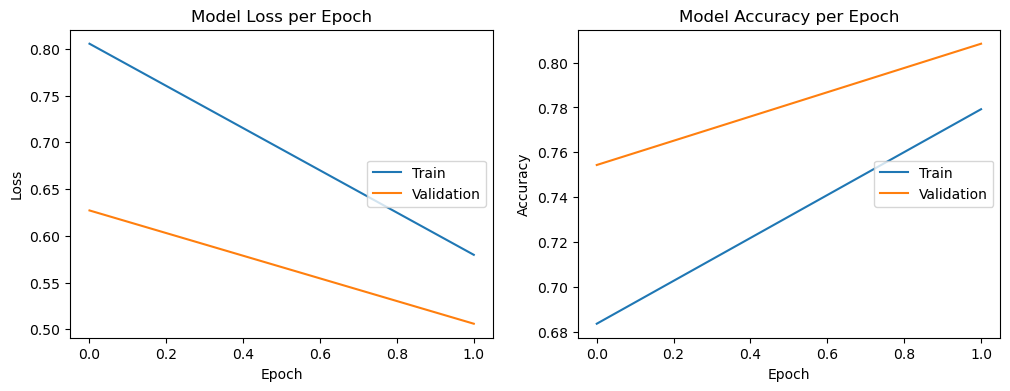

In [13]:

# Plot to visualize the model's performance over the training epochs
plt.figure(figsize=(12,4))

# Plot the training and validation loss over epochs
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='right')

# Plot the training and validation accuracy over epochs
plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='right')

# Predict the class probabilities on the test set
y_prob_dnn = model.predict(X_test_scaled)

# Convert the class probabilities into predicted class labels
y_pred_dnn = y_prob_dnn.argmax(axis=-1)

# Create a confusion matrix to compare the true labels with the predicted labels
pd.crosstab(y_test, y_pred_dnn, rownames=['Real Class'], colnames=['Class Predicted by DNN'])


## 7.2 Linear Deep Learning Example for numerical variables

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


### Preprocessing for numerical deep learning

In [ ]:
# Preprocessing of the data frame to make it available for the neural network

# Trim df_numerical
# Define columns to keep / features: here are all columns listed
to_delete = ['Country', 'VFN', 'Mh', 'Mk', 'RLFI', 'ech', '#identical occurences', 'Ct', 'Ft']

# Drop with function
df_numerical = drop_irrelevant_columns(df_numerical, to_delete)

df_numerical = df_numerical.dropna()

# Take only 0.01% to make a very small dataframe for debugging of the pipeline
df_numerical = df_numerical.head(1000000)

# Create target data: var y (pd series)
y = df_numerical["Ewltp (g/km)"]
print("Target variable: ", y.name)

X = df_numerical.drop(["Ewltp (g/km)"], axis=1)  # Define Features

# Split the data into training, testing sub-sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

def encode_categorical_features(X_train, X_test, cat_features):
    """
    One-Hot-Encodes the specified categorical features in both X_train and X_test.
    If a column is not present in the data, it will be skipped.

    Parameters:
    X_train (pd.DataFrame): Training data.
    X_test (pd.DataFrame): Test data.
    cat_features (list): List of categorical features to encode.

    Returns:
    X_train, X_test: The modified DataFrames with encoded categorical features.
    """

    for feature in cat_features:
        if feature in X_train.columns and feature in X_test.columns:
            print(f"Encoding {feature} in X_train and X_test")
            X_train = pd.get_dummies(X_train, columns=[feature], prefix=feature)
            X_test = pd.get_dummies(X_test, columns=[feature], prefix=feature)
        else:
            print(f"Skipping encoding for {feature}, column not found in both datasets.")

    print("Explanatory variables after encoding: \n", X_train.columns)
    return X_train, X_test

# Example call
cat_features = ["Ft", "Fm", "Mk", "IT", 'Ct', 'Cr', 'Ft']
X_train, X_test = encode_categorical_features(X_train, X_test, cat_features)

from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance, default range is (0, 1)
scaler = MinMaxScaler().fit(X_train)

# Apply the scaler to X_train and X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
X_train_scaled = X_train_scaled.astype('float32')
y_train = y_train.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')
y_test = y_test.astype('float32')

print(X_test.shape)
print(X_test_scaled, y_train, y_test)

print(X_train.shape)
X_train_scaled

### The linear DL Model

In [ ]:
# Build the smaller model
model = Sequential()

# Input layer with 16 neurons and ReLU activation
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))

# Batch normalization layer
model.add(BatchNormalization())

# First hidden layer with 16 neurons and ReLU activation
model.add(Dense(16, activation='relu'))

# Dropout layer with 30% dropout rate
model.add(Dropout(rate=0.3))

# Output layer with 1 neuron and linear activation for regression output
model.add(Dense(1, activation='linear'))

# Compile the model with Adam optimizer and mean squared error loss function
model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error', metrics=['mae'])

# Train the model on the training data with a validation split
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=10, batch_size=30)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f'Test Mean Absolute Error: {mae}')

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

### Model Evaluation

In [ ]:
# 9. Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# 10. Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ewltp (g/km)')
plt.ylabel('Predicted Ewltp (g/km)')
plt.title('Actual vs Predicted Ewltp (g/km)')
plt.tight_layout()
plt.show()

# 11. Print feature importance (based on the first layer weights)
feature_importance = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
feature_names = X.columns
for name, importance in sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance:.4f}")

# 8 Andreas

## Import and Load

In [1]:
import numpy as np
import pandas as pd

import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from utils_CO2 import *

# set option so that e.g. df.head() will show all columns and none are omitted
pd.set_option('display.max_columns', None)

### Choose Dataset

In [2]:
# 1.Load and view file mapping
file_mapping_df = load_file_mapping()
display(file_mapping_df)


,number,filename
0,1,minimal_with_fuel_consumption_tn05_mcp00.10.pa...
1,2,minimal_with_fuel_consumption_tn05_mcp01.00.pa...
2,3,minimal_with_fuel_consumption_tn05_mcp05.00.pa...
3,4,minimal_with_fuel_consumption_tn05_mcp10.00.pa...
4,5,minimal_with_fuel_consumption_tn10_mcp00.10.pa...
5,6,minimal_with_fuel_consumption_tn10_mcp01.00.pa...
6,7,minimal_with_fuel_consumption_tn10_mcp05.00.pa...
7,8,minimal_with_fuel_consumption_tn10_mcp10.00.pa...
8,9,minimal_with_fuel_consumption_tn15_mcp00.10.pa...
9,10,minimal_with_fuel_consumption_tn15_mcp01.00.pa...


In [3]:
# 2. Choose Dataset by number
df = load_data_by_number(29)

Loaded parquet file from local path.
Loaded file: 'minimal_without_fuel_consumption_tn20_mcp00.10.parquet'


#### edit file_mapping.csv

In [ ]:
# only when new datasets introduced: Create or append file mapping
create_or_append_file_mapping(filename_list)

## Explore/refine Dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3731625 entries, 4210654 to 12638663
Data columns (total 57 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   m (kg)                        float32
 1   Mt                            float32
 2   Ewltp (g/km)                  float32
 3   W (mm)                        float32
 4   At1 (mm)                      float32
 5   At2 (mm)                      float32
 6   ec (cm3)                      float32
 7   ep (KW)                       float32
 8   Mh_AUDI AG                    uint8  
 9   Mh_AUTOMOBILES CITROEN        uint8  
 10  Mh_AUTOMOBILES PEUGEOT        uint8  
 11  Mh_BMW AG                     uint8  
 12  Mh_DACIA                      uint8  
 13  Mh_FIAT GROUP                 uint8  
 14  Mh_FORD WERKE GMBH            uint8  
 15  Mh_JAGUAR LAND ROVER LIMITED  uint8  
 16  Mh_MERCEDES-BENZ AG           uint8  
 17  Mh_OPEL AUTOMOBILE            uint8  
 18  Mh_PORSCHE     

In [5]:
# df = df.drop(columns=['m (kg)','Fuel consumption '])
df = df.drop(columns=['m (kg)'])
df['Area (m2)'] = (df['W (mm)'] * ((df['At1 (mm)'] + df['At2 (mm)'])/2)) / 1000000
df = df.drop(columns=['W (mm)', 'At1 (mm)', 'At2 (mm)'])

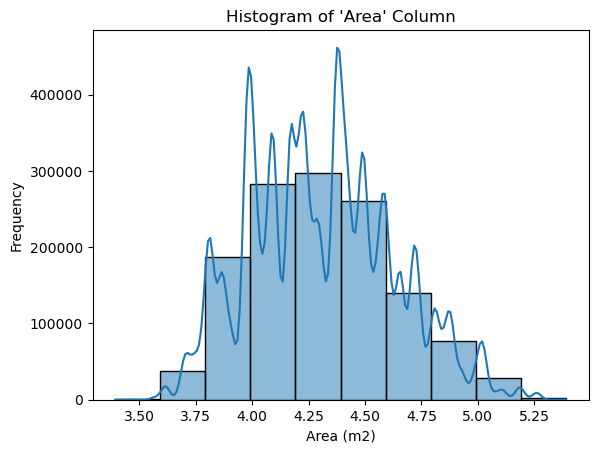

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting histogram of the 'size' column
sns.histplot(df['Area (m2)'], bins=10, kde=True)
plt.xlabel("Area (m2)")
plt.ylabel("Frequency")
plt.title("Histogram of 'Area' Column")
plt.show()


## === Regression (Alex) ===

### Loading Libraries and Data

In [6]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# libraries LR

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split


from statsmodels.formula.api import ols
#from statsmodels.formula.api import sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Micro-Preprocessing: Outliers and Multicollinearity

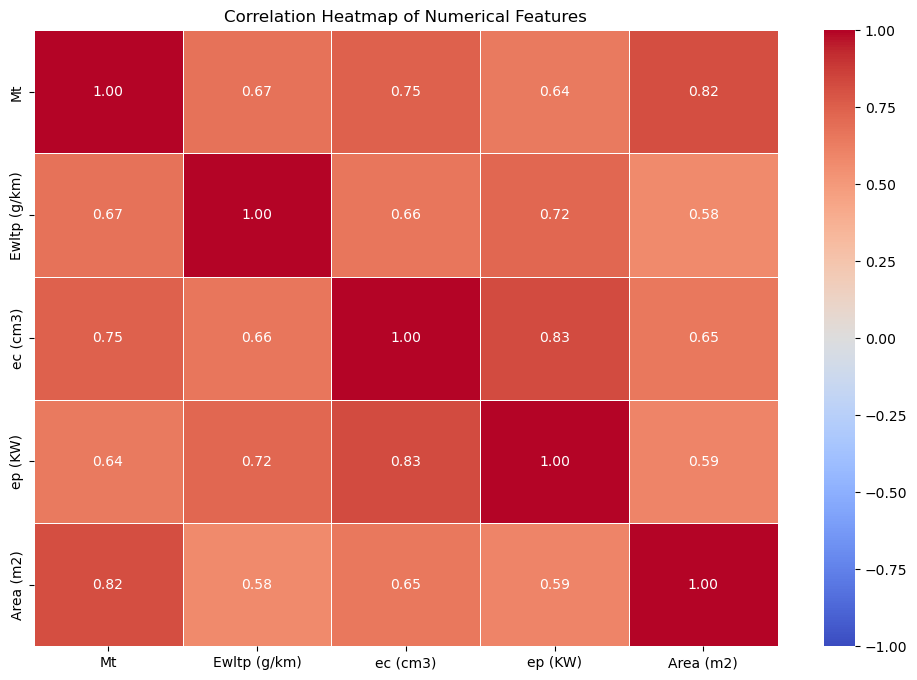

In [7]:
# Let's check for Multicollinearity

# Select only the numerical columns from the DataFrame (replace with the actual numerical columns in your DataFrame)
numerical_cols = df.select_dtypes(include=['float32', 'float64']).columns

# Compute the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

###
#Interpretation:

#Mt (WLTP test mass) and m (kg) shows a correlation of 0.98. Which makes sense, as Wltp test mass (Mt) is simply the same mass in running order (m) with some added weight, so that the testing conditions are closer to reality. m (kg), will be removed.
#Fuel consumption shows a stron predictive power, but it is not highly correlated to other variables.
#Only the linear regression using the python library instead of sickit will be ran as it offers a comprehensive report

### Modeling, performance and interpretation

In [10]:

# Step 1: Separate target variable 'Ewltp (g/km)' and features

target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features (dropping the target)
y = df[target_column]  # Target variable

# Step 2: Split the data into training and test sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale the numerical variables (including the target, if necessary)

scaler = StandardScaler()

# Scaling X (numerical features)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames with original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Scaling y (target variable) - OPTIONAL
# scaler_y = StandardScaler()
# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel() # Flatten array after scaling
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Step 4: Run Linear Regression using Python's statsmodels instead of sickitlearn. The output is more comprehensive.

# Add a constant to the features for statsmodels (to include the intercept)
X_train_scaled_with_constant = sm.add_constant(X_train_scaled)
X_test_scaled_with_constant = sm.add_constant(X_test_scaled)

# Train the model
lr_stats_model = sm.OLS(y_train, X_train_scaled_with_constant).fit()

# Make predictions
y_pred_stats = lr_stats_model.predict(X_test_scaled_with_constant)

# Evaluation Metrics
mse_stats = mean_squared_error(y_test, y_pred_stats)
r2_stats = r2_score(y_test, y_pred_stats)

print(f"Test MSE (statsmodels): {mse_stats}")
print(f"Test R-squared (statsmodels): {r2_stats}")

# Summary of the model
print(lr_stats_model.summary())

####

#Interpretation:

# An R² value of 0.92 means that approximately 92% of the variance in the target variable is explained by the features in the  model.
# MSE (the average squared difference between the predicted and actual values). A lower MSE indicates better model performance, as it means the predictions are closer to the actual values.

# However, there is a warning regarding the presence of multicollinearity in the OLS model.

Test MSE (statsmodels): 26535.476052036785
Test R-squared (statsmodels): -21.117774709906392
                                 OLS Regression Results                                
Dep. Variable:           Ewltp (g/km)   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.034
Method:                 Least Squares   F-statistic:                              1991.
Date:                Sun, 27 Oct 2024   Prob (F-statistic):                        0.00
Time:                        04:18:38   Log-Likelihood:                     -1.9441e+07
No. Observations:             2985300   AIC:                                  3.888e+07
Df Residuals:                 2985247   BIC:                                  3.888e+07
Df Model:                          53                                                  
Covariance Type:            nonrobust                                                  
                           

### Interpretability: Feature Importance

                                 Feature  Coefficient  Abs_Coefficient
const                          Intercept   162.103583       162.103583
Mt                                    Mt    15.220550        15.220550
Ft_PETROL                      Ft_PETROL    11.603331        11.603331
ec (cm3)                        ec (cm3)     9.412314         9.412314
ep (KW)                          ep (KW)     8.178511         8.178511
Fm_H                                Fm_H    -6.436255         6.436255
Mh_BMW AG                      Mh_BMW AG    -5.817520         5.817520
Ct_M1G                            Ct_M1G     4.272479         4.272479
Mh_Other                        Mh_Other     2.546568         2.546568
IT_code_e13 29            IT_code_e13 29    -2.397361         2.397361
IT_code_e8 29              IT_code_e8 29    -1.826739         1.826739
IT_code_Other              IT_code_Other    -1.710490         1.710490
Area (m2)                      Area (m2)     1.521908         1.521908
Fm_M  

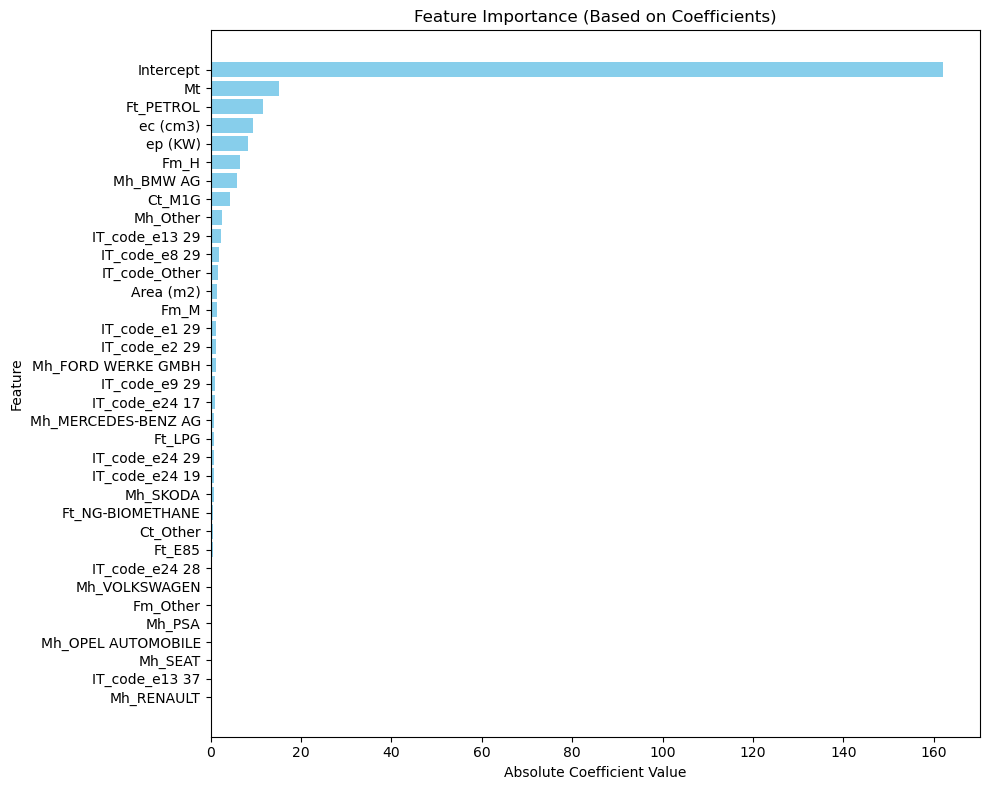

In [15]:
# Extracting coefficients
coefficients = lr_stats_model.params
# The index of coefficients includes 'const' (intercept), so we exclude it
feature_names = X_train.columns  # Assuming these are the original feature names

# Combine the feature names and their coefficients into a DataFrame for easier interpretation
coeff_df = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names.tolist(),
    'Coefficient': coefficients
})

# Sorting by absolute coefficient value to see feature importance
coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display feature importance
print(coeff_df)

# Visualizing feature importance
plt.figure(figsize=(10, 8))
plt.barh(coeff_df['Feature'], coeff_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Based on Coefficients)')
plt.gca().invert_yaxis()  # Invert to display the highest values at the top
plt.tight_layout()
plt.show()

####

#Interpretation:
#- The features Fm_P, Ft_PETROL/ELECTRIC, and Ft_DIESEL/ELECTRIC have the largest absolute coefficient values, indicating that they have the strongest influence on the target variable (Ewltp (g/km))
#- Many other features, including variables like Mh_VW, Fuel consumption, and ep (KW), have coefficients that are so small that they do not show up in the bar plot. This suggests that:
#These variables may have minimal or no influence on the target variable after fitting the model.
#There could be multicollinearity, meaning these variables' effect on the target might be captured by the top three features.

#Now let's see if multicollinearity and pontential overfitting can be addressed via Elastic Net with cross validation (it combines the penalties of both Lasso regression (L1 regularization) and Ridge regression (L2 regularization)).


### Multicollinearity and Overfitting: Elastic Net with CV and/or removal of variable

In [19]:
from sklearn.linear_model import ElasticNetCV

# Step 1: Separate target variable 'Ewltp (g/km)' and features

target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features (dropping the target)
y = df[target_column]  # Target variable

# Step 2: Split the data into training and test sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale the numerical variables (including the target, if necessary)

scaler = StandardScaler()

# Scaling X (numerical features)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames with original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Step 6: Train the Elastic Net model
elastic_net_cv = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9], random_state=42)
elastic_net_cv.fit(X_train_scaled, y_train)

# Step 7: Make predictions and evaluate
y_pred_train = elastic_net_cv.predict(X_train_scaled)
y_pred_test = elastic_net_cv.predict(X_test_scaled)

# Step 8: Evaluation metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Print the evaluation results
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R2: {train_r2}")
print(f"Test R2: {test_r2}")


####

#Interpretation:
#- Training MSE and Test MSE are very close, and the Training R² and Test R² values are also very similar (both around 0.92). This indicates that the model is generalizing well, which means overfitting does not seem to be a significant issue here.
#- Elastic Net helps to manage multicollinearity. The L2 regularization term helps reduce the impact of correlated features, while the L1 term can push less important features' coefficients to zero, effectively selecting features. Hence, multicollinearity is likely being addressed due to the regularization

Training MSE: 22.915134348472357
Test MSE: 22.735286288323678
Training R2: 0.9815628435652528
Test R2: 0.9816641155518699


In [20]:
# Let's visualize the influence of the parameters on the model
# Print the alphas used in cross-validation
print("Alpha values used in cross-validation:")
print(elastic_net_cv.alphas_)

Alpha values used in cross-validation:
[[3.33154066e+02 3.10700597e+02 2.89760416e+02 2.70231534e+02
  2.52018833e+02 2.35033607e+02 2.19193129e+02 2.04420246e+02
  1.90643005e+02 1.77794305e+02 1.65811564e+02 1.54636419e+02
  1.44214442e+02 1.34494871e+02 1.25430367e+02 1.16976780e+02
  1.09092937e+02 1.01740438e+02 9.48834729e+01 8.84886444e+01
  8.25248059e+01 7.69629102e+01 7.17758676e+01 6.69384144e+01
  6.24269893e+01 5.82196192e+01 5.42958117e+01 5.06364557e+01
  4.72237280e+01 4.40410068e+01 4.10727904e+01 3.83046218e+01
  3.57230185e+01 3.33154066e+01 3.10700597e+01 2.89760416e+01
  2.70231534e+01 2.52018833e+01 2.35033607e+01 2.19193129e+01
  2.04420246e+01 1.90643005e+01 1.77794305e+01 1.65811564e+01
  1.54636419e+01 1.44214442e+01 1.34494871e+01 1.25430367e+01
  1.16976780e+01 1.09092937e+01 1.01740438e+01 9.48834729e+00
  8.84886444e+00 8.25248059e+00 7.69629102e+00 7.17758676e+00
  6.69384144e+00 6.24269893e+00 5.82196192e+00 5.42958117e+00
  5.06364557e+00 4.72237280e+00

In [ ]:
alphas = elastic_net_cv.alphas_

plt.figure(figsize=(10, 6))

# Iterate over each l1_ratio and plot the corresponding MSE path
for i, l1_ratio in enumerate(elastic_net_cv.l1_ratio):
    # Calculate the mean MSE across the folds for each alpha and l1_ratio
    mean_mse = elastic_net_cv.mse_path_[i].mean(axis=1)  # Shape is (n_alphas,)

    # Plot the mean MSE path for each l1_ratio
    plt.plot(alphas, mean_mse, label=f'Mean MSE for l1_ratio= {l1_ratio:.2f}', linewidth=2)

# Add a legend to the plot
plt.legend(loc='upper right', fontsize=10)

# Add a log scale to the x-axis (alphas)
plt.xscale('log')

# Set labels for x and y axis
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)

# Add title
plt.title('Mean Squared Error for each Alpha and L1 ratio', fontsize=14)

# Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

 ## === Decision Tree (Alex) ===

### Loading Libraries and Data

In [11]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Micro-preprocessing: Not needed

### Data preparation for modeling

In [ ]:
#  von Alex
# 
# 
# # Step 1: Separate target variable 'Ewltp (g/km)' and features

target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features (dropping the target)
y = df[target_column]  # Target variable

# Step 2: Encode categorical variables (one-hot encoding for categorical columns)

categorical_cols = X.select_dtypes(include=['category']).columns.tolist()  # Select categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X[categorical_cols])

# Step 3: Create DataFrame for encoded categorical variables and combine with numeric variables

X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_num = X.select_dtypes(include=['float32'])  # Select numerical columns
X_combined = pd.concat([X_num.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 4: Split the data into training and test sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 5: Scale the numerical variables (including the target, if necessary)

scaler = StandardScaler()

# Scaling X (numerical features)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Von Regression kopiert (noch anpassen)

# Step 1: Separate target variable 'Ewltp (g/km)' and features

target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features (dropping the target)
y = df[target_column]  # Target variable

# Step 2: Split the data into training and test sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale the numerical variables (including the target, if necessary)

scaler = StandardScaler()

# Scaling X (numerical features)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames with original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Scaling y (target variable) - OPTIONAL
# scaler_y = StandardScaler()
# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel() # Flatten array after scaling
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Step 4: Run Linear Regression using Python's statsmodels instead of sickitlearn. The output is more comprehensive.

# Add a constant to the features for statsmodels (to include the intercept)
X_train_scaled_with_constant = sm.add_constant(X_train_scaled)
X_test_scaled_with_constant = sm.add_constant(X_test_scaled)

# Train the model
lr_stats_model = sm.OLS(y_train, X_train_scaled_with_constant).fit()

# Make predictions
y_pred_stats = lr_stats_model.predict(X_test_scaled_with_constant)

### Modeling Performance and Interpretation

In [ ]:
# Step 1: Train a Decision Tree Model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Step 2: Make Predictions
y_pred = dt_model.predict(X_test_scaled)

# Step 3: Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


####
# Interpretation:
# With the R-squared of 0.99 indicating that the Decision Tree model is explaining 99.33% of the variance in the training set and an extremely low MSE on the training set (which suggests that the model is performing almost perfectly on the training data). I can safely discern that the model is overfitting.
#Next steps will be pruning and cross-validation

In [ ]:
# This part is bugged

# Step 6: Visualize the Decision Tree

# Step 6: Visualize the Decision Tree (corrected) --> error: IndexError: index 30 is out of bounds for axis 0 with size 13

#plt.figure(figsize=(20, 10))
#plot_tree(dt_model, filled=True, feature_names=X.columns, rounded=True)
#plt.title('Decision Tree Visualization')
#plt.show()

# Other trials --> error'numpy.ndarray' object has no attribute 'columns'.Pertaining this line: --> 4 plot_tree(dt_model, filled=True, feature_names=X_train_scaled.columns, rounded=True)
#plt.figure(figsize=(20, 10))
#plot_tree(dt_model, filled=True, feature_names=X_train_scaled.columns, rounded=True)
#plt.title('Decision Tree Visualization')
#plt.show()

### Interpretability: Feature Importance

In [ ]:
# Step 4: Get feature importance from the model
feature_importances = dt_model.feature_importances_

# Step 5: Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Step 6: Create a plot of the feature importances
plt.figure(figsize=(10, 6))

# Plot the top 20 most important features
plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')

# Add feature names as labels to the x-axis
plt.xticks(range(len(feature_importances)), X_train.columns[indices], rotation=90)

# Add title and labels
plt.title("Feature Importance from Decision Tree")
plt.xlabel("Feature")
plt.ylabel("Importance")

# Show the plot
plt.tight_layout()
plt.show()

####

#Interpretation

### Multicollinearity and Overfitting: Pruning and Elastic Net with CV

In [ ]:
# Decision Trees handle internally multicollinearity, but are prone to overfitting. Lets try pruning to address the later.

#Pruning

dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred = dt_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
# Cross validation - No need to use pre-scaled data for cross-validation but it needs encoded X

scores = cross_val_score(dt_model, X_combined, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores.mean()}")


####

# Interpretation:
#After pruning the R-sqaured is 0.95 and the cross-validated R-squared of 0.94 indicates that the decision tree model explains a substantial portion of the variance
#in the target variable (Ewltp (g/km)) across the different folds of the cross-validation process.
# This suggests that the model generalizes well to unseen data and has a strong predictive power. Let's check Elastic Net with CV



### Elastic Net with CV - Decision Tree Regressor (40 min execution time)

In [ ]:
#Decision trees expect not-scaled numerical data, but encoded categorical variables.

# Step 1: Separate features (X) and target variable (y)
target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features (dropping the target)
y = df[target_column]  # Target variable

# Step 2: Encode categorical variables (one-hot encoding)
categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()  # Select categorical columns

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X[categorical_cols])

# Create DataFrame for encoded categorical variables
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Combine encoded categorical variables with the numeric variables
X_num = X.select_dtypes(include=['float32', 'int64'])  # Select numerical columns
X_combined = pd.concat([X_num.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 3: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [ ]:
# Define the parameter grid

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 2, 5, 7],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 3]
}

# Create a DecisionTreeRegressor instance
dt_model = DecisionTreeRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5)

# Fit the grid search to your data (use X_train instead of X_train_scaled)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Best Parameters:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# The code above is corrected but not tested.
# Result: Best Parameters: {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 8} / Mean Squared Error: 57322.07454577695 / R-squared: -23.515788791688205
# Feature Scaling: Decision trees are not sensitive to feature scaling, but you applied scaling (with X_train_scaled). This is likely unnecessary for decision
# trees and can sometimes lead to issues, particularly when the model expects data in its original form (e.g., non-scaled categorical variables).
# Feature Names Warning: The warning is caused by a mismatch between the
# original X_train (which had feature names) and X_train_scaled (which doesn't include feature names after scaling). Decision trees prefer having feature names for better interpretability.


####

# Interpretation